In [1]:
!module load StdEnv/2020 gcc/9.3.0 opencv python/3.8 scipy-stack hdf5 geos/3.10.2 arrow/7.0.0


Lmod is automatically replacing "intel/2020.1.217" with "gcc/9.3.0".


Due to MODULEPATH changes, the following have been reloaded:
  1) mii/1.1.2

The following have been reloaded with a version change:
  1) StdEnv/2023 => StdEnv/2020
  2) blis/0.9.0 => blis/0.8.1
  3) flexiblas/3.3.1 => flexiblas/3.0.4
  4) gcc/12.3 => gcc/9.3.0
  5) gcccore/.12.3 => gcccore/.9.3.0
  6) gentoo/2023 => gentoo/2020
  7) libfabric/1.18.0 => libfabric/1.10.1
  8) openmpi/4.1.5 => openmpi/4.0.3
  9) ucx/1.14.1 => ucx/1.8.0



In [2]:
!source ~/HIPT_Embedding_Env/bin/activate

In [3]:
import sys
import os

In [4]:
sys.path.append(os.path.abspath('/home/sorkwos/projects/rrg-senger-ab/multimodality/contrastive_learning/tab-transformer-pytorch'))

In [5]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import glob
import xmltodict
from IPython.display import display, HTML


# Function to drop columns with all same values or all NaN values
def drop_constant_columns(df):
    # Drop columns with all NaN values
    df = df.dropna(axis=1, how='all')

    # Find columns where all values are the same (including columns with a single unique non-NaN value)
    nunique = df.apply(pd.Series.nunique, dropna=False)
    cols_to_drop = nunique[nunique <= 1].index

    # Drop these columns
    df = df.drop(cols_to_drop, axis=1)

    return df

# Display the DataFrame in a scrollable format
def display_scrollable_dataframe(df, max_rows=20):
    display(HTML(df.to_html(max_rows=max_rows, classes='table table-striped table-bordered table-hover')))

# Function to recursively extract tags and values
def extract_tags_and_values(elem, parent_tag="", tag_count=None):
    if tag_count is None:
        tag_count = {}

    data = {}
    for child in elem:
        # Get the base tag without any namespaces
        base_tag = child.tag.split('}')[-1]

        # If this tag has a sequence attribute, append it to the tag
        sequence = child.attrib.get('sequence')

        # Construct full tag name, including parent if necessary
        if parent_tag:
            full_tag = f"{parent_tag}.{base_tag}"
        else:
            full_tag = base_tag

        # Handle repeated tags: append index or sequence to make the tag unique
        if sequence:
            full_tag += f"_seq_{sequence}"
        elif full_tag in tag_count:
            tag_count[full_tag] += 1
            full_tag += f"_{tag_count[full_tag]}"
        else:
            tag_count[full_tag] = 1

        # If the child has text and it's not just whitespace, store the value
        if child.text and child.text.strip():
            data[full_tag] = child.text.strip()

        # Recursively call the function to process the child elements
        data.update(extract_tags_and_values(child, full_tag, tag_count))

    return data

# Function to process all XML files in subfolders and consolidate them into a DataFrame
def process_xml_files(root_folder):
    all_data = []

    # Recursively find all XML files in the root folder and subfolders
    xml_files = glob.glob(os.path.join(root_folder, '**/*.xml'), recursive=True)

    for xml_file in xml_files:
        # Load and parse each XML file
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Extract the patient data using the extract_tags_and_values function
        patient_data = extract_tags_and_values(root)

        # Add the patient data to the list
        all_data.append(patient_data)

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(all_data)

    # Optionally: Drop columns that have all NaN values or are constant
    df_cleaned = drop_constant_columns(df)

    return df_cleaned

# Function to extract and organize follow-up columns dynamically
def extract_and_organize_followup(df, prefix="follow_up_seq"):
    # Extract columns that match the follow-up sequence prefix
    follow_up_columns = [col for col in df.columns if prefix in col]
    
    # Extract unique sequence numbers dynamically (e.g., _1, _2, etc.)
    seq_numbers = sorted(set([col.split(f"{prefix}_")[1].split('_')[0] for col in follow_up_columns if f"{prefix}_" in col]))
    
    # Organize columns based on the sequence numbers
    organized_columns = []
    for seq in seq_numbers:
        seq_columns = [col for col in follow_up_columns if f"{prefix}_{seq}" in col]
        organized_columns.extend(seq_columns)
    
    return organized_columns

# Function to extract and organize drug columns, accounting for drug_1 being just 'patient.drugs.drug'
def extract_and_organize_drugs(df, base_prefix="patient.drugs.drug"):
    # Extract all drug-related columns (both drug_1 and drug_x)
    drug_columns = [col for col in df.columns if base_prefix in col]
    
    # Special handling for 'drug_1' columns without a suffix
    drug_1_columns = [col for col in drug_columns if base_prefix + "_" not in col]
    
    # Extract unique drug sequence numbers dynamically, handling possible extra parts in the column names
    drug_seq_numbers = sorted(set([int(col.split(f"{base_prefix}_")[1].split('.')[0])
                                   for col in drug_columns if f"{base_prefix}_" in col]))
    
    # Organize columns based on the sequence numbers
    organized_columns = drug_1_columns  # Start with drug_1 columns
    for seq in drug_seq_numbers:
        seq_columns = [col for col in drug_columns if f"{base_prefix}_{seq}." in col]
        organized_columns.extend(seq_columns)
    
    return organized_columns

/home/sorkwos/HIPT_Embedding_Env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Edition standardizations scripts here

In [6]:
def map_icd_to_site(icd_code):
    """Maps ICD-10 code to the corresponding AJCC site."""
    
    if icd_code in ['C02.9', 'C04.9', 'C06.9', 'C06.0', 'C03.9', 'C00.9', 'C05.0', 'C03.1', 'C04.0', 'C06.2', 'C02.1', 'C05.9', 'C03.0', 'C02.2']:
        return 'Section 3'
    
    elif icd_code in ['C32.9','C32.1']:
        return 'Section 5'
    
    elif icd_code == 'C14.8':
        return 'Section 9'
    
    elif icd_code in ['C09.9', 'C01', 'C10.9', 'C10.3','C13.9']:
        return 'Section 4'
    
    elif icd_code == 'C41.1':
        return 'Section 27'
    
    else:
        return 'Unknown Site'
    
def map_section_3_6th_to_7th(t_stage_6th, n_stage_6th, m_stage_6th):
    """Maps AJCC 6th edition to 7th edition for Section 3: Lip and Oral Cavity."""
    # T4 lesions have been divided into T4a (moderately advanced local disease) 
    # and T4b (very advanced local disease), leading to the stratification of 
    # Stage IV into Stage IVA, IVB, and IVC.
    if t_stage_6th == 'T4':
        return 'T4a', n_stage_6th, m_stage_6th  # T4 has been split into T4a and T4b
    else:
        return t_stage_6th, n_stage_6th, m_stage_6th


def map_section_4_6th_to_7th(t_stage_6th, n_stage_6th, m_stage_6th, tissue_or_organ):
    """Maps AJCC 6th edition to 7th edition for Section 4 using the provided mappings."""
    
    if tissue_or_organ in ['Oral Tongue', 'Oral Cavity', 'Floor of mouth', 'Tonsil', 'Base of tongue', 'Buccal Mucosa', 
                           'Alveolar Ridge', 'Hard Palate', 'Lip', 'Oropharynx', 'Hypopharynx', 'Larynx']:
        # The conditions here should match your exact categories
        if t_stage_6th == 'T4':
            return 'T4a', n_stage_6th, m_stage_6th  # Modify based on specific stratification
        else:
            return t_stage_6th, n_stage_6th, m_stage_6th
    else:
        return t_stage_6th, n_stage_6th, m_stage_6th

def map_section_5_6th_to_7th(t_stage_6th, n_stage_6th, m_stage_6th):
    """Maps AJCC 6th edition to 7th edition for Section 5: Larynx."""
    # T4 lesions have been divided into T4a (moderately advanced local disease) 
    # and T4b (very advanced local disease), leading to the stratification of 
    # Stage IV into Stage IVA, IVB, and IVC.
    if t_stage_6th == 'T4':
        return 'T4a', n_stage_6th, m_stage_6th  # T4 has been split into T4a and T4b
    else:
        return t_stage_6th, n_stage_6th, m_stage_6th

def map_section_9_6th_to_7th(t_stage_6th, n_stage_6th, m_stage_6th):
    """Maps AJCC 6th edition to 7th edition for Section 9: Mucosal Melanoma of the Head and Neck."""
    # No changes needed for Section 9 as it didn't exist in the 6th edition.
    return t_stage_6th, n_stage_6th, m_stage_6th

def map_section_27_6th_to_7th(t_stage_6th, n_stage_6th, m_stage_6th):
    """Maps AJCC 6th edition to 7th edition for Section 27: Bone (Mandible)."""
    # Stage III is reserved for G3 and G4 grades in the 7th edition.
    return t_stage_6th, n_stage_6th, m_stage_6th


    
def map_ajcc_6th_to_7th(icd_code, t_stage_6th, n_stage_6th, m_stage_6th, tissue_or_organ, grade=None):
    """Maps AJCC 6th edition to 7th edition based on the section derived from the ICD-10 code."""
    section = map_icd_to_site(icd_code)
    
    if section == 'Section 3':
        return map_section_3_6th_to_7th(t_stage_6th, n_stage_6th, m_stage_6th)
    elif section == 'Section 4':
        return map_section_4_6th_to_7th(t_stage_6th, n_stage_6th, m_stage_6th, tissue_or_organ)
    elif section == 'Section 5':
        return map_section_5_6th_to_7th(t_stage_6th, n_stage_6th, m_stage_6th)
    elif section == 'Section 9':
        return map_section_9_6th_to_7th(t_stage_6th, n_stage_6th, m_stage_6th)
    elif section == 'Section 27':
        return map_section_27_6th_to_7th(t_stage_6th, n_stage_6th, m_stage_6th)
    else:
        return 'Unknown Section', t_stage_6th, n_stage_6th, m_stage_6th

def map_section_3_5th_to_6th(t_stage_5th, n_stage_5th, m_stage_5th):
    """Maps AJCC 5th edition to 6th edition for Section 3: Lip and Oral Cavity."""
    # T4 lesions have been divided into T4a (resectable) and T4b (unresectable), 
    # leading to the division of Stage IV into Stage IVA, IVB, and IVC.
    if t_stage_5th == 'T4':
        return 'T4a', n_stage_5th, m_stage_5th  # Assuming resectable; adjust if needed
    else:
        return t_stage_5th, n_stage_5th, m_stage_5th

def map_section_4_5th_to_6th(t_stage_5th, n_stage_5th, m_stage_5th, tissue_or_organ):
    """Maps AJCC 5th edition to 6th edition for Section 4: Pharynx, considering the specific subregions."""

    # For oropharynx and hypopharynx subdivisions:
    # T4 lesions are divided into T4a and T4b in the 6th edition.

    if tissue_or_organ in ['Oral Tongue', 'Oral Cavity', 'Floor of mouth', 'Tonsil', 'Base of tongue',
                           'Buccal Mucosa', 'Alveolar Ridge', 'Hard Palate', 'Lip', 'Oropharynx', 'Hypopharynx', 'Larynx']:
        if t_stage_5th == 'T4':
            return 'T4a', n_stage_5th, m_stage_5th  # Assuming resectable
        else:
            return t_stage_5th, n_stage_5th, m_stage_5th
    else:
        return t_stage_5th, n_stage_5th, m_stage_5th


def map_section_5_5th_to_6th(t_stage_5th, n_stage_5th, m_stage_5th):
    """Maps AJCC 5th edition to 6th edition for Section 5: Larynx."""
    # T4 lesions have been divided into T4a (resectable) and T4b (unresectable),
    # leading to the division of Stage IV into Stage IVA, IVB, and IVC.
    if t_stage_5th == 'T4':
        return 'T4a', n_stage_5th, m_stage_5th  # Assuming resectable; adjust if needed
    else:
        return t_stage_5th, n_stage_5th, m_stage_5th

def map_section_9_5th_to_6th(t_stage_5th, n_stage_5th, m_stage_5th):
    """Maps AJCC 5th edition to 6th edition for Section 9: Mucosal Melanoma of the Head and Neck."""
    # No changes needed for Section 9 as it did not exist in the 6th edition.
    return t_stage_5th, n_stage_5th, m_stage_5th

def map_section_27_5th_to_6th(t_stage_5th, n_stage_5th, m_stage_5th):
    """Maps AJCC 5th edition to 6th edition for Section 27: Bone (Mandible)."""
    # M1 lesions have been divided into M1a and M1b:
    # - M1a is lung-only metastases (Stage IVA)
    # - M1b is metastases to other distant sites, including lymph nodes (Stage IVB).
    if m_stage_5th == 'M1':
        return t_stage_5th, n_stage_5th, 'M1a'  
    else:
        return t_stage_5th, n_stage_5th, m_stage_5th

def map_ajcc_5th_to_6th(icd_code, t_stage_5th, n_stage_5th, m_stage_5th, tissue_or_organ):
    """Maps AJCC 5th edition to 6th edition based on the section derived from the ICD-10 code."""
    section = map_icd_to_site(icd_code)
    
    if section == 'Section 3':
        return map_section_3_5th_to_6th(t_stage_5th, n_stage_5th, m_stage_5th)
    elif section == 'Section 4':
        return map_section_4_5th_to_6th(t_stage_5th, n_stage_5th, m_stage_5th, tissue_or_organ)
    elif section == 'Section 5':
        return map_section_5_5th_to_6th(t_stage_5th, n_stage_5th, m_stage_5th)
    elif section == 'Section 9':
        return map_section_9_5th_to_6th(t_stage_5th, n_stage_5th, m_stage_5th)
    elif section == 'Section 27':
        return map_section_27_5th_to_6th(t_stage_5th, n_stage_5th, m_stage_5th)
    else:
        return t_stage_5th, n_stage_5th, m_stage_5th

def map_clinical_5th_to_6th(row):
    # Clinical mapping
    clinical_t, clinical_n, clinical_m = map_ajcc_5th_to_6th(
        icd_code=row['patient.icd_10'],
        t_stage_5th=row['patient.stage_event.tnm_categories.clinical_categories.clinical_T'],
        n_stage_5th=row['patient.stage_event.tnm_categories.clinical_categories.clinical_N'],
        m_stage_5th=row['patient.stage_event.tnm_categories.clinical_categories.clinical_M'],
        tissue_or_organ=row['patient.anatomic_neoplasm_subdivision']
    )
    
    return pd.Series({
        'ajcc_clinical_t': clinical_t,
        'ajcc_clinical_n': clinical_n,
        'ajcc_clinical_m': clinical_m

    })

def map_clinical_6th_to_7th(row):
    # Clinical mapping
    clinical_t, clinical_n, clinical_m = map_ajcc_6th_to_7th(
        icd_code=row['patient.icd_10'],
        t_stage_6th=row['patient.stage_event.tnm_categories.clinical_categories.clinical_T'],
        n_stage_6th=row['patient.stage_event.tnm_categories.clinical_categories.clinical_N'],
        m_stage_6th=row['patient.stage_event.tnm_categories.clinical_categories.clinical_M'],
        tissue_or_organ=row['patient.anatomic_neoplasm_subdivision']
    )
    
    return pd.Series({
        'ajcc_clinical_t': clinical_t,
        'ajcc_clinical_n': clinical_n,
        'ajcc_clinical_m': clinical_m
    })

def map_clinical_and_pathologic_5th_to_6th(row):
    # Clinical mapping
    clinical_t, clinical_n, clinical_m = map_ajcc_5th_to_6th(
        icd_code=row['patient.icd_10'],
        t_stage_5th=row['patient.stage_event.tnm_categories.clinical_categories.clinical_T'],
        n_stage_5th=row['patient.stage_event.tnm_categories.clinical_categories.clinical_N'],
        m_stage_5th=row['patient.stage_event.tnm_categories.clinical_categories.clinical_M'],
        tissue_or_organ=row['patient.anatomic_neoplasm_subdivision']
    )
    
    # Pathologic mapping
    pathologic_t, pathologic_n, pathologic_m = map_ajcc_5th_to_6th(
        icd_code=row['patient.icd_10'],
        t_stage_5th=row['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'],
        n_stage_5th=row['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'],
        m_stage_5th=row['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'],
        tissue_or_organ=row['patient.anatomic_neoplasm_subdivision']
    )
    
    return pd.Series({
        'patient.stage_event.tnm_categories.clinical_categories.clinical_T': clinical_t,
        'patient.stage_event.tnm_categories.clinical_categories.clinical_N': clinical_n,
        'patient.stage_event.tnm_categories.clinical_categories.clinical_M': clinical_m,
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T': pathologic_t,
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N': pathologic_n,
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M': pathologic_m
    })

def map_clinical_and_pathologic_6th_to_7th(row):
    # Clinical mapping
    clinical_t, clinical_n, clinical_m = map_ajcc_6th_to_7th(
        icd_code=row['patient.icd_10'],
        t_stage_6th=row['patient.stage_event.tnm_categories.clinical_categories.clinical_T'],
        n_stage_6th=row['patient.stage_event.tnm_categories.clinical_categories.clinical_N'],
        m_stage_6th=row['patient.stage_event.tnm_categories.clinical_categories.clinical_M'],
        tissue_or_organ=row['patient.anatomic_neoplasm_subdivision']
    )
    
    # Pathologic mapping
    pathologic_t, pathologic_n, pathologic_m = map_ajcc_6th_to_7th(
        icd_code=row['patient.icd_10'],
        t_stage_6th=row['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'],
        n_stage_6th=row['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'],
        m_stage_6th=row['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'],
        tissue_or_organ=row['patient.anatomic_neoplasm_subdivision']
    )
    
    return pd.Series({
        'patient.stage_event.tnm_categories.clinical_categories.clinical_T': clinical_t,
        'patient.stage_event.tnm_categories.clinical_categories.clinical_N': clinical_n,
        'patient.stage_event.tnm_categories.clinical_categories.clinical_M': clinical_m,
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T': pathologic_t,
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N': pathologic_n,
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M': pathologic_m
    })

In [7]:
# Example usage
root_folder = './tcga_hnsc_xml_clinical'  # Specify your root folder here

# Process all XML files and get the consolidated DataFrame
df = process_xml_files(root_folder)

In [8]:
radiation_columns = extract_and_organize_drugs(df,"patient.radiations.radiation")
reordered_columns_df_1 = pd.concat([df.drop(columns=radiation_columns), df[radiation_columns]], axis=1)

drug_columns = extract_and_organize_drugs(reordered_columns_df_1)
reordered_columns_df_2 = pd.concat([reordered_columns_df_1.drop(columns=drug_columns), reordered_columns_df_1[drug_columns]], axis=1)

follow_up_columns = extract_and_organize_followup(reordered_columns_df_2)
reordered_columns_df_3 = pd.concat([reordered_columns_df_2.drop(columns=follow_up_columns), reordered_columns_df_2[follow_up_columns]], axis=1)

1. Remove follow_up, radiation and drug information

In [9]:
new_df = reordered_columns_df_3.loc[:, ~reordered_columns_df_3.columns.str.contains("patient.follow_ups|patient.radiations|patient.drugs")]

2. Need to keep patient.bcr_patient_barcode and patient.bcr_patient_uuid for WSI mapping. remove other ID related fields (admin.file_uuid,admin.batch_number,patient.patient_id). 

In [10]:

new_df = new_df.drop(["admin.file_uuid", "admin.batch_number", "patient.patient_id"], axis=1)
#remove: admin.file_uuid, admin.batch_numer, patient.patient_id, 

In [11]:

for column in new_df.columns:
    print(f"Column: {column}")
    value_counts = new_df[column].value_counts(normalize=True,dropna=False) * 100
    for value, percentage in value_counts.items():
        print(f"  Value: {value}, Percentage: {percentage:.2f}%")
    print("\n" + "="*50 + "\n")

Column: patient.histological_type
  Value: Head & Neck Squamous Cell Carcinoma, Percentage: 97.92%
  Value: Head & Neck Squamous Cell Carcinoma Basaloid Type, Percentage: 1.89%
  Value: Head & Neck Squamous Cell Carcinoma, Spindle Cell Variant, Percentage: 0.19%


Column: patient.tissue_prospective_collection_indicator
  Value: NO, Percentage: 65.15%
  Value: YES, Percentage: 34.47%
  Value: nan, Percentage: 0.38%


Column: patient.tissue_retrospective_collection_indicator
  Value: YES, Percentage: 65.15%
  Value: NO, Percentage: 34.47%
  Value: nan, Percentage: 0.38%


Column: patient.gender
  Value: MALE, Percentage: 73.11%
  Value: FEMALE, Percentage: 26.89%


Column: patient.vital_status
  Value: Alive, Percentage: 67.80%
  Value: Dead, Percentage: 32.20%


Column: patient.days_to_birth
  Value: -17125, Percentage: 0.38%
  Value: -18812, Percentage: 0.38%
  Value: -18718, Percentage: 0.38%
  Value: -28221, Percentage: 0.38%
  Value: -25020, Percentage: 0.38%
  Value: -24558, Percen

3. Remove values that are post-treatment

In [12]:
new_df = new_df.drop(columns=[
    "patient.radiation_therapy",
    "patient.postoperative_rx_tx",
    "patient.primary_therapy_outcome_success",
    #"patient.stage_event.pathologic_stage",
    #"patient.stage_event.tnm_categories.pathologic_categories.pathologic_T",
    #"patient.stage_event.tnm_categories.pathologic_categories.pathologic_N",
    #"patient.stage_event.tnm_categories.pathologic_categories.pathologic_M",
    #"patient.margin_status",
    #"patient.presence_of_pathological_nodal_extracapsular_spread",
    #"patient.lymphovascular_invasion_present",
    #"patient.perineural_invasion_present",
    "patient.new_tumor_events.new_tumor_event_after_initial_treatment",
    "patient.new_tumor_events.new_tumor_event.days_to_new_tumor_event_after_initial_treatment",
    "patient.new_tumor_events.new_tumor_event.new_neoplasm_event_occurrence_anatomic_site",
    "patient.new_tumor_events.new_tumor_event.new_neoplasm_occurrence_anatomic_site_text",
    "patient.new_tumor_events.new_tumor_event.progression_determined_by",
    "patient.new_tumor_events.new_tumor_event.new_tumor_event_additional_surgery_procedure",
    "patient.new_tumor_events.new_tumor_event.additional_radiation_therapy",
    "patient.new_tumor_events.new_tumor_event.additional_pharmaceutical_therapy",
    "patient.new_tumor_events.new_tumor_event.new_neoplasm_event_type",
    "patient.new_tumor_events.new_tumor_event.days_to_new_tumor_event_additional_surgery_procedure",
    "patient.vital_status",
    "patient.days_to_last_followup",
    "patient.days_to_death",
    "patient.days_to_last_known_alive",
    #"patient.number_of_lymphnodes_positive_by_ihc",
    #"patient.neoplasm_histologic_grade",
    "patient.history_of_neoadjuvant_treatment",
    #"patient.lymph_node_examined_count",
    #"patient.number_of_lymphnodes_positive_by_he",
    #"patient.lymphnode_neck_dissection",
    #"patient.lymphnode_dissection_method_left",
    #"patient.lymphnode_dissection_method_right",
    "patient.person_neoplasm_cancer_status",
    #"patient.primary_lymph_node_presentation_assessment"
])


4. Remove values that are empty or useless

In [13]:
new_df = new_df.drop(columns=[
    "patient.tissue_prospective_collection_indicator",
    "patient.tissue_retrospective_collection_indicator",
    "patient.tissue_source_site",
    "patient.days_to_initial_pathologic_diagnosis",
    "patient.year_of_initial_pathologic_diagnosis",
    "patient.day_of_form_completion",
    "patient.month_of_form_completion",
    "patient.year_of_form_completion",
    "patient.age_at_initial_pathologic_diagnosis" #removed because there is already "days_to_birth" available which is in days. 
])


In [14]:
# Create a copy of clinical_data for processing
clinical_data_filtered = new_df.copy()

# Step 1: Mapping 4th/5th edition to 6th edition
mask_5th = clinical_data_filtered['patient.stage_event.system_version'].isin(['4th', '5th'])
df_filtered_5th = clinical_data_filtered[mask_5th].copy()

# Apply the 5th to 6th mapping
mapped_values_5th = df_filtered_5th.apply(map_clinical_and_pathologic_5th_to_6th, axis=1)
df_filtered_5th.update(mapped_values_5th)

# Update clinical_data_filtered to include the new 6th edition values
clinical_data_filtered.update(df_filtered_5th)

# Step 2: Mapping 6th edition (including 5th-to-6th mapped) to 7th edition
mask_6th_combined = clinical_data_filtered['patient.stage_event.system_version'].isin(['4th', '5th', '6th'])
df_filtered_6th = clinical_data_filtered[mask_6th_combined].copy()

# Apply the 6th to 7th mapping
mapped_values_6th_to_7th = df_filtered_6th.apply(map_clinical_and_pathologic_6th_to_7th, axis=1)
df_filtered_6th.update(mapped_values_6th_to_7th)

# Directly update clinical_data_filtered with 6th-to-7th mapped values
clinical_data_filtered.update(df_filtered_6th)

# Final processed DataFrame
clinical_data_updated = clinical_data_filtered

In [15]:

for column in clinical_data_updated.columns:
    print(f"Column: {column}")
    value_counts = clinical_data_updated[column].value_counts(normalize=True,dropna=False) * 100
    for value, percentage in value_counts.items():
        print(f"  Value: {value}, Percentage: {percentage:.2f}%")
    print("\n" + "="*50 + "\n")

Column: patient.histological_type
  Value: Head & Neck Squamous Cell Carcinoma, Percentage: 97.92%
  Value: Head & Neck Squamous Cell Carcinoma Basaloid Type, Percentage: 1.89%
  Value: Head & Neck Squamous Cell Carcinoma, Spindle Cell Variant, Percentage: 0.19%


Column: patient.gender
  Value: MALE, Percentage: 73.11%
  Value: FEMALE, Percentage: 26.89%


Column: patient.days_to_birth
  Value: -17125, Percentage: 0.38%
  Value: -18812, Percentage: 0.38%
  Value: -18718, Percentage: 0.38%
  Value: -28221, Percentage: 0.38%
  Value: -25020, Percentage: 0.38%
  Value: -24558, Percentage: 0.38%
  Value: -22182, Percentage: 0.38%
  Value: -18536, Percentage: 0.38%
  Value: -22836, Percentage: 0.19%
  Value: -20464, Percentage: 0.19%
  Value: -20386, Percentage: 0.19%
  Value: -18272, Percentage: 0.19%
  Value: -27261, Percentage: 0.19%
  Value: -22828, Percentage: 0.19%
  Value: -22455, Percentage: 0.19%
  Value: -20175, Percentage: 0.19%
  Value: -29530, Percentage: 0.19%
  Value: -17471

In [16]:

# Convert the string values to float, handling 'NaN'
clinical_data_updated['patient.days_to_birth'] = pd.to_numeric(clinical_data_updated['patient.days_to_birth'], errors='coerce')

clinical_data_updated['patient.days_to_birth'] = clinical_data_updated['patient.days_to_birth'].apply(lambda x: abs(x) if pd.notnull(x) and x < 0 else x)

# List of columns to convert from str to float
cols_to_convert = [
    'patient.number_of_lymphnodes_positive_by_ihc',
    'patient.number_of_lymphnodes_positive_by_he',
    'patient.lymph_node_examined_count'
]

# Convert the columns to numeric, coercing errors to NaN
clinical_data_updated[cols_to_convert] = clinical_data_updated[cols_to_convert].apply(
    pd.to_numeric, errors='coerce'
)

# Create a mask where any of the three columns is NaN
mask_nan = clinical_data_updated[cols_to_convert].isna().any(axis=1)

# Create a mask where 'patient.lymph_node_examined_count' is zero (to avoid division by zero)
mask_zero_examined = clinical_data_updated['patient.lymph_node_examined_count'] == 0

# Combine the masks
mask_invalid = mask_nan | mask_zero_examined

# Calculate 'patient.lymphnodes_ratio_positive_by_ihc'
clinical_data_updated['patient.lymphnodes_ratio_positive_by_ihc'] = np.where(
    mask_invalid,
    -1,
    clinical_data_updated['patient.number_of_lymphnodes_positive_by_ihc'] /
    clinical_data_updated['patient.lymph_node_examined_count']
)

# Calculate 'patient.lymphnodes_ratio_positive_by_he'
clinical_data_updated['patient.lymphnodes_ratio_positive_by_he'] = np.where(
    mask_invalid,
    -1,
    clinical_data_updated['patient.number_of_lymphnodes_positive_by_he'] /
    clinical_data_updated['patient.lymph_node_examined_count']
)

# Delete the original columns
clinical_data_updated.drop(columns=cols_to_convert, inplace=True)

In [17]:
clinical_data_final = clinical_data_updated.drop('patient.stage_event.system_version', axis=1)


for column in clinical_data_final.columns:
    print(f"Column: {column}")
    value_counts = clinical_data_final[column].value_counts(normalize=True,dropna=False) * 100
    for value, percentage in value_counts.items():
        print(f"  Value: {value}, Percentage: {percentage:.2f}%")
    print("\n" + "="*50 + "\n")

Column: patient.histological_type
  Value: Head & Neck Squamous Cell Carcinoma, Percentage: 97.92%
  Value: Head & Neck Squamous Cell Carcinoma Basaloid Type, Percentage: 1.89%
  Value: Head & Neck Squamous Cell Carcinoma, Spindle Cell Variant, Percentage: 0.19%


Column: patient.gender
  Value: MALE, Percentage: 73.11%
  Value: FEMALE, Percentage: 26.89%


Column: patient.days_to_birth
  Value: 17125.0, Percentage: 0.38%
  Value: 18812.0, Percentage: 0.38%
  Value: 18718.0, Percentage: 0.38%
  Value: 28221.0, Percentage: 0.38%
  Value: 25020.0, Percentage: 0.38%
  Value: 24558.0, Percentage: 0.38%
  Value: 22182.0, Percentage: 0.38%
  Value: 18536.0, Percentage: 0.38%
  Value: 22836.0, Percentage: 0.19%
  Value: 20464.0, Percentage: 0.19%
  Value: 20386.0, Percentage: 0.19%
  Value: 18272.0, Percentage: 0.19%
  Value: 27261.0, Percentage: 0.19%
  Value: 22828.0, Percentage: 0.19%
  Value: 22455.0, Percentage: 0.19%
  Value: 20175.0, Percentage: 0.19%
  Value: 29530.0, Percentage: 0.19

Note: a patient does not have age at diagnosis which is weird but not a big deal for now I guess. At this point the data is ready for processing

In [18]:
import pandas as pd

# Load the Excel file with endpoints
file_path = "/home/sorkwos/1b5f413e-a8d1-4d10-92eb-7c4ae739ed81/TCGA-CDR-SupplementalTableS1.xlsx"
df = pd.read_excel(file_path)

df_hnsc = df[df['type'].str.contains("HNSC", na=False)]

# Load the Excel file with endpoints
file_path = "/home/sorkwos/HIV_TCGA.xls"
df_hiv_in= pd.read_excel(file_path, header=1)
df_hiv = df_hiv_in[df_hiv_in['Study'].str.contains("HNSC", na=False)]


display_scrollable_dataframe(df_hnsc)

,Unnamed: 0,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
3241,3242,TCGA-4P-AA8J,HNSC,66.0,MALE,BLACK OR AFRICAN AMERICAN,Stage IVA,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,2013.0,[Not Available],-24222.0,Alive,TUMOR FREE,102.0,NaN,[Not Available],NaN,NaN,NaN,NaN,Complete Remission/Response,NaN,NaN,0.0,102.0,0.0,102.0,NaN,NaN,0.0,102.0,NaN
3242,3243,TCGA-BA-4074,HNSC,69.0,MALE,WHITE,Stage IVA,Stage IVA,Head & Neck Squamous Cell Carcinoma,G3,2003.0,[Not Available],-25282.0,Dead,WITH TUMOR,NaN,462.0,[Not Available],NaN,Distant Metastasis,bone (humerus),396.0,Complete Remission/Response,NaN,NaN,1.0,462.0,1.0,462.0,NaN,NaN,1.0,396.0,NaN
3243,3244,TCGA-BA-4075,HNSC,49.0,MALE,BLACK OR AFRICAN AMERICAN,Stage III,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,2004.0,[Not Available],-17951.0,Dead,WITH TUMOR,NaN,283.0,[Not Available],NaN,Oral Cavity,NaN,236.0,Progressive Disease,NaN,NaN,1.0,283.0,1.0,283.0,NaN,NaN,1.0,236.0,NaN
3244,3245,TCGA-BA-4076,HNSC,39.0,MALE,WHITE,[Not Available],Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,2003.0,[Not Available],-14405.0,Dead,WITH TUMOR,NaN,415.0,[Not Available],NaN,Larynx,NaN,286.0,Complete Remission/Response,NaN,NaN,1.0,415.0,1.0,415.0,NaN,NaN,1.0,286.0,NaN
3245,3246,TCGA-BA-4077,HNSC,45.0,FEMALE,WHITE,Stage IVA,Stage IVB,Head & Neck Squamous Cell Carcinoma,G2,2003.0,[Not Available],-16536.0,Dead,WITH TUMOR,NaN,1134.0,[Not Available],NaN,NaN,NaN,NaN,Persistent Disease,NaN,NaN,1.0,1134.0,1.0,1134.0,NaN,NaN,1.0,1134.0,NaN
3246,3247,TCGA-BA-4078,HNSC,83.0,MALE,WHITE,[Not Available],Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,2003.0,[Not Available],-30480.0,Dead,WITH TUMOR,NaN,276.0,[Not Available],NaN,NaN,NaN,NaN,[Not Available],NaN,NaN,1.0,276.0,1.0,276.0,NaN,NaN,1.0,276.0,NaN
3247,3248,TCGA-BA-5149,HNSC,47.0,MALE,WHITE,Stage IVA,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,2010.0,[Not Available],-17177.0,Dead,WITH TUMOR,NaN,806.0,[Not Available],NaN,Distant Metastasis,Lung,389.0,Complete Remission/Response,NaN,NaN,1.0,806.0,1.0,806.0,NaN,NaN,1.0,389.0,NaN
3248,3249,TCGA-BA-5151,HNSC,72.0,MALE,WHITE,Stage IVA,Stage IVA,Head & Neck Squamous Cell Carcinoma,G1,2010.0,[Not Available],-26569.0,Alive,TUMOR FREE,722.0,NaN,[Not Available],NaN,NaN,NaN,517.0,Complete Remission/Response,NaN,NaN,0.0,722.0,0.0,722.0,NaN,NaN,1.0,517.0,NaN
3249,3250,TCGA-BA-5152,HNSC,56.0,MALE,WHITE,Stage IVA,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,2009.0,[Not Available],-20783.0,Alive,TUMOR FREE,1288.0,NaN,[Not Available],NaN,NaN,NaN,NaN,Complete Remission/Response,NaN,NaN,0.0,1288.0,0.0,1288.0,NaN,NaN,0.0,1288.0,NaN
3250,3251,TCGA-BA-5153,HNSC,51.0,MALE,WHITE,[Not Available],Stage III,Head & Neck Squamous Cell Carcinoma,G2,2005.0,[Not Available],-18743.0,Dead,WITH TUMOR,NaN,1762.0,[Not Available],NaN,Distant Metastasis,bone (hip),1522.0,Complete Remission/Response,NaN,NaN,1.0,1762.0,1.0,1762.0,1.0,1522.0,1.0,1522.0,NaN


In [19]:
# Step 1: Select relevant columns from df_hnsc
df_hnsc_filtered = df_hnsc[['bcr_patient_barcode', 'PFI', 'PFI.time']]

# Step 2: Merge the two DataFrames based on the patient barcode
clinical_data_final_updated = clinical_data_final.merge(
    df_hnsc_filtered,
    left_on='patient.bcr_patient_barcode',
    right_on='bcr_patient_barcode',
    how='left'  # Use 'left' to keep all rows from clinical_data_final and add matches from df_hnsc
)

# Ensure SampleBarcode in df_hiv is sliced to first 12 characters
# Create a copy of df_hiv to ensure it's not a view of another DataFrame
df_hiv = df_hiv[['SampleBarcode', 'HPV load', 'HPV.status']].copy()

df_hiv['SampleBarcode_short'] = df_hiv['SampleBarcode'].str[:12]


# Perform the merge, keeping all rows from clinical_data_final_updated and filling non-matches with -1
clinical_data_final_updated = clinical_data_final_updated.merge(
    df_hiv[['SampleBarcode_short', 'HPV load', 'HPV.status']],
    how='left',
    left_on='patient.bcr_patient_barcode',
    right_on='SampleBarcode_short'
).drop(columns=['SampleBarcode_short'])

clinical_data_final_updated['HPV load'] = clinical_data_final_updated['HPV load'].fillna(-1)


# Step 3: Drop the redundant 'bar_patient_barcode' column after merging
clinical_data_final_updated = clinical_data_final_updated.drop(columns=['bcr_patient_barcode'])

# Display the updated DataFrame
#display_scrollable_dataframe(clinical_data_final_updated)
clinical_data_yes_id = clinical_data_final_updated.drop(columns=['patient.bcr_patient_uuid'])
clinical_data_yes = clinical_data_final_updated.drop(columns=['patient.bcr_patient_barcode','patient.bcr_patient_uuid'])

dog = clinical_data_yes_id.drop(columns=['patient.bcr_patient_barcode'])


Testing on OS

In [20]:
# Step 1: Select relevant columns from df_hnsc
df_hnsc_filtered_os = df_hnsc[['bcr_patient_barcode', 'OS', 'OS.time']]

# Step 2: Merge the two DataFrames based on the patient barcode
clinical_data_final_updated_os = clinical_data_final.merge(
    df_hnsc_filtered_os,
    left_on='patient.bcr_patient_barcode',
    right_on='bcr_patient_barcode',
    how='left'  # Use 'left' to keep all rows from clinical_data_final and add matches from df_hnsc
)

# Ensure SampleBarcode in df_hiv is sliced to first 12 characters
# Create a copy of df_hiv to ensure it's not a view of another DataFrame
df_hiv = df_hiv[['SampleBarcode', 'HPV load', 'HPV.status']].copy()

df_hiv['SampleBarcode_short'] = df_hiv['SampleBarcode'].str[:12]


# Perform the merge, keeping all rows from clinical_data_final_updated and filling non-matches with -1
clinical_data_final_updated_os = clinical_data_final_updated_os.merge(
    df_hiv[['SampleBarcode_short', 'HPV load', 'HPV.status']],
    how='left',
    left_on='patient.bcr_patient_barcode',
    right_on='SampleBarcode_short'
).drop(columns=['SampleBarcode_short'])

clinical_data_final_updated_os['HPV load'] = clinical_data_final_updated_os['HPV load'].fillna(-1)


# Step 3: Drop the redundant 'bar_patient_barcode' column after merging
clinical_data_final_update_os = clinical_data_final_updated_os.drop(columns=['bcr_patient_barcode'])

# Display the updated DataFrame
#display_scrollable_dataframe(clinical_data_final_updated)
clinical_data_yes_id_os = clinical_data_final_updated_os.drop(columns=['patient.bcr_patient_uuid'])
clinical_data_yes_os = clinical_data_final_updated_os.drop(columns=['patient.bcr_patient_barcode','patient.bcr_patient_uuid'])

In [21]:
# Load the Excel file with endpoints
file_path = "/home/sorkwos/HIV_TCGA.xls"
df_hiv_in= pd.read_excel(file_path, header=1)
df_hiv = df_hiv_in[df_hiv_in['Study'].str.contains("HNSC", na=False)]

display_scrollable_dataframe(df_hiv)

print(len(df_hiv))

,SampleBarcode,Study,HPV load,HPV.status,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,tumor_status,last_contact_days_to,OS,OS.time,Drug,Drug response
979,TCGA-4P-AA8J-01A,HNSC,1.165072,negative,66.0,MALE,BLACK OR AFRICAN AMERICAN,Stage IVA,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,2013.0,TUMOR FREE,102.0,0,102.0,Not available,Not available
980,TCGA-BA-4074-01A,HNSC,0.769612,negative,69.0,MALE,WHITE,Stage IVA,Stage IVA,Head & Neck Squamous Cell Carcinoma,G3,2003.0,WITH TUMOR,NaN,1,462.0,Not available,Not available
981,TCGA-BA-4075-01A,HNSC,0.437487,negative,49.0,MALE,BLACK OR AFRICAN AMERICAN,Stage III,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,2004.0,WITH TUMOR,NaN,1,283.0,Not available,Not available
982,TCGA-BA-4076-01A,HNSC,0.775370,negative,39.0,MALE,WHITE,NaN,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,2003.0,WITH TUMOR,NaN,1,415.0,Not available,Not available
983,TCGA-BA-4077-01B,HNSC,203.278171,positive,45.0,FEMALE,WHITE,Stage IVA,Stage IVB,Head & Neck Squamous Cell Carcinoma,G2,2003.0,WITH TUMOR,NaN,1,1134.0,Not available,Not available
984,TCGA-BA-4078-01A,HNSC,0.956195,negative,83.0,MALE,WHITE,NaN,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,2003.0,WITH TUMOR,NaN,1,276.0,Not available,Not available
985,TCGA-BA-5149-01A,HNSC,2.480578,negative,47.0,MALE,WHITE,Stage IVA,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,2010.0,WITH TUMOR,NaN,1,806.0,Not available,Not available
986,TCGA-BA-5151-01A,HNSC,0.964914,negative,72.0,MALE,WHITE,Stage IVA,Stage IVA,Head & Neck Squamous Cell Carcinoma,G1,2010.0,TUMOR FREE,722.0,0,722.0,Not available,Not available
987,TCGA-BA-5152-01A,HNSC,0.727335,negative,56.0,MALE,WHITE,Stage IVA,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,2009.0,TUMOR FREE,1288.0,0,1288.0,Not available,Not available
988,TCGA-BA-5153-01A,HNSC,297.590627,positive,51.0,MALE,WHITE,NaN,Stage III,Head & Neck Squamous Cell Carcinoma,G2,2005.0,WITH TUMOR,NaN,1,1762.0,Not available,Not available


476


Deep Learning

In [24]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes' is your input DataFrame

#clinical_data_test = clinical_data_yes_id.drop(columns=['patient.bcr_patient_barcode']).copy()


#DO THE WSI AND PATIENT SELECTION FROM HERE, SO THAT WE DO NOT HAVE PROBLEMS WITH WEIRD HIDDEN BARCODE INTERATIONS

#CHECK FOR THE LAST CELL THAT DOES THIS~~~~~~~

clinical_data_test = clinical_data_yes.copy()

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

#clinical_data_test['HPV.status'] = clinical_data_test['HPV.status'].replace({'positive': 1, 'negative': 0})

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

print(clinical_data_test['age_of_patient'])




# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'age_of_patient',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage',
    'HPV load'

]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'HPV load'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Prepare Survival Data
# -------------------------------------------

# Fill NaN values in 'PFI.time' with the mean
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)

# Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

time_copy = time.copy()
event_copy = event.copy()

# -------------------------------------------
# Feature Engineering
# -------------------------------------------

# Scale numerical features
scaler = StandardScaler()
scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

# Convert scaled numerical features back to DataFrame for compatibility
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

# Combine scaled numerical features and categorical features into a single DataFrame
X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

print(X.iloc[42])

X_copy = X.copy()

# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, event))
X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
y_train_event, y_test_event = event[train_idx], event[test_idx]
y_train_time, y_test_time = time[train_idx], time[test_idx]

# -------------------------------------------
# Preparing Data for FTTransformer
# -------------------------------------------

# Identify numerical and categorical columns after preprocessing
categorical_columns = list(categorical_cols)
numerical_columns = num_cols

# Prepare data for FTTransformer
def prepare_data(X, categorical_columns, numerical_columns):
    # For categorical features
    cat_features = X[categorical_columns]
    # For numerical features
    num_features = X[numerical_columns]
    return cat_features, num_features

X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

# -------------------------------------------
# Convert Data to PyTorch Tensors
# -------------------------------------------

# Convert data to torch tensors
def to_tensor(x, dtype):
    return torch.tensor(x.values, dtype=dtype)

X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
X_train_num_tensor = to_tensor(X_train_num, torch.float32)
X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
X_test_num_tensor = to_tensor(X_test_num, torch.float32)

# -------------------------------------------
# Initialize FTTransformer (Pretrained)
# -------------------------------------------

# Get the number of unique categories for each categorical column
categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

# Instantiate the FTTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ft_transformer = FTTransformer(
    categories=categories,                              # List of unique category counts
    num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
    dim=192,                                            # Embedding dimension size, adjust as needed
    depth=6,                                            # Number of transformer layers
    heads=8,                                            # Number of attention heads
    attn_dropout=0.1,                                   # Dropout for attention layers
    ff_dropout=0.1                                      # Dropout for feedforward layers
).to(device)

# Load pretrained weights if available
# Uncomment and modify the following line if you have pretrained weights
# ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

# Set the model to evaluation mode
ft_transformer.eval()

# -------------------------------------------
# Generating Embeddings
# -------------------------------------------

def get_embeddings(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
        numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
        embeddings = model(categorical, numerical, return_embedding=True)
        return embeddings.cpu().numpy()

# Generate embeddings for training and test sets
train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

# Verify the shape of the embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Initialize the MLPVanilla model with reduced input features 
net = tt.practical.MLPVanilla(
    in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
    num_nodes=num_nodes,
    out_features=out_features,
    batch_norm=batch_norm,
    dropout=dropout,
    output_bias=output_bias
)

# Initialize the CoxPH model with the network and optimizer
optimizer = tt.optim.Adam(lr=1e-3)
cox_ph = CoxPH(net, optimizer)

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
durations_train = y_train_time.astype(np.float32)
events_train = y_train_event.astype(np.int64)

# Ensure embeddings are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = train_embeddings[train_idx_cv]
    y_train_cv_durations = durations_train[train_idx_cv]
    y_train_cv_events = events_train[train_idx_cv]
    
    X_val_cv = train_embeddings[val_idx_cv]
    y_val_cv_durations = durations_train[val_idx_cv]
    y_val_cv_events = events_train[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
    
    # Initialize a new instance of the network for each fold to avoid weight sharing
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    c_index = concordance_index_censored(
        y_val_cv_events.astype(bool),
        y_val_cv_durations,
        -risk_val  # Use negative risk for proper ordering
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("\nTraining Final CoxPH Model on Entire Training Set...\n")

# Ensure arrays are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)
durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
events_train = np.ascontiguousarray(events_train, dtype=np.int64)

# Fit the final model on the entire training set
cox_ph.fit(
    train_embeddings,
    (events_train, durations_train),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("\nEvaluating on Test Set...\n")

# Prepare test data
durations_test = y_test_time.astype(np.float32)
events_test = y_test_event.astype(np.int64)
test_embeddings = np.ascontiguousarray(test_embeddings, dtype=np.float32)

# Predict risk scores on test set
risk_test = cox_ph.predict(test_embeddings).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    events_test.astype(bool),
    durations_test,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(test_embeddings), size=len(test_embeddings), replace=True)
    X_test_bs = test_embeddings[indices]
    durations_test_bs = durations_test[indices]
    events_test_bs = events_test[indices]
    
    # Predict risk scores
    risk_bs = cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs.astype(bool),
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")


0      62.521561
1      59.299110
2      54.636550
3      63.477070
4      38.694045
         ...    
523    45.360712
524    77.935661
525    56.019165
526    58.710472
527    51.247091
Name: age_of_patient, Length: 528, dtype: float64
patient.lymphnodes_ratio_positive_by_ihc                                  1.201689
patient.lymphnodes_ratio_positive_by_he                                   1.059172
age_of_patient                                                            1.429534
patient.tobacco_smoking_history                                           1.307350
patient.year_of_tobacco_smoking_onset                                    -1.070625
patient.number_pack_years_smoked                                          1.269487
patient.stopped_smoking_year                                              1.360174
patient.frequency_of_alcohol_consumption                                 -0.362455
patient.amount_of_alcohol_consumption_per_day                            -0.224637
patient.stage_ev


Optimal Threshold Selection and Kaplan-Meier Plotting for Test Set with Group Size Restriction...

Test C-Index: 0.7081
Median survival time - High Risk: 408.5
Median survival time - Low Risk: 875.5
Optimal threshold for risk score on test set: 0.5537
Minimum p-value from log-rank test on test set: < 0.001


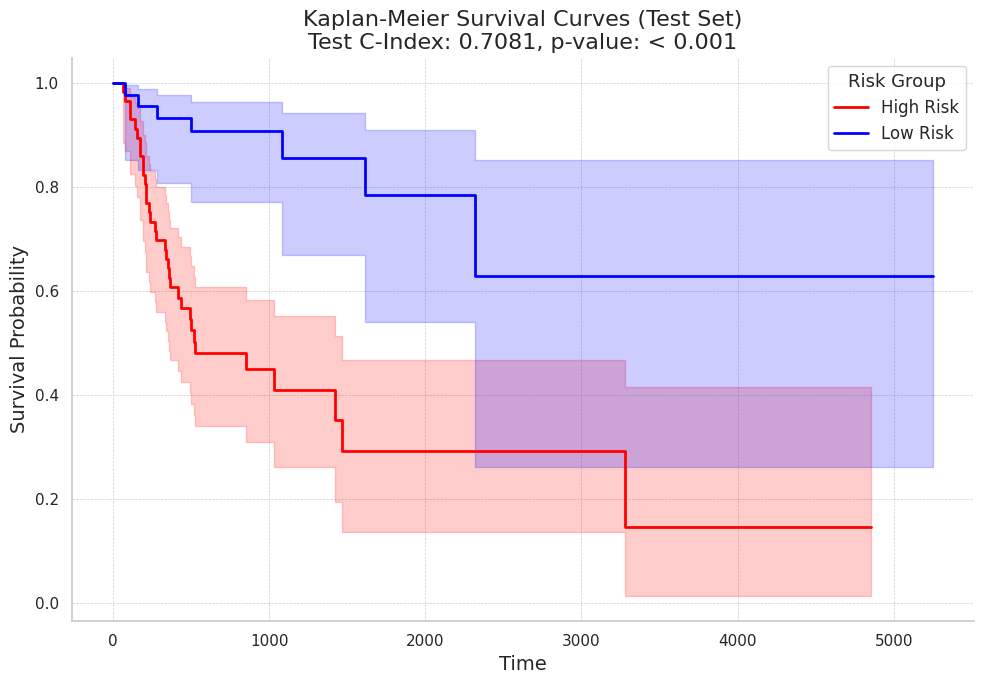

In [32]:
# -------------------------------------------
# Additional Imports Needed
# -------------------------------------------
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# -------------------------------------------
# Optimal Threshold Selection and Kaplan-Meier Plotting for Test Set
# -------------------------------------------

print("\nOptimal Threshold Selection and Kaplan-Meier Plotting for Test Set with Group Size Restriction...\n")

# Prepare data
risk_scores_test = risk_test  # Risk scores from the model on test set
durations_test = durations_test  # Durations on test set
events_test = events_test.astype(bool)  # Events on test set

# Use negative risk scores for proper ordering in concordance index calculation
# This is consistent with your base script
c_index_test = concordance_index_censored(
    events_test,
    durations_test,
    -risk_scores_test  # Use negative risk scores
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# Search for the optimal threshold
unique_risk_scores_test = np.sort(np.unique(risk_scores_test))

# Initialize variables
best_threshold_test = None
min_p_value_test = 1.0

# Minimum group size (at least 25% of patients in each group)
total_patients = len(risk_scores_test)
min_group_size = total_patients * 0.25

# For each possible threshold, compute the log-rank test p-value
for threshold in unique_risk_scores_test[1:-1]:
    # Assign patients to groups
    is_high_risk = risk_scores_test <= threshold  # High risk have lower risk scores
    is_low_risk = risk_scores_test > threshold

    # Calculate group sizes
    group_high_size = is_high_risk.sum()
    group_low_size = is_low_risk.sum()

    # Ensure each group has at least the minimum number of patients
    if group_high_size < min_group_size or group_low_size < min_group_size:
        continue  # Skip thresholds that result in small groups

    # Check if both groups have events
    if events_test[is_high_risk].sum() == 0 or events_test[is_low_risk].sum() == 0:
        continue  # Skip thresholds where one group has no events

    # Perform log-rank test
    results_test = logrank_test(
        durations_test[is_high_risk],
        durations_test[is_low_risk],
        event_observed_A=events_test[is_high_risk],
        event_observed_B=events_test[is_low_risk]
    )
    p_value_test = results_test.p_value

    # Update the best threshold if p-value is lower
    if p_value_test < min_p_value_test:
        min_p_value_test = p_value_test
        best_threshold_test = threshold

# Check if a valid threshold was found
if best_threshold_test is None:
    print("No valid threshold found that satisfies the group size restriction.")
else:
    # Assign patients to groups based on the best threshold
    is_high_risk = risk_scores_test <= best_threshold_test  # High risk have lower risk scores
    is_low_risk = risk_scores_test > best_threshold_test

    # Confirm that the high-risk group has shorter survival times
    median_survival_high = np.median(durations_test[is_high_risk])
    median_survival_low = np.median(durations_test[is_low_risk])

    print(f"Median survival time - High Risk: {median_survival_high}")
    print(f"Median survival time - Low Risk: {median_survival_low}")

    # Ensure high-risk group has shorter survival times
    if median_survival_high >= median_survival_low:
        print("Warning: High-risk group does not have shorter median survival time compared to low-risk group.")
        # You may choose to investigate further or adjust the thresholding method

    print(f"Optimal threshold for risk score on test set: {best_threshold_test:.4f}")

    # Format p-value as per your request
    if min_p_value_test < 0.001:
        p_value_formatted = "< 0.001"
    else:
        p_value_formatted = f"{min_p_value_test:.3f}"
    print(f"Minimum p-value from log-rank test on test set: {p_value_formatted}")

    # Create a DataFrame for plotting
    test_data = pd.DataFrame({
        'duration': durations_test,
        'event': events_test,
        'group': np.where(is_high_risk, 'High Risk', 'Low Risk')
    })

    # Kaplan-Meier fitting and plotting using Seaborn
    kmf_high_test = KaplanMeierFitter()
    kmf_low_test = KaplanMeierFitter()

    plt.figure(figsize=(10, 7))

    # Fit the models
    kmf_high_test.fit(
        test_data['duration'][test_data['group'] == 'High Risk'],
        event_observed=test_data['event'][test_data['group'] == 'High Risk'],
        label='High Risk'
    )
    kmf_low_test.fit(
        test_data['duration'][test_data['group'] == 'Low Risk'],
        event_observed=test_data['event'][test_data['group'] == 'Low Risk'],
        label='Low Risk'
    )

    # Plot the survival curves with confidence intervals (error bands)
    ax = kmf_high_test.plot(ci_show=True, ci_alpha=0.2, linewidth=2, color='red')
    kmf_low_test.plot(ax=ax, ci_show=True, ci_alpha=0.2, linewidth=2, color='blue')

    # Customize the plot using Seaborn aesthetics
    sns.despine()

    # Add c-index and p-value to the plot
    plt.title('Kaplan-Meier Survival Curves (Test Set)\nTest C-Index: {:.4f}, p-value: {}'.format(c_index_test, p_value_formatted), fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Survival Probability', fontsize=14)
    plt.legend(title='Risk Group', fontsize=12, title_fontsize=13)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


CHECKING FOR BEST PERFORMING VARIABLES

Total rows BEFORE: 528
Total rows AFTER: 450
0      62.521561
1      59.299110
2      54.636550
3      63.477070
5      77.344285
         ...    
522    75.857632
524    77.935661
525    56.019165
526    58.710472
527    51.247091
Name: age_of_patient, Length: 450, dtype: float64
patient.lymphnodes_ratio_positive_by_ihc                                  1.059391
patient.lymphnodes_ratio_positive_by_he                                   0.918626
age_of_patient                                                           -0.659876
patient.tobacco_smoking_history                                          -0.296069
patient.year_of_tobacco_smoking_onset                                     0.957086
patient.number_pack_years_smoked                                          1.394549
patient.stopped_smoking_year                                             -0.728405
patient.frequency_of_alcohol_consumption                                  1.740079
patient.amount_of_alcohol_consumption_per_day         

Computing permutation importance: 100%|██████████| 38/38 [05:21<00:00,  8.45s/it]



Total number of features in importance DataFrame: 38

Feature Importances (Permutation Importance with Uncertainty):
                                              Feature  Mean Decrease  \
13  patient.presence_of_pathological_nodal_extraca...       0.067552   
36               patient.stage_event.pathologic_stage       0.023719   
34  patient.stage_event.tnm_categories.pathologic_...       0.023008   
23                                         HPV.status       0.015465   
6               patient.anatomic_neoplasm_subdivision       0.011717   
27                    patient.tobacco_smoking_history       0.008207   
14            patient.lymphovascular_invasion_present       0.006404   
37                                           HPV load       0.004839   
16                  patient.neoplasm_histologic_grade       0.004507   
0                           patient.histological_type       0.003890   
33  patient.stage_event.tnm_categories.pathologic_...       0.003748   
3                 

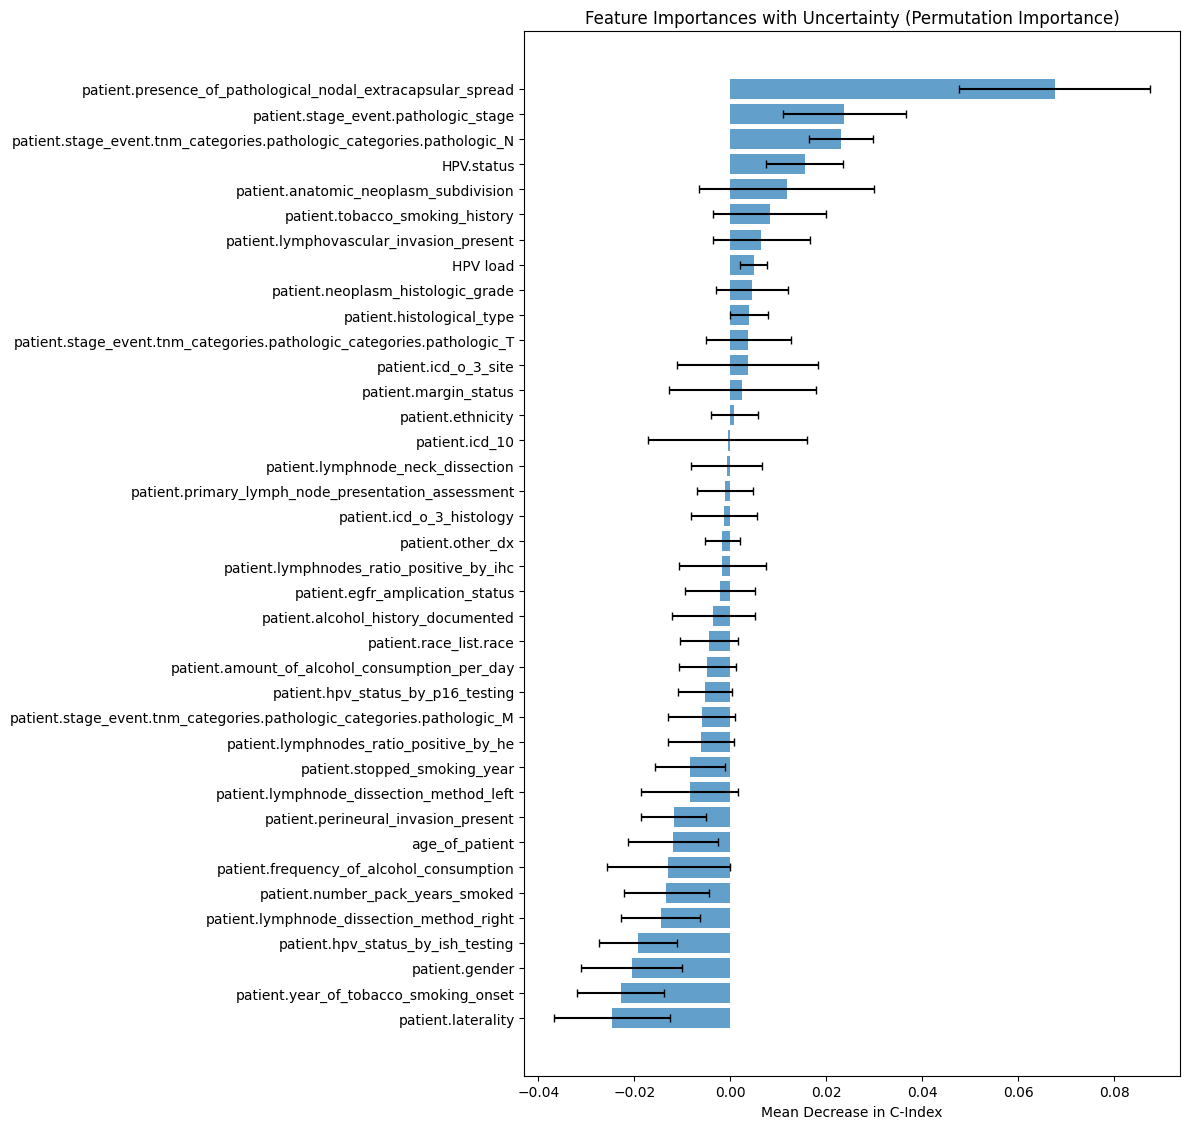

In [37]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes' is your input DataFrame
clinical_data_test = clinical_data_yes_id.copy()

# Path to the JSON file containing survival data (assumed to contain WSI embeddings)
json_path = 'svs_patient_map_PFI.json'  # Replace with your actual path if different

# Check if JSON file exists
if not os.path.exists(json_path):
    raise FileNotFoundError(f"The JSON file '{json_path}' was not found.")

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
wsi_df = pd.DataFrame(survival_entries)

# Verify that 'file_name' column exists
if 'file_name' not in wsi_df.columns:
    raise KeyError("'file_name' column not found in the JSON data.")

# Extract 'patient.bcr_patient_barcode' by taking the first 12 characters of 'file_name'
def extract_barcode(file_name):
    """
    Extracts the 'patient.bcr_patient_barcode' from the 'file_name'.
    Assumes that 'file_name' starts with the barcode, e.g., 'TCGA-UF-A71E_flatten.pt'
    """
    return file_name[:12]

wsi_df['patient.bcr_patient_barcode'] = wsi_df['file_name'].apply(extract_barcode)

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
wsi_df['patient.bcr_patient_barcode'] = wsi_df['patient.bcr_patient_barcode'].astype(str)

# Adjust the filtering condition based on your actual data structure
wsi_df = wsi_df[wsi_df['file_name'].str.contains('DX1', case=False, na=False)].reset_index(drop=True)
# Store the initial row count of clinical_data_test
initial_row_count = clinical_data_test.shape[0]

# Filter clinical_data_test to keep only rows where "patient.bcr_patient_barcode" values exist in wsi_df
clinical_data_test_filtered = clinical_data_test[
    clinical_data_test["patient.bcr_patient_barcode"].isin(wsi_df["patient.bcr_patient_barcode"])
]




clinical_data_test = clinical_data_test_filtered
clinical_data_test = clinical_data_test.drop(columns=['patient.bcr_patient_barcode'])

# Store the final row count after filtering
final_row_count = clinical_data_test.shape[0]

# Print the results
print("Total rows BEFORE:", initial_row_count)
print("Total rows AFTER:", final_row_count)

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

#clinical_data_test['HPV.status'] = clinical_data_test['HPV.status'].replace({'positive': 1, 'negative': 0})

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

print(clinical_data_test['age_of_patient'])




# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'age_of_patient',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage',
    'HPV load'

]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'HPV load'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Prepare Survival Data
# -------------------------------------------

# Fill NaN values in 'PFI.time' with the mean
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)

# Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

time_copy = time.copy()
event_copy = event.copy()

# -------------------------------------------
# Feature Engineering
# -------------------------------------------

# Scale numerical features
scaler = StandardScaler()
scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

# Convert scaled numerical features back to DataFrame for compatibility
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

# Combine scaled numerical features and categorical features into a single DataFrame
X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

print(X.iloc[42])

X_copy = X.copy()
# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, event))
X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
y_train_event, y_test_event = event[train_idx], event[test_idx]
y_train_time, y_test_time = time[train_idx], time[test_idx]

# -------------------------------------------
# Preparing Data for FTTransformer
# -------------------------------------------

# Identify numerical and categorical columns after preprocessing
categorical_columns = list(categorical_cols)
numerical_columns = num_cols

# Prepare data for FTTransformer
def prepare_data(X, categorical_columns, numerical_columns):
    # For categorical features
    cat_features = X[categorical_columns]
    # For numerical features
    num_features = X[numerical_columns]
    return cat_features, num_features

X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

# -------------------------------------------
# Convert Data to PyTorch Tensors
# -------------------------------------------

# Convert data to torch tensors
def to_tensor(x, dtype):
    return torch.tensor(x.values, dtype=dtype)

X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
X_train_num_tensor = to_tensor(X_train_num, torch.float32)
X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
X_test_num_tensor = to_tensor(X_test_num, torch.float32)

# -------------------------------------------
# Initialize FTTransformer (Pretrained)
# -------------------------------------------

# Get the number of unique categories for each categorical column
categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

# Instantiate the FTTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ft_transformer = FTTransformer(
    categories=categories,                              # List of unique category counts
    num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
    dim=192,                                            # Embedding dimension size, adjust as needed
    depth=6,                                            # Number of transformer layers
    heads=8,                                            # Number of attention heads
    attn_dropout=0.1,                                   # Dropout for attention layers
    ff_dropout=0.1                                      # Dropout for feedforward layers
).to(device)

# Load pretrained weights if available
# Uncomment and modify the following line if you have pretrained weights
# ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

# Set the model to evaluation mode
ft_transformer.eval()

# -------------------------------------------
# Generating Embeddings
# -------------------------------------------

def get_embeddings(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
        numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
        embeddings = model(categorical, numerical, return_embedding=True)
        return embeddings.cpu().numpy()

# Generate embeddings for training and test sets
train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

# Verify the shape of the embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Initialize the MLPVanilla model with reduced input features 
net = tt.practical.MLPVanilla(
    in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
    num_nodes=num_nodes,
    out_features=out_features,
    batch_norm=batch_norm,
    dropout=dropout,
    output_bias=output_bias
)

# Initialize the CoxPH model with the network and optimizer
optimizer = tt.optim.Adam(lr=1e-3)
cox_ph = CoxPH(net, optimizer)

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
durations_train = y_train_time.astype(np.float32)
events_train = y_train_event.astype(np.int64)

# Ensure embeddings are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = train_embeddings[train_idx_cv]
    y_train_cv_durations = durations_train[train_idx_cv]
    y_train_cv_events = events_train[train_idx_cv]
    
    X_val_cv = train_embeddings[val_idx_cv]
    y_val_cv_durations = durations_train[val_idx_cv]
    y_val_cv_events = events_train[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
    
    # Initialize a new instance of the network for each fold to avoid weight sharing
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    c_index = concordance_index_censored(
        y_val_cv_events.astype(bool),
        y_val_cv_durations,
        -risk_val  # Use negative risk for proper ordering
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("\nTraining Final CoxPH Model on Entire Training Set...\n")

# Ensure arrays are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)
durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
events_train = np.ascontiguousarray(events_train, dtype=np.int64)

# Fit the final model on the entire training set
cox_ph.fit(
    train_embeddings,
    (events_train, durations_train),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("\nEvaluating on Test Set...\n")

# Prepare test data
durations_test = y_test_time.astype(np.float32)
events_test = y_test_event.astype(np.int64)
test_embeddings = np.ascontiguousarray(test_embeddings, dtype=np.float32)

# Predict risk scores on test set
risk_test = cox_ph.predict(test_embeddings).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    events_test.astype(bool),
    durations_test,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(test_embeddings), size=len(test_embeddings), replace=True)
    X_test_bs = test_embeddings[indices]
    durations_test_bs = durations_test[indices]
    events_test_bs = events_test[indices]
    
    # Predict risk scores
    risk_bs = cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs.astype(bool),
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")

# -------------------------------------------
# Permutation Importance on Test Set with Uncertainty
# -------------------------------------------

print("\nCalculating Permutation Importance on Test Set with Uncertainty...\n")

# Baseline C-Index on Test Set
baseline_c_index = c_index_test
print(f"Baseline C-Index on Test Set: {baseline_c_index:.4f}")

# Combine categorical and numerical columns
all_columns = categorical_columns + numerical_columns

# Print total number of features
print(f"Total number of features to evaluate: {len(all_columns)}")

# Initialize a DataFrame to store feature importances
feature_importances = pd.DataFrame(columns=['Feature', 'Mean Decrease', 'Std Deviation'])

# Number of repeats for permutation
n_repeats = 10  # Adjust as needed for more precision

# Function to compute C-Index after permuting a feature multiple times
def compute_permutation_importance(feature_name, n_repeats=10):
    decreases = []
    for repeat in range(n_repeats):
        # Set a different seed for each repeat for reproducibility
        np.random.seed(seed + repeat)
        
        # Make a copy of the test data
        X_test_cat_perm = X_test_cat.copy()
        X_test_num_perm = X_test_num.copy()
        
        # Permute the feature
        if feature_name in X_test_cat_perm.columns:
            X_test_cat_perm[feature_name] = np.random.permutation(X_test_cat_perm[feature_name].values)
        elif feature_name in X_test_num_perm.columns:
            X_test_num_perm[feature_name] = np.random.permutation(X_test_num_perm[feature_name].values)
        else:
            print(f"Feature '{feature_name}' not found in data.")
            return np.nan, np.nan
        
        # Generate new embeddings
        test_embeddings_perm = get_embeddings(ft_transformer, X_test_cat_perm, X_test_num_perm)
        test_embeddings_perm = np.ascontiguousarray(test_embeddings_perm, dtype=np.float32)
        
        # Predict risk scores with permuted feature
        risk_test_perm = cox_ph.predict(test_embeddings_perm).squeeze()
        
        # Compute new C-Index
        c_index_perm = concordance_index_censored(
            events_test.astype(bool),
            durations_test,
            -risk_test_perm  # Use negative risk for proper ordering
        )[0]
        
        # Compute decrease in C-Index
        decrease_in_c_index = baseline_c_index - c_index_perm
        
        decreases.append(decrease_in_c_index)
    
    # Compute mean and standard deviation
    mean_decrease = np.mean(decreases)
    std_decrease = np.std(decreases)
    
    return mean_decrease, std_decrease

# Loop over all features and compute permutation importance
print("\nStarting permutation importance computation for each feature...\n")
for feature in tqdm(all_columns, desc="Computing permutation importance"):
    mean_decrease, std_decrease = compute_permutation_importance(feature, n_repeats=n_repeats)
    feature_importances = feature_importances.append({
        'Feature': feature,
        'Mean Decrease': mean_decrease,
        'Std Deviation': std_decrease
    }, ignore_index=True)

# Handle any NaN values
feature_importances['Mean Decrease'] = pd.to_numeric(feature_importances['Mean Decrease'], errors='coerce')
feature_importances['Std Deviation'] = pd.to_numeric(feature_importances['Std Deviation'], errors='coerce')
feature_importances.fillna(0, inplace=True)  # Replace NaN with 0

# Reset index and sort features by mean decrease in C-Index
feature_importances.reset_index(drop=True, inplace=True)
feature_importances.sort_values(by='Mean Decrease', ascending=False, inplace=True)

# Print the total number of features in the importance DataFrame
print(f"\nTotal number of features in importance DataFrame: {len(feature_importances)}")

# Display feature importances
print("\nFeature Importances (Permutation Importance with Uncertainty):")
print(feature_importances)

# Visualize the feature importances with error bars
plt.figure(figsize=(12, max(6, 0.3 * len(feature_importances))))
plt.barh(
    feature_importances['Feature'],
    feature_importances['Mean Decrease'],
    xerr=feature_importances['Std Deviation'],
    align='center',
    alpha=0.7,
    ecolor='black',
    capsize=3
)
plt.gca().invert_yaxis()
plt.xlabel('Mean Decrease in C-Index')
plt.title('Feature Importances with Uncertainty (Permutation Importance)')
plt.tight_layout()
plt.show()


now evaluating on cross-validation

In [38]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random
from tqdm import tqdm 
from matplotlib import pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes' is your input DataFrame
clinical_data_test = clinical_data_yes_id.copy()

# Path to the JSON file containing survival data (assumed to contain WSI embeddings)
json_path = 'svs_patient_map_PFI.json'  # Replace with your actual path if different

# Check if JSON file exists
if not os.path.exists(json_path):
    raise FileNotFoundError(f"The JSON file '{json_path}' was not found.")

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
wsi_df = pd.DataFrame(survival_entries)

# Verify that 'file_name' column exists
if 'file_name' not in wsi_df.columns:
    raise KeyError("'file_name' column not found in the JSON data.")

# Extract 'patient.bcr_patient_barcode' by taking the first 12 characters of 'file_name'
def extract_barcode(file_name):
    """
    Extracts the 'patient.bcr_patient_barcode' from the 'file_name'.
    Assumes that 'file_name' starts with the barcode, e.g., 'TCGA-UF-A71E_flatten.pt'
    """
    return file_name[:12]

wsi_df['patient.bcr_patient_barcode'] = wsi_df['file_name'].apply(extract_barcode)

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
wsi_df['patient.bcr_patient_barcode'] = wsi_df['patient.bcr_patient_barcode'].astype(str)

# Adjust the filtering condition based on your actual data structure
wsi_df = wsi_df[wsi_df['file_name'].str.contains('DX1', case=False, na=False)].reset_index(drop=True)
# Store the initial row count of clinical_data_test
initial_row_count = clinical_data_test.shape[0]

# Filter clinical_data_test to keep only rows where "patient.bcr_patient_barcode" values exist in wsi_df
clinical_data_test_filtered = clinical_data_test[
    clinical_data_test["patient.bcr_patient_barcode"].isin(wsi_df["patient.bcr_patient_barcode"])
]




clinical_data_test = clinical_data_test_filtered
clinical_data_test = clinical_data_test.drop(columns=['patient.bcr_patient_barcode'])

# Store the final row count after filtering
final_row_count = clinical_data_test.shape[0]

# Print the results
print("Total rows BEFORE:", initial_row_count)
print("Total rows AFTER:", final_row_count)

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

#clinical_data_test['HPV.status'] = clinical_data_test['HPV.status'].replace({'positive': 1, 'negative': 0})

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

print(clinical_data_test['age_of_patient'])




# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'age_of_patient',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage',
    'HPV load'

]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'HPV load'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Prepare Survival Data
# -------------------------------------------

# Fill NaN values in 'PFI.time' with the mean
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)

# Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

time_copy = time.copy()
event_copy = event.copy()

# -------------------------------------------
# Feature Engineering
# -------------------------------------------

# Scale numerical features
scaler = StandardScaler()
scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

# Convert scaled numerical features back to DataFrame for compatibility
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

# Combine scaled numerical features and categorical features into a single DataFrame
X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

print(X.iloc[42])

X_copy = X.copy()

# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, event))
X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
y_train_event, y_test_event = event[train_idx], event[test_idx]
y_train_time, y_test_time = time[train_idx], time[test_idx]

# -------------------------------------------
# Preparing Data for FTTransformer
# -------------------------------------------

# Identify numerical and categorical columns after preprocessing
categorical_columns = list(categorical_cols)
numerical_columns = num_cols

# Prepare data for FTTransformer
def prepare_data(X, categorical_columns, numerical_columns):
    # For categorical features
    cat_features = X[categorical_columns]
    # For numerical features
    num_features = X[numerical_columns]
    return cat_features, num_features

X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

# -------------------------------------------
# Convert Data to PyTorch Tensors
# -------------------------------------------

# Convert data to torch tensors
def to_tensor(x, dtype):
    return torch.tensor(x.values, dtype=dtype)

X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
X_train_num_tensor = to_tensor(X_train_num, torch.float32)
X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
X_test_num_tensor = to_tensor(X_test_num, torch.float32)

# -------------------------------------------
# Initialize FTTransformer (Pretrained)
# -------------------------------------------

# Get the number of unique categories for each categorical column
categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

# Instantiate the FTTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ft_transformer = FTTransformer(
    categories=categories,                              # List of unique category counts
    num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
    dim=192,                                            # Embedding dimension size, adjust as needed
    depth=6,                                            # Number of transformer layers
    heads=8,                                            # Number of attention heads
    attn_dropout=0.1,                                   # Dropout for attention layers
    ff_dropout=0.1                                      # Dropout for feedforward layers
).to(device)

# Load pretrained weights if available
# Uncomment and modify the following line if you have pretrained weights
# ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

# Set the model to evaluation mode
ft_transformer.eval()

# -------------------------------------------
# Generating Embeddings
# -------------------------------------------

def get_embeddings(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
        numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
        embeddings = model(categorical, numerical, return_embedding=True)
        return embeddings.cpu().numpy()

# Generate embeddings for training and test sets
train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

# Verify the shape of the embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Initialize the MLPVanilla model with reduced input features 
net = tt.practical.MLPVanilla(
    in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
    num_nodes=num_nodes,
    out_features=out_features,
    batch_norm=batch_norm,
    dropout=dropout,
    output_bias=output_bias
)

# Initialize the CoxPH model with the network and optimizer
optimizer = tt.optim.Adam(lr=1e-3)
cox_ph = CoxPH(net, optimizer)

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
durations_train = y_train_time.astype(np.float32)
events_train = y_train_event.astype(np.int64)

# Ensure embeddings are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

# Combine categorical and numerical columns
all_columns = categorical_columns + numerical_columns

# Initialize a DataFrame to store feature importances
feature_importances = pd.DataFrame(columns=['Feature', 'Mean Decrease', 'Std Deviation'])

# Number of repeats for permutation
n_repeats = 5  # Adjust as needed for more precision

print("\nStarting 5-Fold Cross-Validation with Permutation Importance...\n")

# Loop to collect importance across folds
feature_importance_list = []

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = train_embeddings[train_idx_cv]
    y_train_cv_durations = durations_train[train_idx_cv]
    y_train_cv_events = events_train[train_idx_cv]
    
    X_val_cv = train_embeddings[val_idx_cv]
    y_val_cv_durations = durations_train[val_idx_cv]
    y_val_cv_events = events_train[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
    
    # Initialize a new instance of the network for each fold to avoid weight sharing
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute Baseline C-Index on Validation Set
    baseline_c_index = concordance_index_censored(
        y_val_cv_events.astype(bool),
        y_val_cv_durations,
        -risk_val  # Use negative risk for proper ordering
    )[0]
    
    print(f"Fold {fold + 1} Baseline C-Index: {baseline_c_index:.4f}")
    
    # Prepare validation data for permutation importance
    # Get corresponding X_val_cat and X_val_num
    X_train_cat_cv = X_train_cat.iloc[train_idx_cv]
    X_train_num_cv = X_train_num.iloc[train_idx_cv]
    X_val_cat_cv = X_train_cat.iloc[val_idx_cv]
    X_val_num_cv = X_train_num.iloc[val_idx_cv]
    
    # Initialize a DataFrame to store feature importances for this fold
    fold_feature_importances = pd.DataFrame(columns=['Feature', 'Mean Decrease', 'Std Deviation'])
    
    # Function to compute permutation importance on validation set
    def compute_permutation_importance_cv(feature_name, n_repeats=5):
        decreases = []
        for repeat in range(n_repeats):
            # Set a different seed for each repeat for reproducibility
            np.random.seed(seed + fold * n_repeats + repeat)
            
            # Make a copy of the validation data
            X_val_cat_perm = X_val_cat_cv.copy()
            X_val_num_perm = X_val_num_cv.copy()
            
            # Permute the feature
            if feature_name in X_val_cat_perm.columns:
                X_val_cat_perm[feature_name] = np.random.permutation(X_val_cat_perm[feature_name].values)
            elif feature_name in X_val_num_perm.columns:
                X_val_num_perm[feature_name] = np.random.permutation(X_val_num_perm[feature_name].values)
            else:
                print(f"Feature '{feature_name}' not found in data.")
                return np.nan, np.nan
            
            # Generate new embeddings
            val_embeddings_perm = get_embeddings(ft_transformer, X_val_cat_perm, X_val_num_perm)
            val_embeddings_perm = np.ascontiguousarray(val_embeddings_perm, dtype=np.float32)
            
            # Predict risk scores with permuted feature
            risk_val_perm = cox_ph_cv.predict(val_embeddings_perm).squeeze()
            
            # Compute new C-Index
            c_index_perm = concordance_index_censored(
                y_val_cv_events.astype(bool),
                y_val_cv_durations,
                -risk_val_perm  # Use negative risk for proper ordering
            )[0]
            
            # Compute decrease in C-Index
            decrease_in_c_index = baseline_c_index - c_index_perm
            
            decreases.append(decrease_in_c_index)
        
        # Compute mean and standard deviation
        mean_decrease = np.mean(decreases)
        std_decrease = np.std(decreases)
        
        return mean_decrease, std_decrease
    
    # Loop over all features and compute permutation importance
    print(f"\nComputing permutation importance for Fold {fold + 1}...\n")
    for feature in tqdm(all_columns, desc=f"Fold {fold + 1}"):
        mean_decrease, std_decrease = compute_permutation_importance_cv(feature, n_repeats=n_repeats)
        fold_feature_importances = fold_feature_importances.append({
            'Feature': feature,
            'Mean Decrease': mean_decrease,
            'Std Deviation': std_decrease
        }, ignore_index=True)
    
    # Append fold results to the list
    feature_importance_list.append(fold_feature_importances)
    
    print(f"\nCompleted permutation importance for Fold {fold + 1}.\n")

# Aggregate feature importances across folds
all_importances = pd.concat(feature_importance_list)
grouped_importances = all_importances.groupby('Feature').agg({
    'Mean Decrease': 'mean',
    'Std Deviation': 'mean'  # You might want to compute overall std differently
}).reset_index()

# Handle any NaN values
grouped_importances['Mean Decrease'] = pd.to_numeric(grouped_importances['Mean Decrease'], errors='coerce')
grouped_importances['Std Deviation'] = pd.to_numeric(grouped_importances['Std Deviation'], errors='coerce')
grouped_importances.fillna(0, inplace=True)  # Replace NaN with 0

# Reset index and sort features by mean decrease in C-Index
grouped_importances.sort_values(by='Mean Decrease', ascending=False, inplace=True)

# Print the total number of features in the importance DataFrame
print(f"\nTotal number of features in importance DataFrame: {len(grouped_importances)}")

# Display feature importances
print("\nFeature Importances (Permutation Importance with Uncertainty based on Cross-Validation):")
print(grouped_importances)

# Visualize the feature importances with error bars
plt.figure(figsize=(12, max(6, 0.3 * len(grouped_importances))))
plt.barh(
    grouped_importances['Feature'],
    grouped_importances['Mean Decrease'],
    xerr=grouped_importances['Std Deviation'],
    align='center',
    alpha=0.7,
    ecolor='black',
    capsize=3
)
plt.gca().invert_yaxis()
plt.xlabel('Mean Decrease in C-Index')
plt.title('Feature Importances with Uncertainty (Permutation Importance based on Cross-Validation)')
plt.tight_layout()
plt.show()


Total rows BEFORE: 528
Total rows AFTER: 450
0      62.521561
1      59.299110
2      54.636550
3      63.477070
5      77.344285
         ...    
522    75.857632
524    77.935661
525    56.019165
526    58.710472
527    51.247091
Name: age_of_patient, Length: 450, dtype: float64
patient.lymphnodes_ratio_positive_by_ihc                                  1.059391
patient.lymphnodes_ratio_positive_by_he                                   0.918626
age_of_patient                                                           -0.659876
patient.tobacco_smoking_history                                          -0.296069
patient.year_of_tobacco_smoking_onset                                     0.957086
patient.number_pack_years_smoked                                          1.394549
patient.stopped_smoking_year                                             -0.728405
patient.frequency_of_alcohol_consumption                                  1.740079
patient.amount_of_alcohol_consumption_per_day         

Fold 1: 100%|██████████| 38/38 [02:35<00:00,  4.09s/it]



Completed permutation importance for Fold 1.

Fold 2
Fold 2 Baseline C-Index: 0.6101

Computing permutation importance for Fold 2...



Fold 2: 100%|██████████| 38/38 [03:26<00:00,  5.43s/it]



Completed permutation importance for Fold 2.

Fold 3
Fold 3 Baseline C-Index: 0.5033

Computing permutation importance for Fold 3...



Fold 3:  66%|██████▌   | 25/38 [01:08<00:35,  2.74s/it]


KeyboardInterrupt: 

Leave one out strategy

0      62.521561
1      59.299110
2      54.636550
3      63.477070
4      38.694045
         ...    
523    45.360712
524    77.935661
525    56.019165
526    58.710472
527    51.247091
Name: age_of_patient, Length: 528, dtype: float64
patient.lymphnodes_ratio_positive_by_ihc                                  1.201689
patient.lymphnodes_ratio_positive_by_he                                   1.059172
age_of_patient                                                            1.429534
patient.tobacco_smoking_history                                           1.307350
patient.year_of_tobacco_smoking_onset                                    -1.070625
patient.number_pack_years_smoked                                          1.269487
patient.stopped_smoking_year                                              1.360174
patient.frequency_of_alcohol_consumption                                 -0.362455
patient.amount_of_alcohol_consumption_per_day                            -0.224637
patient.stage_ev

Train Embeddings Shape: (422, 192)
Test Embeddings Shape: (106, 192)

Starting 5-Fold Cross-Validation...

Fold 1
Fold 1 C-Index: 0.6269

Fold 2
Fold 2 C-Index: 0.6792

Fold 3
Fold 3 C-Index: 0.6051

Fold 4
Fold 4 C-Index: 0.6869

Fold 5
Fold 5 C-Index: 0.6051

Cross-Validation C-Index: 0.6406 ± 0.0356
95% Confidence Interval: [0.6051, 0.6861]

Training Final CoxPH Model on Entire Training Set...

Final CoxPH Model Trained Successfully.

Evaluating on Test Set...

Test C-Index: 0.6963

Starting Bootstrapping for Test C-Index Uncertainty...

Bootstrap 100/1000 completed.
Bootstrap 200/1000 completed.
Bootstrap 300/1000 completed.
Bootstrap 400/1000 completed.
Bootstrap 500/1000 completed.
Bootstrap 600/1000 completed.
Bootstrap 700/1000 completed.
Bootstrap 800/1000 completed.
Bootstrap 900/1000 completed.
Bootstrap 1000/1000 completed.

Test C-Index with Bootstrapping: 0.6959 ± 0.0467
95% Confidence Interval: [0.6067, 0.7855]

Starting Leave-One-Out Feature Importance Analysis...

Base

Computing LOO importance:   0%|          | 0/38 [00:00<?, ?it/s]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:   3%|▎         | 1/38 [02:22<1:27:40, 142.17s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:   5%|▌         | 2/38 [04:46<1:26:01, 143.37s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:   8%|▊         | 3/38 [07:06<1:22:49, 141.97s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  11%|█         | 4/38 [09:28<1:20:27, 141.98s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  13%|█▎        | 5/38 [11:55<1:19:07, 143.86s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  16%|█▌        | 6/38 [14:20<1:16:48, 144.01s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  18%|█▊        | 7/38 [16:36<1:13:11, 141.65s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  21%|██        | 8/38 [18:59<1:11:01, 142.05s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  24%|██▎       | 9/38 [21:26<1:09:18, 143.38s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  26%|██▋       | 10/38 [23:53<1:07:25, 144.48s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  29%|██▉       | 11/38 [26:17<1:04:59, 144.44s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  32%|███▏      | 12/38 [28:39<1:02:14, 143.64s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  34%|███▍      | 13/38 [30:57<59:13, 142.12s/it]  

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  37%|███▋      | 14/38 [33:16<56:26, 141.12s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  39%|███▉      | 15/38 [35:31<53:24, 139.33s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  42%|████▏     | 16/38 [38:00<52:04, 142.03s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  45%|████▍     | 17/38 [39:53<46:41, 133.42s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  47%|████▋     | 18/38 [41:57<43:32, 130.61s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  50%|█████     | 19/38 [44:13<41:51, 132.21s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  53%|█████▎    | 20/38 [46:28<39:54, 133.03s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  55%|█████▌    | 21/38 [48:47<38:09, 134.68s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  58%|█████▊    | 22/38 [51:08<36:25, 136.61s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  61%|██████    | 23/38 [53:35<34:58, 139.89s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  63%|██████▎   | 24/38 [55:57<32:46, 140.48s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  66%|██████▌   | 25/38 [58:16<30:21, 140.13s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  68%|██████▊   | 26/38 [1:00:42<28:20, 141.74s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  71%|███████   | 27/38 [1:03:07<26:10, 142.78s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  74%|███████▎  | 28/38 [1:05:29<23:46, 142.67s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  76%|███████▋  | 29/38 [1:07:51<21:19, 142.22s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  79%|███████▉  | 30/38 [1:10:12<18:56, 142.04s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  82%|████████▏ | 31/38 [1:12:36<16:38, 142.60s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  84%|████████▍ | 32/38 [1:14:59<14:16, 142.78s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  87%|████████▋ | 33/38 [1:17:24<11:57, 143.48s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  89%|████████▉ | 34/38 [1:20:05<09:54, 148.61s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  92%|█████████▏| 35/38 [1:22:24<07:17, 145.76s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  95%|█████████▍| 36/38 [1:24:45<04:48, 144.21s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance:  97%|█████████▋| 37/38 [1:27:33<02:31, 151.47s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Computing LOO importance: 100%|██████████| 38/38 [1:29:58<00:00, 142.07s/it]



Total number of features in LOO importance DataFrame: 38

Feature Importances (Leave-One-Out Importance with Uncertainty):
                                              Feature  Mean Decrease  \
13  patient.presence_of_pathological_nodal_extraca...       0.106830   
12                              patient.margin_status       0.084472   
17                 patient.alcohol_history_documented       0.082638   
34  patient.stage_event.tnm_categories.pathologic_...       0.081884   
6               patient.anatomic_neoplasm_subdivision       0.079403   
15                patient.perineural_invasion_present       0.076707   
32      patient.amount_of_alcohol_consumption_per_day       0.075377   
0                           patient.histological_type       0.075162   
23                                         HPV.status       0.075054   
30                       patient.stopped_smoking_year       0.074299   
24           patient.lymphnodes_ratio_positive_by_ihc       0.073221   
16          

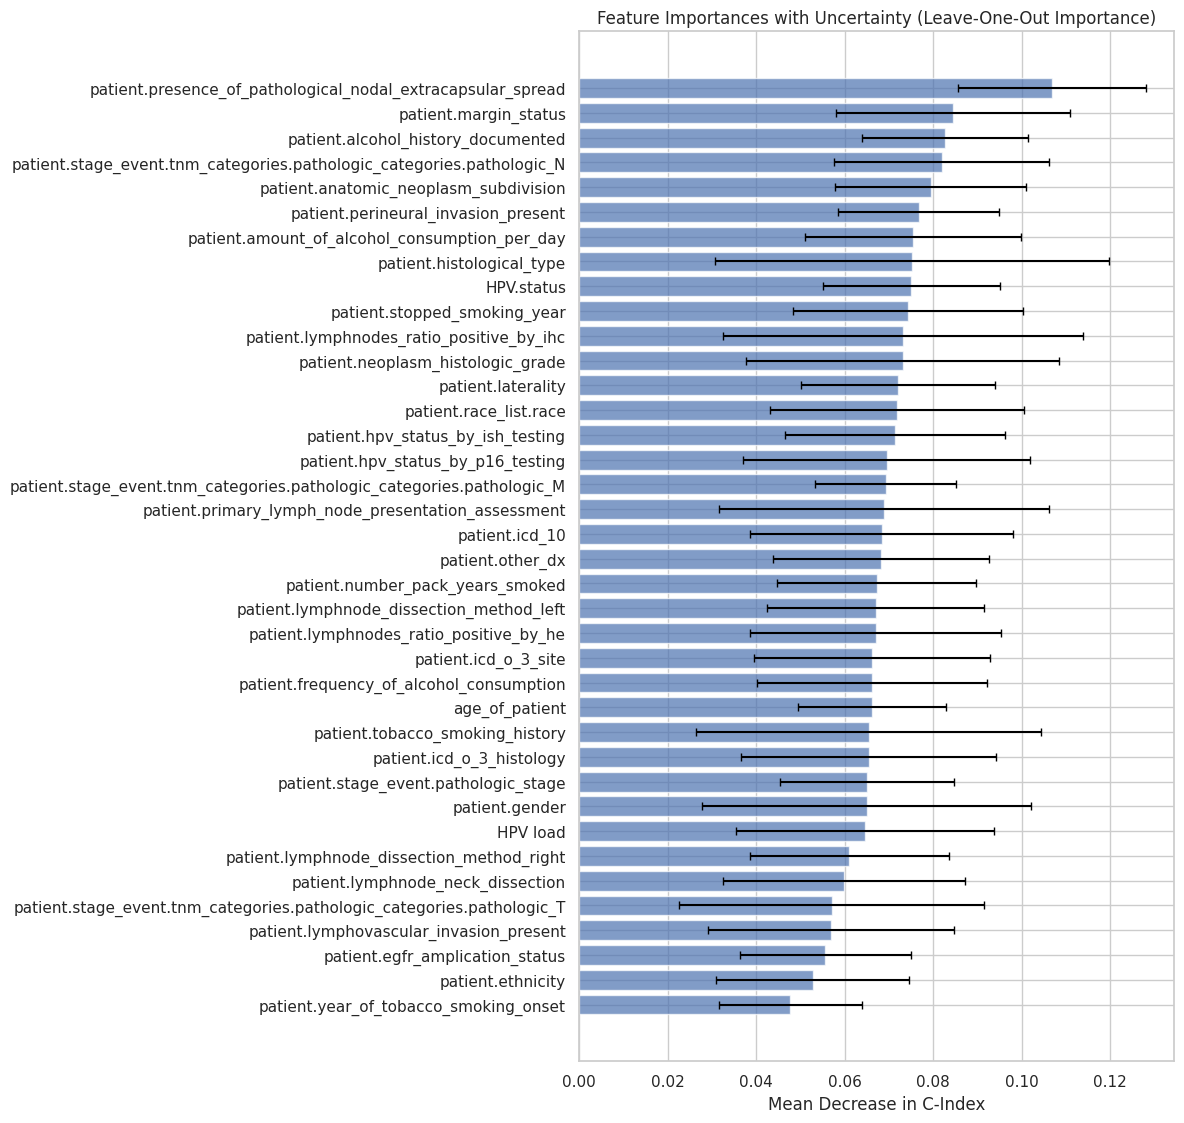

In [65]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes' is your input DataFrame
clinical_data_test = clinical_data_yes.copy()

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

#clinical_data_test['HPV.status'] = clinical_data_test['HPV.status'].replace({'positive': 1, 'negative': 0})

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

print(clinical_data_test['age_of_patient'])




# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'age_of_patient',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage',
    'HPV load'

]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'HPV load'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Prepare Survival Data
# -------------------------------------------

# Fill NaN values in 'PFI.time' with the mean
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)

# Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

time_copy = time.copy()
event_copy = event.copy()

# -------------------------------------------
# Feature Engineering
# -------------------------------------------

# Scale numerical features
scaler = StandardScaler()
scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

# Convert scaled numerical features back to DataFrame for compatibility
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

# Combine scaled numerical features and categorical features into a single DataFrame
X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

print(X.iloc[42])

X_copy = X.copy()

# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, event))
X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
y_train_event, y_test_event = event[train_idx], event[test_idx]
y_train_time, y_test_time = time[train_idx], time[test_idx]

# -------------------------------------------
# Preparing Data for FTTransformer
# -------------------------------------------

# Identify numerical and categorical columns after preprocessing
categorical_columns = list(categorical_cols)
numerical_columns = num_cols

# Prepare data for FTTransformer
def prepare_data(X, categorical_columns, numerical_columns):
    # For categorical features
    cat_features = X[categorical_columns]
    # For numerical features
    num_features = X[numerical_columns]
    return cat_features, num_features

X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

# -------------------------------------------
# Convert Data to PyTorch Tensors
# -------------------------------------------

# Convert data to torch tensors
def to_tensor(x, dtype):
    return torch.tensor(x.values, dtype=dtype)

X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
X_train_num_tensor = to_tensor(X_train_num, torch.float32)
X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
X_test_num_tensor = to_tensor(X_test_num, torch.float32)

# -------------------------------------------
# Initialize FTTransformer (Pretrained)
# -------------------------------------------

# Get the number of unique categories for each categorical column
categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

# Instantiate the FTTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ft_transformer = FTTransformer(
    categories=categories,                              # List of unique category counts
    num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
    dim=192,                                            # Embedding dimension size, adjust as needed
    depth=6,                                            # Number of transformer layers
    heads=8,                                            # Number of attention heads
    attn_dropout=0.1,                                   # Dropout for attention layers
    ff_dropout=0.1                                      # Dropout for feedforward layers
).to(device)

# Load pretrained weights if available
# Uncomment and modify the following line if you have pretrained weights
# ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

# Set the model to evaluation mode
ft_transformer.eval()

# -------------------------------------------
# Generating Embeddings
# -------------------------------------------

def get_embeddings(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
        numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
        embeddings = model(categorical, numerical, return_embedding=True)
        return embeddings.cpu().numpy()

# Generate embeddings for training and test sets
train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

# Verify the shape of the embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Initialize the MLPVanilla model with reduced input features 
net = tt.practical.MLPVanilla(
    in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
    num_nodes=num_nodes,
    out_features=out_features,
    batch_norm=batch_norm,
    dropout=dropout,
    output_bias=output_bias
)

# Initialize the CoxPH model with the network and optimizer
optimizer = tt.optim.Adam(lr=1e-3)
cox_ph = CoxPH(net, optimizer)

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
durations_train = y_train_time.astype(np.float32)
events_train = y_train_event.astype(np.int64)

# Ensure embeddings are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = train_embeddings[train_idx_cv]
    y_train_cv_durations = durations_train[train_idx_cv]
    y_train_cv_events = events_train[train_idx_cv]
    
    X_val_cv = train_embeddings[val_idx_cv]
    y_val_cv_durations = durations_train[val_idx_cv]
    y_val_cv_events = events_train[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
    
    # Initialize a new instance of the network for each fold to avoid weight sharing
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    c_index = concordance_index_censored(
        y_val_cv_events.astype(bool),
        y_val_cv_durations,
        -risk_val  # Use negative risk for proper ordering
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("\nTraining Final CoxPH Model on Entire Training Set...\n")

# Ensure arrays are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)
durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
events_train = np.ascontiguousarray(events_train, dtype=np.int64)

# Fit the final model on the entire training set
cox_ph.fit(
    train_embeddings,
    (events_train, durations_train),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("\nEvaluating on Test Set...\n")

# Prepare test data
durations_test = y_test_time.astype(np.float32)
events_test = y_test_event.astype(np.int64)
test_embeddings = np.ascontiguousarray(test_embeddings, dtype=np.float32)

# Predict risk scores on test set
risk_test = cox_ph.predict(test_embeddings).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    events_test.astype(bool),
    durations_test,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(test_embeddings), size=len(test_embeddings), replace=True)
    X_test_bs = test_embeddings[indices]
    durations_test_bs = durations_test[indices]
    events_test_bs = events_test[indices]
    
    # Predict risk scores
    risk_bs = cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs.astype(bool),
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")

# -------------------------------------------
# Leave-One-Out Feature Importance Analysis
# -------------------------------------------

print("\nStarting Leave-One-Out Feature Importance Analysis...\n")

# Baseline C-Index on Test Set
baseline_c_index = c_index_test
print(f"Baseline Test C-Index: {baseline_c_index:.4f}")

# Combine categorical and numerical columns
all_columns = categorical_columns + numerical_columns

# Initialize a DataFrame to store feature importances
loo_feature_importances = pd.DataFrame(columns=['Feature', 'C-Index Mean', 'C-Index Std'])

# Number of bootstraps for uncertainty estimation
n_bootstraps = 10  # Adjust as needed; more bootstraps increase computation time

# Function to compute C-Index after leaving one feature out
def compute_loo_importance(feature_name):
    c_indices = []
    for i in range(n_bootstraps):
        # Set a different seed for each repeat for reproducibility
        np.random.seed(seed + i)
        
        # Make copies of training data
        X_train_cat_loo = X_train_cat.copy()
        X_train_num_loo = X_train_num.copy()
        
        X_test_cat_loo = X_test_cat.copy()
        X_test_num_loo = X_test_num.copy()
        
        # Drop the feature
        if feature_name in X_train_cat_loo.columns:
            X_train_cat_loo = X_train_cat_loo.drop(columns=[feature_name])
            X_test_cat_loo = X_test_cat_loo.drop(columns=[feature_name])
        elif feature_name in X_train_num_loo.columns:
            X_train_num_loo = X_train_num_loo.drop(columns=[feature_name])
            X_test_num_loo = X_test_num_loo.drop(columns=[feature_name])
        else:
            print(f"Feature '{feature_name}' not found in data.")
            return np.nan, np.nan
        
        # Get number of categories for updated categorical features
        categories_loo = [int(X_train_cat_loo[col].max() + 1) for col in X_train_cat_loo.columns]
        
        # Reinitialize FTTransformer with updated input dimensions
        ft_transformer_loo = FTTransformer(
            categories=categories_loo,
            num_continuous=X_train_num_loo.shape[1],
            dim=192,
            depth=6,
            heads=8,
            attn_dropout=0.1,
            ff_dropout=0.1
        ).to(device)
        ft_transformer_loo.eval()
        
        # Generate embeddings
        train_embeddings_loo = get_embeddings(ft_transformer_loo, X_train_cat_loo, X_train_num_loo)
        test_embeddings_loo = get_embeddings(ft_transformer_loo, X_test_cat_loo, X_test_num_loo)
        
        # Ensure embeddings are contiguous
        train_embeddings_loo = np.ascontiguousarray(train_embeddings_loo, dtype=np.float32)
        test_embeddings_loo = np.ascontiguousarray(test_embeddings_loo, dtype=np.float32)
        
        # Reinitialize the network
        net_loo = tt.practical.MLPVanilla(
            in_features=train_embeddings_loo.shape[1],
            num_nodes=num_nodes,
            out_features=out_features,
            batch_norm=batch_norm,
            dropout=dropout,
            output_bias=output_bias
        )
        
        optimizer_loo = tt.optim.Adam(lr=1e-3)
        cox_ph_loo = CoxPH(net_loo, optimizer_loo)
        
        # Fit the model
        cox_ph_loo.fit(
            train_embeddings_loo,
            (events_train, durations_train),
            batch_size=64,
            epochs=100,
            verbose=False
        )
        
        # Predict risk scores on test set
        risk_test_loo = cox_ph_loo.predict(test_embeddings_loo).squeeze()
        
        # Compute C-Index on Test Set
        c_index_loo = concordance_index_censored(
            events_test.astype(bool),
            durations_test,
            -risk_test_loo  # Use negative risk for proper ordering
        )[0]
        
        c_indices.append(c_index_loo)
    
    # Compute mean and standard deviation
    c_index_mean = np.mean(c_indices)
    c_index_std = np.std(c_indices)
    
    return c_index_mean, c_index_std

# Loop over all features and compute leave-one-out importance
print("\nComputing Leave-One-Out Importance for each feature...\n")
for feature in tqdm(all_columns, desc="Computing LOO importance"):
    c_index_mean, c_index_std = compute_loo_importance(feature)
    loo_feature_importances = loo_feature_importances.append({
        'Feature': feature,
        'C-Index Mean': c_index_mean,
        'C-Index Std': c_index_std
    }, ignore_index=True)

# Compute the change in C-Index compared to the baseline
loo_feature_importances['Mean Decrease'] = baseline_c_index - loo_feature_importances['C-Index Mean']

# Handle any NaN values
loo_feature_importances['Mean Decrease'] = pd.to_numeric(loo_feature_importances['Mean Decrease'], errors='coerce')
loo_feature_importances['C-Index Std'] = pd.to_numeric(loo_feature_importances['C-Index Std'], errors='coerce')
loo_feature_importances.fillna(0, inplace=True)  # Replace NaN with 0

# Reset index and sort features by mean decrease in C-Index
loo_feature_importances.reset_index(drop=True, inplace=True)
loo_feature_importances.sort_values(by='Mean Decrease', ascending=False, inplace=True)

# Print the total number of features in the importance DataFrame
print(f"\nTotal number of features in LOO importance DataFrame: {len(loo_feature_importances)}")

# Display feature importances
print("\nFeature Importances (Leave-One-Out Importance with Uncertainty):")
print(loo_feature_importances[['Feature', 'Mean Decrease', 'C-Index Std']])

# Visualize the feature importances with error bars
plt.figure(figsize=(12, max(6, 0.3 * len(loo_feature_importances))))
plt.barh(
    loo_feature_importances['Feature'],
    loo_feature_importances['Mean Decrease'],
    xerr=loo_feature_importances['C-Index Std'],
    align='center',
    alpha=0.7,
    ecolor='black',
    capsize=3
)
plt.gca().invert_yaxis()
plt.xlabel('Mean Decrease in C-Index')
plt.title('Feature Importances with Uncertainty (Leave-One-Out Importance)')
plt.tight_layout()
plt.show()


LOO on cross-validation:

0      62.521561
1      59.299110
2      54.636550
3      63.477070
4      38.694045
         ...    
523    45.360712
524    77.935661
525    56.019165
526    58.710472
527    51.247091
Name: age_of_patient, Length: 528, dtype: float64
patient.lymphnodes_ratio_positive_by_ihc                                  1.201689
patient.lymphnodes_ratio_positive_by_he                                   1.059172
age_of_patient                                                            1.429534
patient.tobacco_smoking_history                                           1.307350
patient.year_of_tobacco_smoking_onset                                    -1.070625
patient.number_pack_years_smoked                                          1.269487
patient.stopped_smoking_year                                              1.360174
patient.frequency_of_alcohol_consumption                                 -0.362455
patient.amount_of_alcohol_consumption_per_day                            -0.224637
patient.stage_ev

Train Embeddings Shape: (422, 192)
Test Embeddings Shape: (106, 192)

Starting 5-Fold Cross-Validation...

Fold 1
Fold 1 C-Index: 0.6387

Fold 2
Fold 2 C-Index: 0.6642

Fold 3
Fold 3 C-Index: 0.6181

Fold 4
Fold 4 C-Index: 0.6559

Fold 5
Fold 5 C-Index: 0.5972

Cross-Validation C-Index: 0.6348 ± 0.0246
95% Confidence Interval: [0.5993, 0.6633]

Training Final CoxPH Model on Entire Training Set...

Final CoxPH Model Trained Successfully.

Evaluating on Test Set...

Test C-Index: 0.6891

Starting Bootstrapping for Test C-Index Uncertainty...

Bootstrap 100/1000 completed.
Bootstrap 200/1000 completed.
Bootstrap 300/1000 completed.
Bootstrap 400/1000 completed.
Bootstrap 500/1000 completed.
Bootstrap 600/1000 completed.
Bootstrap 700/1000 completed.
Bootstrap 800/1000 completed.
Bootstrap 900/1000 completed.
Bootstrap 1000/1000 completed.

Test C-Index with Bootstrapping: 0.6890 ± 0.0478
95% Confidence Interval: [0.5954, 0.7805]

Starting Leave-One-Out Feature Importance Analysis based on

Fold 1 LOO:   0%|          | 0/38 [00:00<?, ?it/s]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:   3%|▎         | 1/38 [00:55<34:13, 55.49s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:   5%|▌         | 2/38 [01:49<32:43, 54.56s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:   8%|▊         | 3/38 [02:55<34:47, 59.65s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  11%|█         | 4/38 [03:50<32:54, 58.09s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  13%|█▎        | 5/38 [04:40<30:19, 55.13s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  16%|█▌        | 6/38 [05:28<28:02, 52.57s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  18%|█▊        | 7/38 [06:15<26:17, 50.88s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  21%|██        | 8/38 [07:05<25:19, 50.64s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  24%|██▎       | 9/38 [08:03<25:34, 52.91s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  26%|██▋       | 10/38 [08:59<25:09, 53.92s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  29%|██▉       | 11/38 [09:48<23:31, 52.29s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  32%|███▏      | 12/38 [10:38<22:19, 51.53s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  34%|███▍      | 13/38 [11:30<21:34, 51.76s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  37%|███▋      | 14/38 [12:26<21:14, 53.10s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  39%|███▉      | 15/38 [13:16<19:55, 51.96s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  42%|████▏     | 16/38 [14:02<18:25, 50.26s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  45%|████▍     | 17/38 [14:50<17:22, 49.64s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  47%|████▋     | 18/38 [15:30<15:33, 46.66s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  50%|█████     | 19/38 [16:09<14:03, 44.41s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  53%|█████▎    | 20/38 [16:54<13:21, 44.53s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  55%|█████▌    | 21/38 [17:38<12:36, 44.52s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  58%|█████▊    | 22/38 [18:24<11:58, 44.90s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  61%|██████    | 23/38 [19:10<11:16, 45.09s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  63%|██████▎   | 24/38 [19:59<10:50, 46.44s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  66%|██████▌   | 25/38 [20:46<10:04, 46.51s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  68%|██████▊   | 26/38 [21:33<09:20, 46.72s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  71%|███████   | 27/38 [22:20<08:35, 46.90s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  74%|███████▎  | 28/38 [23:09<07:55, 47.50s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  76%|███████▋  | 29/38 [23:55<07:01, 46.84s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  79%|███████▉  | 30/38 [24:42<06:16, 47.10s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  82%|████████▏ | 31/38 [25:30<05:31, 47.33s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  84%|████████▍ | 32/38 [26:18<04:44, 47.45s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  87%|████████▋ | 33/38 [27:05<03:57, 47.43s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  89%|████████▉ | 34/38 [27:56<03:13, 48.27s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  92%|█████████▏| 35/38 [28:45<02:25, 48.54s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  95%|█████████▍| 36/38 [29:34<01:37, 48.83s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO:  97%|█████████▋| 37/38 [30:23<00:48, 48.88s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 1 LOO: 100%|██████████| 38/38 [31:15<00:00, 49.36s/it]



Completed Leave-One-Out importance for Fold 1.


Processing Fold 2/5
Baseline C-Index for Fold 2: 0.6655

Computing Leave-One-Out importance for Fold 2...



Fold 2 LOO:   0%|          | 0/38 [00:00<?, ?it/s]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:   3%|▎         | 1/38 [00:47<28:59, 47.01s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:   5%|▌         | 2/38 [01:34<28:24, 47.35s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:   8%|▊         | 3/38 [02:23<27:57, 47.92s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  11%|█         | 4/38 [03:20<29:15, 51.63s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  13%|█▎        | 5/38 [04:19<29:47, 54.18s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  16%|█▌        | 6/38 [05:16<29:25, 55.17s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  18%|█▊        | 7/38 [06:14<28:59, 56.10s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  21%|██        | 8/38 [07:18<29:19, 58.64s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  24%|██▎       | 9/38 [08:16<28:15, 58.47s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  26%|██▋       | 10/38 [09:04<25:49, 55.33s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  29%|██▉       | 11/38 [09:55<24:16, 53.95s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  32%|███▏      | 12/38 [10:54<24:00, 55.42s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  34%|███▍      | 13/38 [11:58<24:10, 58.02s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  37%|███▋      | 14/38 [12:54<23:00, 57.50s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  39%|███▉      | 15/38 [13:51<21:56, 57.25s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  42%|████▏     | 16/38 [14:50<21:11, 57.82s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  45%|████▍     | 17/38 [15:47<20:09, 57.60s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  47%|████▋     | 18/38 [16:43<19:01, 57.06s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  50%|█████     | 19/38 [17:40<18:05, 57.13s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  53%|█████▎    | 20/38 [18:38<17:12, 57.33s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  55%|█████▌    | 21/38 [19:38<16:27, 58.07s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  58%|█████▊    | 22/38 [20:37<15:36, 58.53s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  61%|██████    | 23/38 [21:39<14:50, 59.36s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  63%|██████▎   | 24/38 [22:39<13:55, 59.67s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  66%|██████▌   | 25/38 [23:39<12:57, 59.80s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  68%|██████▊   | 26/38 [24:39<11:57, 59.81s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  71%|███████   | 27/38 [25:41<11:04, 60.37s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  74%|███████▎  | 28/38 [26:40<09:59, 59.96s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  76%|███████▋  | 29/38 [27:40<08:59, 59.97s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  79%|███████▉  | 30/38 [28:40<08:01, 60.13s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  82%|████████▏ | 31/38 [29:39<06:58, 59.85s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  84%|████████▍ | 32/38 [30:43<06:06, 61.09s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  87%|████████▋ | 33/38 [31:42<05:01, 60.31s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  89%|████████▉ | 34/38 [32:48<04:08, 62.06s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  92%|█████████▏| 35/38 [33:50<03:05, 61.94s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  95%|█████████▍| 36/38 [34:49<02:02, 61.24s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO:  97%|█████████▋| 37/38 [35:49<01:00, 60.74s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 2 LOO: 100%|██████████| 38/38 [36:47<00:00, 58.08s/it]



Completed Leave-One-Out importance for Fold 2.


Processing Fold 3/5
Baseline C-Index for Fold 3: 0.6860

Computing Leave-One-Out importance for Fold 3...



Fold 3 LOO:   0%|          | 0/38 [00:00<?, ?it/s]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:   3%|▎         | 1/38 [00:57<35:20, 57.31s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:   5%|▌         | 2/38 [01:57<35:14, 58.73s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:   8%|▊         | 3/38 [02:55<34:16, 58.76s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  11%|█         | 4/38 [03:53<32:58, 58.18s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  13%|█▎        | 5/38 [04:50<31:51, 57.94s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  16%|█▌        | 6/38 [05:48<30:54, 57.95s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  18%|█▊        | 7/38 [06:49<30:25, 58.89s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  21%|██        | 8/38 [07:49<29:40, 59.34s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  24%|██▎       | 9/38 [08:49<28:43, 59.42s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  26%|██▋       | 10/38 [09:48<27:40, 59.29s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  29%|██▉       | 11/38 [10:46<26:35, 59.08s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  32%|███▏      | 12/38 [11:45<25:33, 59.00s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  34%|███▍      | 13/38 [12:44<24:34, 58.96s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  37%|███▋      | 14/38 [13:43<23:36, 59.03s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  39%|███▉      | 15/38 [15:04<25:09, 65.63s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  42%|████▏     | 16/38 [16:02<23:14, 63.39s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  45%|████▍     | 17/38 [17:01<21:42, 62.01s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  47%|████▋     | 18/38 [18:01<20:23, 61.20s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  50%|█████     | 19/38 [19:03<19:28, 61.53s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  53%|█████▎    | 20/38 [20:02<18:14, 60.80s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  55%|█████▌    | 21/38 [21:01<17:02, 60.17s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  58%|█████▊    | 22/38 [21:59<15:52, 59.52s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  61%|██████    | 23/38 [22:59<14:58, 59.90s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  63%|██████▎   | 24/38 [24:01<14:03, 60.26s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  66%|██████▌   | 25/38 [25:02<13:07, 60.57s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  68%|██████▊   | 26/38 [26:03<12:08, 60.70s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  71%|███████   | 27/38 [27:23<12:11, 66.49s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  74%|███████▎  | 28/38 [28:44<11:48, 70.82s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  76%|███████▋  | 29/38 [29:48<10:20, 68.89s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  79%|███████▉  | 30/38 [30:51<08:57, 67.15s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  82%|████████▏ | 31/38 [31:50<07:31, 64.56s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  84%|████████▍ | 32/38 [32:49<06:18, 63.04s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  87%|████████▋ | 33/38 [33:51<05:12, 62.52s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  89%|████████▉ | 34/38 [34:58<04:15, 63.86s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  92%|█████████▏| 35/38 [36:03<03:12, 64.23s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  95%|█████████▍| 36/38 [37:04<02:06, 63.47s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO:  97%|█████████▋| 37/38 [38:11<01:04, 64.38s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 3 LOO: 100%|██████████| 38/38 [39:11<00:00, 61.88s/it]



Completed Leave-One-Out importance for Fold 3.


Processing Fold 4/5
Baseline C-Index for Fold 4: 0.6236

Computing Leave-One-Out importance for Fold 4...



Fold 4 LOO:   0%|          | 0/38 [00:00<?, ?it/s]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:   3%|▎         | 1/38 [01:07<41:23, 67.11s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:   5%|▌         | 2/38 [02:10<39:04, 65.12s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:   8%|▊         | 3/38 [03:14<37:28, 64.23s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  11%|█         | 4/38 [04:14<35:35, 62.81s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  13%|█▎        | 5/38 [05:12<33:30, 60.91s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  16%|█▌        | 6/38 [06:09<31:44, 59.52s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  18%|█▊        | 7/38 [07:07<30:33, 59.15s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  21%|██        | 8/38 [08:04<29:10, 58.34s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  24%|██▎       | 9/38 [09:00<27:54, 57.73s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  26%|██▋       | 10/38 [09:58<27:00, 57.88s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  29%|██▉       | 11/38 [11:01<26:43, 59.39s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  32%|███▏      | 12/38 [12:28<29:24, 67.85s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  34%|███▍      | 13/38 [13:25<26:51, 64.47s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  37%|███▋      | 14/38 [14:22<24:53, 62.21s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  39%|███▉      | 15/38 [15:19<23:13, 60.58s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  42%|████▏     | 16/38 [16:21<22:21, 60.98s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  45%|████▍     | 17/38 [17:31<22:22, 63.94s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  47%|████▋     | 18/38 [18:31<20:52, 62.63s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  50%|█████     | 19/38 [19:30<19:27, 61.47s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  53%|█████▎    | 20/38 [20:31<18:27, 61.51s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  55%|█████▌    | 21/38 [21:35<17:35, 62.06s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  58%|█████▊    | 22/38 [22:35<16:23, 61.46s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  61%|██████    | 23/38 [23:34<15:13, 60.93s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  63%|██████▎   | 24/38 [24:36<14:15, 61.07s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  66%|██████▌   | 25/38 [25:36<13:10, 60.78s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  68%|██████▊   | 26/38 [26:36<12:05, 60.49s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  71%|███████   | 27/38 [27:35<11:01, 60.10s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  74%|███████▎  | 28/38 [28:59<11:13, 67.34s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  76%|███████▋  | 29/38 [31:10<12:57, 86.38s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  79%|███████▉  | 30/38 [31:53<09:47, 73.42s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  82%|████████▏ | 31/38 [32:30<07:17, 62.46s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  84%|████████▍ | 32/38 [33:07<05:28, 54.68s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  87%|████████▋ | 33/38 [33:46<04:10, 50.06s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  89%|████████▉ | 34/38 [34:27<03:10, 47.55s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  92%|█████████▏| 35/38 [35:12<02:19, 46.64s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  95%|█████████▍| 36/38 [35:54<01:30, 45.30s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO:  97%|█████████▋| 37/38 [36:41<00:45, 45.66s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 4 LOO: 100%|██████████| 38/38 [37:29<00:00, 59.20s/it]



Completed Leave-One-Out importance for Fold 4.


Processing Fold 5/5
Baseline C-Index for Fold 5: 0.6192

Computing Leave-One-Out importance for Fold 5...



Fold 5 LOO:   0%|          | 0/38 [00:00<?, ?it/s]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:   3%|▎         | 1/38 [00:48<29:46, 48.29s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:   5%|▌         | 2/38 [01:34<28:12, 47.00s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:   8%|▊         | 3/38 [02:19<27:02, 46.36s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  11%|█         | 4/38 [03:03<25:43, 45.38s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  13%|█▎        | 5/38 [03:43<23:47, 43.27s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  16%|█▌        | 6/38 [04:25<22:57, 43.04s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  18%|█▊        | 7/38 [05:05<21:35, 41.79s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  21%|██        | 8/38 [05:50<21:25, 42.84s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  24%|██▎       | 9/38 [06:29<20:12, 41.82s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  26%|██▋       | 10/38 [07:09<19:12, 41.17s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  29%|██▉       | 11/38 [07:51<18:38, 41.42s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  32%|███▏      | 12/38 [08:39<18:45, 43.27s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  34%|███▍      | 13/38 [09:25<18:24, 44.16s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  37%|███▋      | 14/38 [10:11<17:57, 44.89s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  39%|███▉      | 15/38 [10:58<17:23, 45.35s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  42%|████▏     | 16/38 [11:45<16:51, 45.97s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  45%|████▍     | 17/38 [12:31<16:02, 45.83s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  47%|████▋     | 18/38 [13:19<15:30, 46.51s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  50%|█████     | 19/38 [14:08<14:58, 47.28s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  53%|█████▎    | 20/38 [14:55<14:12, 47.35s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  55%|█████▌    | 21/38 [15:43<13:25, 47.40s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  58%|█████▊    | 22/38 [16:37<13:12, 49.53s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  61%|██████    | 23/38 [17:33<12:52, 51.47s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  63%|██████▎   | 24/38 [18:32<12:28, 53.48s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  66%|██████▌   | 25/38 [19:27<11:43, 54.12s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  68%|██████▊   | 26/38 [20:23<10:55, 54.66s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  71%|███████   | 27/38 [21:20<10:08, 55.33s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  74%|███████▎  | 28/38 [22:17<09:17, 55.80s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  76%|███████▋  | 29/38 [23:13<08:22, 55.86s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  79%|███████▉  | 30/38 [24:12<07:34, 56.83s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  82%|████████▏ | 31/38 [25:11<06:41, 57.42s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  84%|████████▍ | 32/38 [26:10<05:48, 58.05s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  87%|████████▋ | 33/38 [27:09<04:51, 58.21s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  89%|████████▉ | 34/38 [28:06<03:51, 57.79s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  92%|█████████▏| 35/38 [29:04<02:53, 57.97s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  95%|█████████▍| 36/38 [30:04<01:56, 58.49s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO:  97%|█████████▋| 37/38 [31:03<00:58, 58.83s/it]

FTTransformer
FTTransformer
FTTransformer
FTTransformer
FTTransformer


Fold 5 LOO: 100%|██████████| 38/38 [32:01<00:00, 50.57s/it]



Completed Leave-One-Out importance for Fold 5.


Total number of features in LOO importance DataFrame: 38

Feature Importances (Leave-One-Out Importance based on Cross-Validation):
                                              Feature  Mean Decrease  \
33  patient.stage_event.tnm_categories.pathologic_...       0.029229   
21           patient.lymphnodes_ratio_positive_by_ihc       0.028705   
28  patient.presence_of_pathological_nodal_extraca...       0.028404   
3                  patient.alcohol_history_documented       0.027526   
23                              patient.margin_status       0.024423   
1                                          HPV.status       0.023956   
6                     patient.egfr_amplication_status       0.020959   
37              patient.year_of_tobacco_smoking_onset       0.020124   
12                  patient.hpv_status_by_p16_testing       0.019103   
27                patient.perineural_invasion_present       0.018436   
29  patient.primary_lymph_

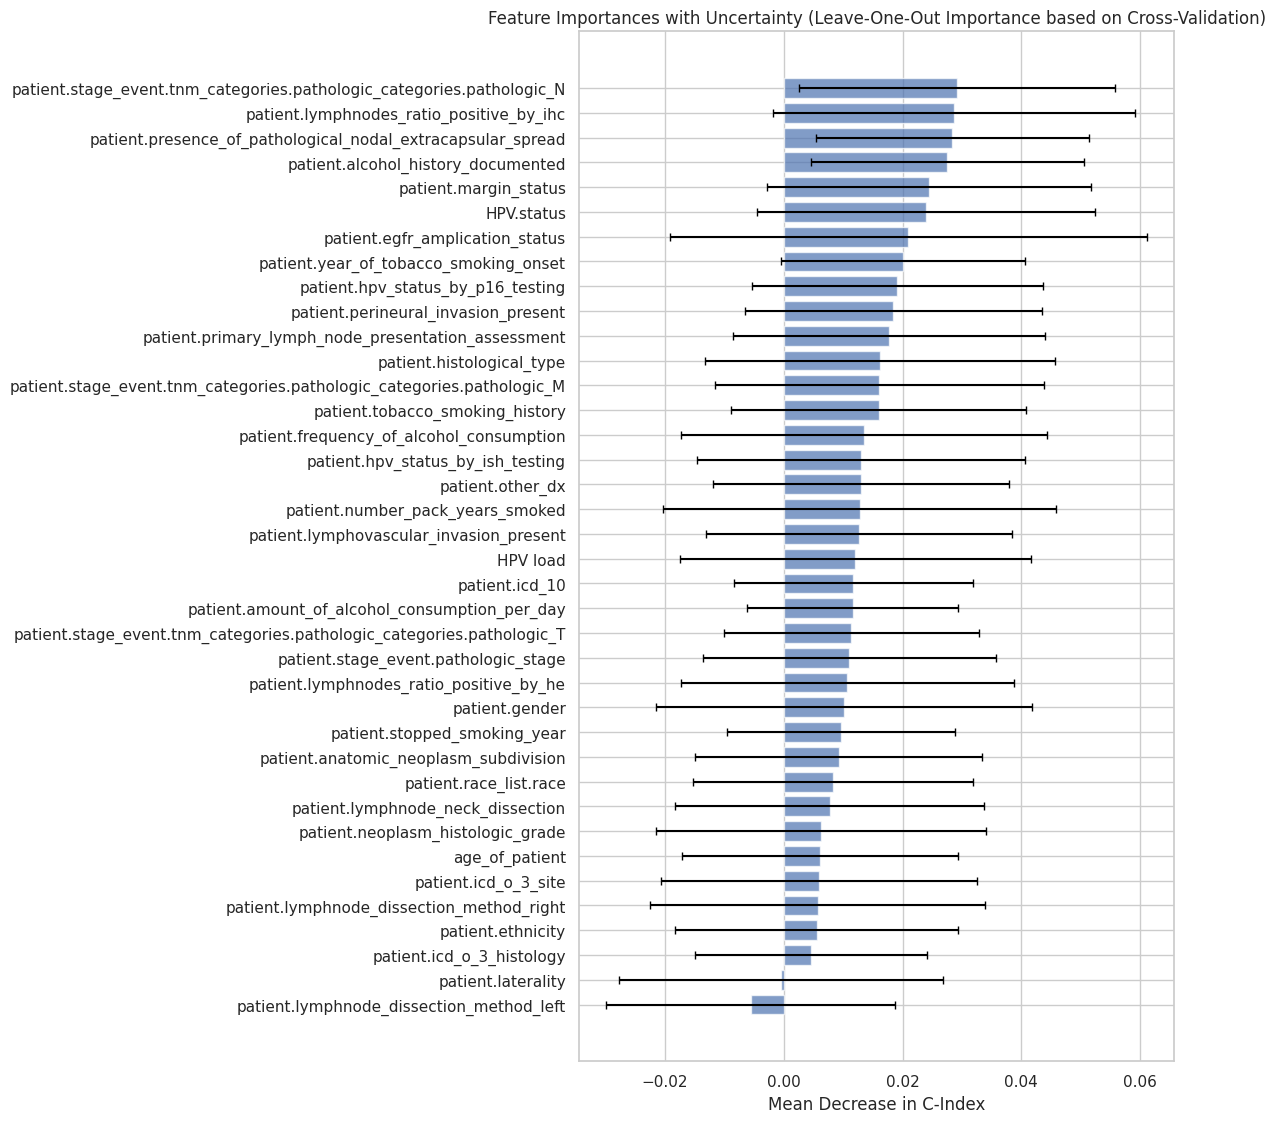

In [66]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes' is your input DataFrame
clinical_data_test = clinical_data_yes.copy()

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

#clinical_data_test['HPV.status'] = clinical_data_test['HPV.status'].replace({'positive': 1, 'negative': 0})

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

print(clinical_data_test['age_of_patient'])




# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'age_of_patient',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage',
    'HPV load'

]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'HPV load'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Prepare Survival Data
# -------------------------------------------

# Fill NaN values in 'PFI.time' with the mean
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)

# Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

time_copy = time.copy()
event_copy = event.copy()

# -------------------------------------------
# Feature Engineering
# -------------------------------------------

# Scale numerical features
scaler = StandardScaler()
scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

# Convert scaled numerical features back to DataFrame for compatibility
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

# Combine scaled numerical features and categorical features into a single DataFrame
X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

print(X.iloc[42])

X_copy = X.copy()
# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, event))
X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
y_train_event, y_test_event = event[train_idx], event[test_idx]
y_train_time, y_test_time = time[train_idx], time[test_idx]

# -------------------------------------------
# Preparing Data for FTTransformer
# -------------------------------------------

# Identify numerical and categorical columns after preprocessing
categorical_columns = list(categorical_cols)
numerical_columns = num_cols

# Prepare data for FTTransformer
def prepare_data(X, categorical_columns, numerical_columns):
    # For categorical features
    cat_features = X[categorical_columns]
    # For numerical features
    num_features = X[numerical_columns]
    return cat_features, num_features

X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

# -------------------------------------------
# Convert Data to PyTorch Tensors
# -------------------------------------------

# Convert data to torch tensors
def to_tensor(x, dtype):
    return torch.tensor(x.values, dtype=dtype)

X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
X_train_num_tensor = to_tensor(X_train_num, torch.float32)
X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
X_test_num_tensor = to_tensor(X_test_num, torch.float32)

# -------------------------------------------
# Initialize FTTransformer (Pretrained)
# -------------------------------------------

# Get the number of unique categories for each categorical column
categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

# Instantiate the FTTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ft_transformer = FTTransformer(
    categories=categories,                              # List of unique category counts
    num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
    dim=192,                                            # Embedding dimension size, adjust as needed
    depth=6,                                            # Number of transformer layers
    heads=8,                                            # Number of attention heads
    attn_dropout=0.1,                                   # Dropout for attention layers
    ff_dropout=0.1                                      # Dropout for feedforward layers
).to(device)

# Load pretrained weights if available
# Uncomment and modify the following line if you have pretrained weights
# ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

# Set the model to evaluation mode
ft_transformer.eval()

# -------------------------------------------
# Generating Embeddings
# -------------------------------------------

def get_embeddings(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
        numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
        embeddings = model(categorical, numerical, return_embedding=True)
        return embeddings.cpu().numpy()

# Generate embeddings for training and test sets
train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

# Verify the shape of the embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Initialize the MLPVanilla model with reduced input features 
net = tt.practical.MLPVanilla(
    in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
    num_nodes=num_nodes,
    out_features=out_features,
    batch_norm=batch_norm,
    dropout=dropout,
    output_bias=output_bias
)

# Initialize the CoxPH model with the network and optimizer
optimizer = tt.optim.Adam(lr=1e-3)
cox_ph = CoxPH(net, optimizer)

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
durations_train = y_train_time.astype(np.float32)
events_train = y_train_event.astype(np.int64)

# Ensure embeddings are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = train_embeddings[train_idx_cv]
    y_train_cv_durations = durations_train[train_idx_cv]
    y_train_cv_events = events_train[train_idx_cv]
    
    X_val_cv = train_embeddings[val_idx_cv]
    y_val_cv_durations = durations_train[val_idx_cv]
    y_val_cv_events = events_train[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
    
    # Initialize a new instance of the network for each fold to avoid weight sharing
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    c_index = concordance_index_censored(
        y_val_cv_events.astype(bool),
        y_val_cv_durations,
        -risk_val  # Use negative risk for proper ordering
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("\nTraining Final CoxPH Model on Entire Training Set...\n")

# Ensure arrays are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)
durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
events_train = np.ascontiguousarray(events_train, dtype=np.int64)

# Fit the final model on the entire training set
cox_ph.fit(
    train_embeddings,
    (events_train, durations_train),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("\nEvaluating on Test Set...\n")

# Prepare test data
durations_test = y_test_time.astype(np.float32)
events_test = y_test_event.astype(np.int64)
test_embeddings = np.ascontiguousarray(test_embeddings, dtype=np.float32)

# Predict risk scores on test set
risk_test = cox_ph.predict(test_embeddings).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    events_test.astype(bool),
    durations_test,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(test_embeddings), size=len(test_embeddings), replace=True)
    X_test_bs = test_embeddings[indices]
    durations_test_bs = durations_test[indices]
    events_test_bs = events_test[indices]
    
    # Predict risk scores
    risk_bs = cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs.astype(bool),
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")

# -------------------------------------------
# Leave-One-Out Feature Importance Analysis based on Cross-Validation
# -------------------------------------------

print("\nStarting Leave-One-Out Feature Importance Analysis based on Cross-Validation...\n")

# Combine categorical and numerical columns
all_columns = categorical_columns + numerical_columns

# Initialize a DataFrame to store feature importances
loo_feature_importances = pd.DataFrame(columns=['Feature', 'Mean Decrease', 'Std Deviation'])

# Number of folds and repeats
n_splits = 5
n_repeats = 5  # Adjust as needed for uncertainty estimation

# Initialize KFold Cross-Validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# List to collect feature importance dataframes from each fold
feature_importance_list = []

# Loop over each fold
for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(X_train_df)):
    print(f"\nProcessing Fold {fold + 1}/{n_splits}")
    
    # Split data into training and validation sets for this fold
    X_train_cv = X_train_df.iloc[train_idx_cv]
    y_train_cv_time = y_train_time[train_idx_cv]
    y_train_cv_event = y_train_event[train_idx_cv]
    
    X_val_cv = X_train_df.iloc[val_idx_cv]
    y_val_cv_time = y_train_time[val_idx_cv]
    y_val_cv_event = y_train_event[val_idx_cv]
    
    # Prepare data for FTTransformer
    X_train_cat_cv, X_train_num_cv = prepare_data(X_train_cv, categorical_columns, numerical_columns)
    X_val_cat_cv, X_val_num_cv = prepare_data(X_val_cv, categorical_columns, numerical_columns)
    
    # Get embeddings
    train_embeddings_cv = get_embeddings(ft_transformer, X_train_cat_cv, X_train_num_cv)
    val_embeddings_cv = get_embeddings(ft_transformer, X_val_cat_cv, X_val_num_cv)
    
    # Prepare survival data
    durations_train_cv = y_train_cv_time.astype(np.float32)
    events_train_cv = y_train_cv_event.astype(np.int64)
    durations_val_cv = y_val_cv_time.astype(np.float32)
    events_val_cv = y_val_cv_event.astype(np.int64)
    
    # Ensure embeddings are contiguous
    train_embeddings_cv = np.ascontiguousarray(train_embeddings_cv, dtype=np.float32)
    val_embeddings_cv = np.ascontiguousarray(val_embeddings_cv, dtype=np.float32)
    
    # Initialize the network for this fold
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings_cv.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        train_embeddings_cv,
        (events_train_cv, durations_train_cv),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val_cv = cox_ph_cv.predict(val_embeddings_cv).squeeze()
    
    # Compute baseline C-Index on validation set
    baseline_c_index_cv = concordance_index_censored(
        events_val_cv.astype(bool),
        durations_val_cv,
        -risk_val_cv  # Use negative risk for proper ordering
    )[0]
    
    print(f"Baseline C-Index for Fold {fold + 1}: {baseline_c_index_cv:.4f}")
    
    # Initialize a DataFrame to store feature importances for this fold
    fold_feature_importances = pd.DataFrame(columns=['Feature', 'Mean Decrease', 'Std Deviation'])
    
    # Function to compute C-Index after leaving one feature out
    def compute_loo_importance_cv(feature_name):
        c_indices = []
        for repeat in range(n_repeats):
            # Set a different seed for each repeat
            np.random.seed(seed + fold * n_repeats + repeat)
            
            # Make copies of training and validation data
            X_train_cat_loo = X_train_cat_cv.copy()
            X_train_num_loo = X_train_num_cv.copy()
            X_val_cat_loo = X_val_cat_cv.copy()
            X_val_num_loo = X_val_num_cv.copy()
            
            # Drop the feature
            if feature_name in X_train_cat_loo.columns:
                X_train_cat_loo = X_train_cat_loo.drop(columns=[feature_name])
                X_val_cat_loo = X_val_cat_loo.drop(columns=[feature_name])
            elif feature_name in X_train_num_loo.columns:
                X_train_num_loo = X_train_num_loo.drop(columns=[feature_name])
                X_val_num_loo = X_val_num_loo.drop(columns=[feature_name])
            else:
                print(f"Feature '{feature_name}' not found in data.")
                return np.nan, np.nan
            
            # Get number of categories for updated categorical features
            categories_loo = [int(X_train_cat_loo[col].max() + 1) for col in X_train_cat_loo.columns]
            
            # Reinitialize FTTransformer with updated input dimensions
            ft_transformer_loo = FTTransformer(
                categories=categories_loo,
                num_continuous=X_train_num_loo.shape[1],
                dim=192,
                depth=6,
                heads=8,
                attn_dropout=0.1,
                ff_dropout=0.1
            ).to(device)
            ft_transformer_loo.eval()
            
            # Generate embeddings
            train_embeddings_loo = get_embeddings(ft_transformer_loo, X_train_cat_loo, X_train_num_loo)
            val_embeddings_loo = get_embeddings(ft_transformer_loo, X_val_cat_loo, X_val_num_loo)
            
            # Ensure embeddings are contiguous
            train_embeddings_loo = np.ascontiguousarray(train_embeddings_loo, dtype=np.float32)
            val_embeddings_loo = np.ascontiguousarray(val_embeddings_loo, dtype=np.float32)
            
            # Reinitialize the network
            net_loo = tt.practical.MLPVanilla(
                in_features=train_embeddings_loo.shape[1],
                num_nodes=num_nodes,
                out_features=out_features,
                batch_norm=batch_norm,
                dropout=dropout,
                output_bias=output_bias
            )
            
            optimizer_loo = tt.optim.Adam(lr=1e-3)
            cox_ph_loo = CoxPH(net_loo, optimizer_loo)
            
            # Fit the model
            cox_ph_loo.fit(
                train_embeddings_loo,
                (events_train_cv, durations_train_cv),
                batch_size=64,
                epochs=100,
                verbose=False
            )
            
            # Predict risk scores on validation set
            risk_val_loo = cox_ph_loo.predict(val_embeddings_loo).squeeze()
            
            # Compute C-Index on Validation Set
            c_index_loo = concordance_index_censored(
                events_val_cv.astype(bool),
                durations_val_cv,
                -risk_val_loo  # Use negative risk for proper ordering
            )[0]
            
            c_indices.append(c_index_loo)
        
        # Compute mean and standard deviation
        c_index_mean = np.mean(c_indices)
        c_index_std = np.std(c_indices)
        
        # Compute decrease in C-Index
        mean_decrease = baseline_c_index_cv - c_index_mean
        
        return mean_decrease, c_index_std
    
    # Loop over all features and compute LOO importance
    print(f"\nComputing Leave-One-Out importance for Fold {fold + 1}...\n")
    for feature in tqdm(all_columns, desc=f"Fold {fold + 1} LOO"):
        mean_decrease, std_deviation = compute_loo_importance_cv(feature)
        fold_feature_importances = fold_feature_importances.append({
            'Feature': feature,
            'Mean Decrease': mean_decrease,
            'Std Deviation': std_deviation
        }, ignore_index=True)
    
    # Append fold results to the list
    feature_importance_list.append(fold_feature_importances)
    
    print(f"\nCompleted Leave-One-Out importance for Fold {fold + 1}.\n")

# Aggregate feature importances across folds
all_importances = pd.concat(feature_importance_list)
grouped_importances = all_importances.groupby('Feature').agg({
    'Mean Decrease': 'mean',
    'Std Deviation': 'mean'
}).reset_index()

# Handle any NaN values
grouped_importances['Mean Decrease'] = pd.to_numeric(grouped_importances['Mean Decrease'], errors='coerce')
grouped_importances['Std Deviation'] = pd.to_numeric(grouped_importances['Std Deviation'], errors='coerce')
grouped_importances.fillna(0, inplace=True)  # Replace NaN with 0

# Reset index and sort features by mean decrease in C-Index
grouped_importances.sort_values(by='Mean Decrease', ascending=False, inplace=True)

# Print the total number of features in the importance DataFrame
print(f"\nTotal number of features in LOO importance DataFrame: {len(grouped_importances)}")

# Display feature importances
print("\nFeature Importances (Leave-One-Out Importance based on Cross-Validation):")
print(grouped_importances[['Feature', 'Mean Decrease', 'Std Deviation']])

# Visualize the feature importances with error bars
plt.figure(figsize=(12, max(6, 0.3 * len(grouped_importances))))
plt.barh(
    grouped_importances['Feature'],
    grouped_importances['Mean Decrease'],
    xerr=grouped_importances['Std Deviation'],
    align='center',
    alpha=0.7,
    ecolor='black',
    capsize=3
)
plt.gca().invert_yaxis()
plt.xlabel('Mean Decrease in C-Index')
plt.title('Feature Importances with Uncertainty (Leave-One-Out Importance based on Cross-Validation)')
plt.tight_layout()
plt.show()


1. WSI WWSI WSI WSI WSI

In [68]:
print(X)

     patient.lymphnodes_ratio_positive_by_ihc  \
0                                   -0.824935   
1                                   -0.824935   
2                                   -0.824935   
3                                   -0.824935   
4                                   -0.824935   
..                                        ...   
523                                 -0.824935   
524                                  1.201689   
525                                 -0.824935   
526                                 -0.824935   
527                                 -0.824935   

     patient.lymphnodes_ratio_positive_by_he  age_in_years  \
0                                  -0.811718     -0.094354   
1                                  -0.811718      0.176549   
2                                  -0.811718      0.568518   
3                                  -0.811718     -0.174681   
4                                  -0.811718      1.908763   
..                                     

In [67]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional but recommended)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Load Survival Data
# -------------------------------------------

# Path to the JSON file containing survival data
json_path = 'svs_patient_map_PFI.json'

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
survival_df = pd.DataFrame(survival_entries)

# -------------------------------------------
# Load Embeddings
# -------------------------------------------

# Path to the directory containing embedding files
embeddings_dir = os.path.expanduser('~/scratch/TCGA-HNSC-embeddings-flatten')

# Initialize a list to keep track of missing files
missing_files = []

# Function to load a single embedding file
def load_embedding(file_name):
    """
    Loads the embedding from a .pt file corresponding to the given .svs file name.
    If the embedding file is missing or corrupted, returns None and logs the missing file.
    """
    # Replace .svs with _flatten.pt
    embedding_file = file_name.replace('.svs', '_flatten.pt')
    embedding_path = os.path.join(embeddings_dir, embedding_file)
    
    if not os.path.exists(embedding_path):
        missing_files.append(embedding_file)
        return None
    
    # Load the PyTorch tensor and convert to NumPy array
    try:
        embedding_tensor = torch.load(embedding_path)
        embedding_np = embedding_tensor.numpy().astype(np.float32).flatten()  # Ensure it's a 1D array
        return embedding_np
    except Exception as e:
        print(f"Error loading {embedding_path}: {e}")
        missing_files.append(embedding_file)
        return None

# Apply the loading function to all entries
survival_df['embedding'] = survival_df['file_name'].apply(load_embedding)

# Remove entries where embedding is None (i.e., missing or corrupted files)
initial_count = len(survival_df)
survival_df = survival_df[survival_df['embedding'].notnull()].reset_index(drop=True)
final_count = len(survival_df)
removed_count = initial_count - final_count

print(f"Total entries: {initial_count}")
print(f"Entries with embeddings: {final_count}")
print(f"Entries removed due to missing or corrupted embeddings: {removed_count}")

# If there are missing files, log them
if missing_files:
    print("\nMissing embedding files:")
    for file in missing_files:
        print(f"- {file}")

# -------------------------------------------
# Prepare the Data
# -------------------------------------------

# Extract embeddings as a 2D NumPy array
embeddings = np.stack(survival_df['embedding'].values)  # Shape: (num_samples, 192)

# Extract survival endpoints
durations = survival_df['time_to_event'].values.astype(float)
events = survival_df['censoring'].values.astype(bool)  # Keep as boolean

# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(embeddings, events))
X_train, X_test = embeddings[train_idx], embeddings[test_idx]
y_train_durations, y_test_durations = durations[train_idx], durations[test_idx]
y_train_events, y_test_events = events[train_idx], events[test_idx]

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer
out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Function to initialize the network
def initialize_network(input_dim):
    """
    Initializes the MLPVanilla network with the specified architecture.
    """
    return tt.practical.MLPVanilla(
        in_features=input_dim,
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
# Convert events to int64 for Pycox (optional, as Pycox can handle boolean)
# y_train_events_int = y_train_events.astype(np.int64)  # Not necessary
y_train_durations_float = y_train_durations.astype(np.float32)

# Ensure embeddings are contiguous in memory
X_train = np.ascontiguousarray(X_train, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = X_train[train_idx_cv]
    y_train_cv_durations = y_train_durations_float[train_idx_cv]
    y_train_cv_events = y_train_events[train_idx_cv]
    
    X_val_cv = X_train[val_idx_cv]
    y_val_cv_durations = y_train_durations_float[val_idx_cv]
    y_val_cv_events = y_train_events[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    # y_train_cv_events remains boolean
    
    # Initialize a new instance of the network for each fold
    net_cv = initialize_network(input_dim=X_train_cv.shape[1])
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    # Use negative risk for proper ordering (higher risk -> shorter survival)
    c_index = concordance_index_censored(
        y_val_cv_events,
        y_val_cv_durations,
        -risk_val
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("\nTraining Final CoxPH Model on Entire Training Set...\n")

# Initialize the network and CoxPH model
final_net = initialize_network(input_dim=X_train.shape[1])
final_optimizer = tt.optim.Adam(lr=1e-3)
final_cox_ph = CoxPH(final_net, final_optimizer)

# Ensure arrays are contiguous
X_train = np.ascontiguousarray(X_train, dtype=np.float32)
y_train_durations_float = y_train_durations.astype(np.float32)
y_train_events_bool = y_train_events.astype(bool)  # Keep as boolean

# Fit the final model on the entire training set
final_cox_ph.fit(
    X_train,
    (y_train_events, y_train_durations_float),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("\nEvaluating on Test Set...\n")

# Prepare test data
X_test = np.ascontiguousarray(X_test, dtype=np.float32)
y_test_durations_float = y_test_durations.astype(np.float32)
y_test_events_bool = y_test_events.astype(bool)  # Ensure boolean

# Predict risk scores on test set
risk_test = final_cox_ph.predict(X_test).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    y_test_events_bool,
    y_test_durations_float,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(X_test), size=len(X_test), replace=True)
    X_test_bs = X_test[indices]
    durations_test_bs = y_test_durations_float[indices]
    events_test_bs = y_test_events_bool[indices]
    
    # Predict risk scores
    risk_bs = final_cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs,
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")


KeyboardInterrupt: 

In [76]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional but recommended)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Load Survival Data
# -------------------------------------------

# Path to the JSON file containing survival data
json_path = 'svs_patient_map_PFI.json'

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
survival_df = pd.DataFrame(survival_entries)

# -------------------------------------------
# Categorize Entries Based on Substrings in 'file_name'
# -------------------------------------------

# Define the categories and their corresponding substrings
categories = {
    'DX': 'DX',
    'TS': 'TS',
    'BS': 'BS',
    'MS': 'MS'
}

# Function to categorize based on substrings
def categorize_file(file_name):
    for category, substring in categories.items():
        if substring in file_name:
            return category
    return 'Other'

# Apply categorization
survival_df['category'] = survival_df['file_name'].apply(categorize_file)

# Display statistics
total_entries = len(survival_df)
category_counts = survival_df['category'].value_counts()

print("----- Dataset Statistics -----")
print(f"Total entries: {total_entries}")
for category in categories.keys():
    count = category_counts.get(category, 0)
    print(f"Entries with {category}: {count}")
other_count = category_counts.get('Other', 0)
print(f"Entries with Other categories: {other_count}")
print("------------------------------\n")

# -------------------------------------------
# Filter to Include Only 'DX' Entries
# -------------------------------------------

# Filter the DataFrame to include only entries with 'DX' in their 'file_name'
dx_df = survival_df[survival_df['category'] == 'DX'].reset_index(drop=True)

# Display statistics after filtering
dx_total = len(dx_df)
dx_missing = 0  # To be updated after attempting to load embeddings
print(f"Total 'DX' entries: {dx_total}\n")

# -------------------------------------------
# Load Embeddings
# -------------------------------------------

# Path to the directory containing embedding files
#embeddings_dir = os.path.expanduser('/home/sorkwos/projects/rrg-senger-ab/multimodality/contrastive_learning/TCGA-HNSC-data/TCGA-HNSC-embeddings-flatten')
#embeddings_dir = os.path.expanduser('/home/sorkwos/projects/rrg-senger-ab/multimodality/contrastive_learning/TCGA-HNSC-data/flatten_refined_PFI')
#embeddings_dir = os.path.expanduser('/home/sorkwos/projects/rrg-senger-ab/multimodality/contrastive_learning/TCGA-HNSC-data/flatten_refined_PFI_T')
embeddings_dir = os.path.expanduser('/home/sorkwos/projects/rrg-senger-ab/multimodality/contrastive_learning/TCGA-HNSC-data/flatten_refined_PFI_N')

# Initialize a list to keep track of missing files
missing_files = []

# Function to load a single embedding file
def load_embedding(file_name):
    """
    Loads the embedding from a .pt file corresponding to the given .svs file name.
    If the embedding file is missing or corrupted, returns None and logs the missing file.
    """
    # Replace .svs with _flatten.pt
    embedding_file = file_name.replace('.svs', '_flatten.pt')
    embedding_path = os.path.join(embeddings_dir, embedding_file)
    
    if not os.path.exists(embedding_path):
        missing_files.append(embedding_file)
        return None
    
    # Load the PyTorch tensor and convert to NumPy array
    try:
        embedding_tensor = torch.load(embedding_path)
        embedding_np = embedding_tensor.numpy().astype(np.float32).flatten()  # Ensure it's a 1D array
        return embedding_np
    except Exception as e:
        print(f"Error loading {embedding_path}: {e}")
        missing_files.append(embedding_file)
        return None

# Apply the loading function to all 'DX' entries
dx_df['embedding'] = dx_df['file_name'].apply(load_embedding)

# Remove entries where embedding is None (i.e., missing or corrupted files)
initial_dx_count = len(dx_df)
dx_df = dx_df[dx_df['embedding'].notnull()].reset_index(drop=True)
final_dx_count = len(dx_df)
removed_dx_count = initial_dx_count - final_dx_count

print(f"Entries with 'DX' embeddings: {final_dx_count}")
print(f"Entries removed due to missing or corrupted embeddings: {removed_dx_count}\n")

# If there are missing files, log them
if missing_files:
    print("----- Missing Embedding Files -----")
    for file in missing_files:
        print(f"- {file}")
    print("-----------------------------------\n")

# -------------------------------------------
# Prepare the Data
# -------------------------------------------

# Extract embeddings as a 2D NumPy array
embeddings = np.stack(dx_df['embedding'].values)  # Shape: (num_dx_samples, 192)

# Extract survival endpoints
durations = dx_df['time_to_event'].values.astype(float)
events = dx_df['censoring'].values.astype(bool)  # Keep as boolean

# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(embeddings, events))
X_train, X_test = embeddings[train_idx], embeddings[test_idx]
y_train_durations, y_test_durations = durations[train_idx], durations[test_idx]
y_train_events, y_test_events = events[train_idx], events[test_idx]

print("----- Data Splitting -----")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print("--------------------------\n")

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer
out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Function to initialize the network
def initialize_network(input_dim):
    """
    Initializes the MLPVanilla network with the specified architecture.
    """
    return tt.practical.MLPVanilla(
        in_features=input_dim,
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
# Pycox can handle boolean events directly
y_train_events_bool = y_train_events
y_train_durations_float = y_train_durations.astype(np.float32)

# Ensure embeddings are contiguous in memory
X_train = np.ascontiguousarray(X_train, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = X_train[train_idx_cv]
    y_train_cv_durations = y_train_durations_float[train_idx_cv]
    y_train_cv_events = y_train_events_bool[train_idx_cv]
    
    X_val_cv = X_train[val_idx_cv]
    y_val_cv_durations = y_train_durations_float[val_idx_cv]
    y_val_cv_events = y_train_events_bool[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    # y_train_cv_events remains boolean
    
    # Initialize a new instance of the network for each fold
    net_cv = initialize_network(input_dim=X_train_cv.shape[1])
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    # Use negative risk for proper ordering (higher risk -> shorter survival)
    c_index = concordance_index_censored(
        y_val_cv_events,
        y_val_cv_durations,
        -risk_val
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("\nTraining Final CoxPH Model on Entire Training Set...\n")

# Initialize the network and CoxPH model
final_net = initialize_network(input_dim=X_train.shape[1])
final_optimizer = tt.optim.Adam(lr=1e-3)
final_cox_ph = CoxPH(final_net, final_optimizer)

# Ensure arrays are contiguous
X_train = np.ascontiguousarray(X_train, dtype=np.float32)
y_train_durations_float = y_train_durations.astype(np.float32)
y_train_events_bool = y_train_events.astype(bool)  # Ensure boolean

# Fit the final model on the entire training set
final_cox_ph.fit(
    X_train,
    (y_train_events_bool, y_train_durations_float),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("\nEvaluating on Test Set...\n")

# Prepare test data
X_test = np.ascontiguousarray(X_test, dtype=np.float32)
y_test_durations_float = y_test_durations.astype(np.float32)
y_test_events_bool = y_test_events.astype(bool)  # Ensure boolean

# Predict risk scores on test set
risk_test = final_cox_ph.predict(X_test).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    y_test_events_bool,
    y_test_durations_float,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(X_test), size=len(X_test), replace=True)
    X_test_bs = X_test[indices]
    durations_test_bs = y_test_durations_float[indices]
    events_test_bs = y_test_events_bool[indices]
    
    # Predict risk scores
    risk_bs = final_cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs,
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")


----- Dataset Statistics -----
Total entries: 1263
Entries with DX: 472
Entries with TS: 548
Entries with BS: 243
Entries with MS: 0
Entries with Other categories: 0
------------------------------

Total 'DX' entries: 472

Entries with 'DX' embeddings: 472
Entries removed due to missing or corrupted embeddings: 0

----- Data Splitting -----
Training set size: 377
Test set size: 95
--------------------------


Starting 5-Fold Cross-Validation...

Fold 1
Fold 1 C-Index: 0.6859

Fold 2
Fold 2 C-Index: 0.5610

Fold 3
Fold 3 C-Index: 0.6245

Fold 4
Fold 4 C-Index: 0.4933

Fold 5
Fold 5 C-Index: 0.5760

Cross-Validation C-Index: 0.5881 ± 0.0644
95% Confidence Interval: [0.5001, 0.6798]

Training Final CoxPH Model on Entire Training Set...

Final CoxPH Model Trained Successfully.

Evaluating on Test Set...

Test C-Index: 0.5795

Starting Bootstrapping for Test C-Index Uncertainty...

Bootstrap 100/1000 completed.
Bootstrap 200/1000 completed.
Bootstrap 300/1000 completed.
Bootstrap 400/1000 c


Optimal Threshold Selection and Kaplan-Meier Plotting for Test Set with Group Size Restriction...

Test C-Index: 0.5795
Median survival time - High Risk: 431.0
Median survival time - Low Risk: 667.0
Optimal threshold for risk score on test set: -0.4056
Minimum p-value from log-rank test on test set: 0.003


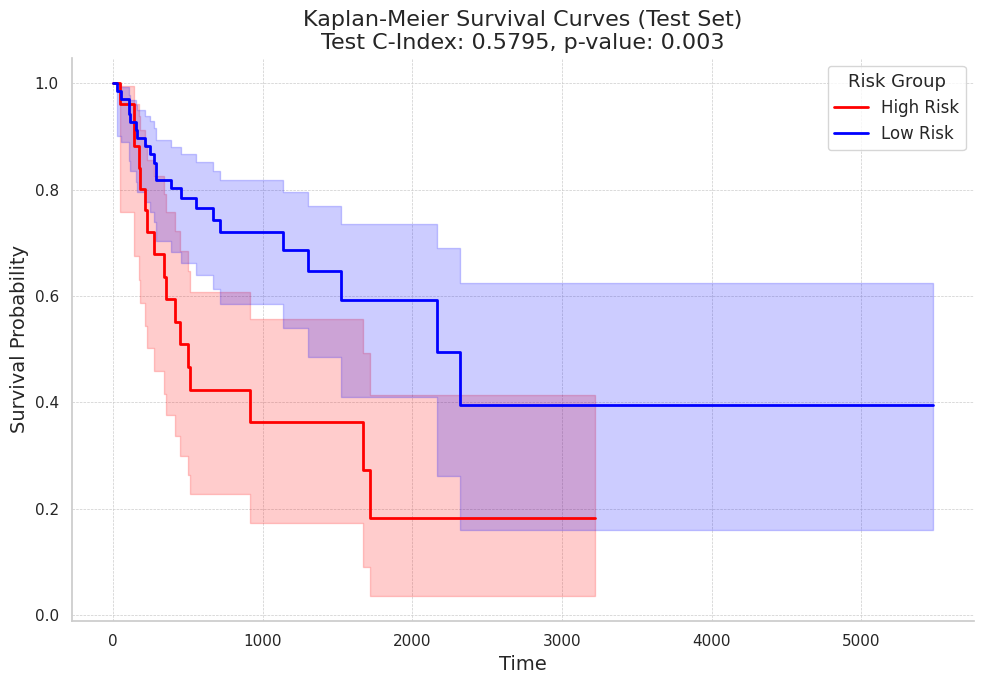

In [77]:
# -------------------------------------------
# Additional Imports Needed
# -------------------------------------------
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# -------------------------------------------
# Optimal Threshold Selection and Kaplan-Meier Plotting for Test Set
# -------------------------------------------

print("\nOptimal Threshold Selection and Kaplan-Meier Plotting for Test Set with Group Size Restriction...\n")

# Prepare data
risk_scores_test = risk_test  # Risk scores from the model on test set
durations_test = y_test_durations_float  # Durations on test set
events_test = y_test_events_bool  # Events on test set

# Use negative risk scores for proper ordering in concordance index calculation
# This is consistent with your base script
c_index_test = concordance_index_censored(
    events_test,
    durations_test,
    -risk_scores_test  # Use negative risk scores
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# Search for the optimal threshold
unique_risk_scores_test = np.sort(np.unique(risk_scores_test))

# Initialize variables
best_threshold_test = None
min_p_value_test = 1.0

# Minimum group size (at least 25% of patients in each group)
total_patients = len(risk_scores_test)
min_group_size = total_patients * 0.25

# For each possible threshold, compute the log-rank test p-value
for threshold in unique_risk_scores_test[1:-1]:
    # Assign patients to groups
    is_high_risk = risk_scores_test <= threshold  # High risk have lower risk scores
    is_low_risk = risk_scores_test > threshold

    # Calculate group sizes
    group_high_size = is_high_risk.sum()
    group_low_size = is_low_risk.sum()

    # Ensure each group has at least the minimum number of patients
    if group_high_size < min_group_size or group_low_size < min_group_size:
        continue  # Skip thresholds that result in small groups

    # Check if both groups have events
    if events_test[is_high_risk].sum() == 0 or events_test[is_low_risk].sum() == 0:
        continue  # Skip thresholds where one group has no events

    # Perform log-rank test
    results_test = logrank_test(
        durations_test[is_high_risk],
        durations_test[is_low_risk],
        event_observed_A=events_test[is_high_risk],
        event_observed_B=events_test[is_low_risk]
    )
    p_value_test = results_test.p_value

    # Update the best threshold if p-value is lower
    if p_value_test < min_p_value_test:
        min_p_value_test = p_value_test
        best_threshold_test = threshold

# Check if a valid threshold was found
if best_threshold_test is None:
    print("No valid threshold found that satisfies the group size restriction.")
else:
    # Assign patients to groups based on the best threshold
    is_high_risk = risk_scores_test <= best_threshold_test
    is_low_risk = risk_scores_test > best_threshold_test

    # Confirm that the high-risk group has shorter survival times
    median_survival_high = np.median(durations_test[is_high_risk])
    median_survival_low = np.median(durations_test[is_low_risk])

    print(f"Median survival time - High Risk: {median_survival_high}")
    print(f"Median survival time - Low Risk: {median_survival_low}")

    # Ensure high-risk group has shorter survival times
    if median_survival_high >= median_survival_low:
        print("Warning: High-risk group does not have shorter median survival time compared to low-risk group.")
        # You may choose to investigate further or adjust the thresholding method

    print(f"Optimal threshold for risk score on test set: {best_threshold_test:.4f}")

    # Format p-value
    if min_p_value_test < 0.001:
        p_value_formatted = "< 0.001"
    else:
        p_value_formatted = f"{min_p_value_test:.3f}"
    print(f"Minimum p-value from log-rank test on test set: {p_value_formatted}")

    # Create a DataFrame for plotting
    test_data = pd.DataFrame({
        'duration': durations_test,
        'event': events_test,
        'group': np.where(is_high_risk, 'High Risk', 'Low Risk')
    })

    # Kaplan-Meier fitting and plotting using Seaborn
    kmf_high_test = KaplanMeierFitter()
    kmf_low_test = KaplanMeierFitter()

    plt.figure(figsize=(10, 7))

    # Fit the models
    kmf_high_test.fit(
        test_data['duration'][test_data['group'] == 'High Risk'],
        event_observed=test_data['event'][test_data['group'] == 'High Risk'],
        label='High Risk'
    )
    kmf_low_test.fit(
        test_data['duration'][test_data['group'] == 'Low Risk'],
        event_observed=test_data['event'][test_data['group'] == 'Low Risk'],
        label='Low Risk'
    )

    # Plot the survival curves with confidence intervals (error bands)
    ax = kmf_high_test.plot(ci_show=True, ci_alpha=0.2, linewidth=2, color='red')
    kmf_low_test.plot(ax=ax, ci_show=True, ci_alpha=0.2, linewidth=2, color='blue')

    # Customize the plot using Seaborn aesthetics
    sns.despine()

    # Add c-index and p-value to the plot
    plt.title('Kaplan-Meier Survival Curves (Test Set)\nTest C-Index: {:.4f}, p-value: {}'.format(c_index_test, p_value_formatted), fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Survival Probability', fontsize=14)
    plt.legend(title='Risk Group', fontsize=12, title_fontsize=13)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [13]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional but recommended)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Load Survival Data
# -------------------------------------------

# Path to the JSON file containing survival data
json_path = 'svs_patient_map_PFI.json'

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
survival_df = pd.DataFrame(survival_entries)

# -------------------------------------------
# Categorize Entries Based on Substrings in 'file_name'
# -------------------------------------------

# Define the categories and their corresponding substrings
categories = {
    'DX': 'DX',
    'TS': 'TS',
    'BS': 'BS',
    'MS': 'MS'
}

# Function to categorize based on substrings
def categorize_file(file_name):
    """
    Categorizes the file based on specific substrings present in the file_name.
    Returns the category name if a substring is found, else returns 'Other'.
    """
    for category, substring in categories.items():
        if substring in file_name:
            return category
    return 'Other'

# Apply categorization
survival_df['category'] = survival_df['file_name'].apply(categorize_file)

# Display statistics
total_entries = len(survival_df)
category_counts = survival_df['category'].value_counts()

print("----- Dataset Statistics -----")
print(f"Total entries: {total_entries}")
for category in categories.keys():
    count = category_counts.get(category, 0)
    print(f"Entries with {category}: {count}")
other_count = category_counts.get('Other', 0)
print(f"Entries with Other categories: {other_count}")
print("------------------------------\n")

# -------------------------------------------
# Filter to Exclude 'DX' Entries
# -------------------------------------------

# Filter the DataFrame to exclude entries with 'DX' in their 'file_name'
non_dx_df = survival_df[survival_df['category'] != 'DX'].reset_index(drop=True)

# Display statistics after filtering
non_dx_total = len(non_dx_df)
print(f"Total 'Non-DX' entries: {non_dx_total}\n")

# -------------------------------------------
# Load Embeddings
# -------------------------------------------

# Path to the directory containing embedding files
embeddings_dir = os.path.expanduser('~/scratch/TCGA-HNSC-embeddings-flatten-hipt')

# Initialize a list to keep track of missing files
missing_files = []

# Function to load a single embedding file
def load_embedding(file_name):
    """
    Loads the embedding from a .pt file corresponding to the given .svs file name.
    If the embedding file is missing or corrupted, returns None and logs the missing file.
    """
    # Replace .svs with _flatten.pt
    embedding_file = file_name.replace('.svs', '_flatten.pt')
    embedding_path = os.path.join(embeddings_dir, embedding_file)
    
    if not os.path.exists(embedding_path):
        missing_files.append(embedding_file)
        return None
    
    # Load the PyTorch tensor and convert to NumPy array
    try:
        embedding_tensor = torch.load(embedding_path)
        embedding_np = embedding_tensor.numpy().astype(np.float32).flatten()  # Ensure it's a 1D array
        return embedding_np
    except Exception as e:
        print(f"Error loading {embedding_path}: {e}")
        missing_files.append(embedding_file)
        return None

# Apply the loading function to all 'Non-DX' entries
non_dx_df['embedding'] = non_dx_df['file_name'].apply(load_embedding)

# Remove entries where embedding is None (i.e., missing or corrupted files)
initial_non_dx_count = len(non_dx_df)
non_dx_df = non_dx_df[non_dx_df['embedding'].notnull()].reset_index(drop=True)
final_non_dx_count = len(non_dx_df)
removed_non_dx_count = initial_non_dx_count - final_non_dx_count

print(f"Entries with 'Non-DX' embeddings: {final_non_dx_count}")
print(f"Entries removed due to missing or corrupted embeddings: {removed_non_dx_count}\n")

# If there are missing files, log them
if missing_files:
    print("----- Missing Embedding Files -----")
    for file in missing_files:
        print(f"- {file}")
    print("-----------------------------------\n")

# -------------------------------------------
# Prepare the Data
# -------------------------------------------

# Extract embeddings as a 2D NumPy array
embeddings = np.stack(non_dx_df['embedding'].values)  # Shape: (num_non_dx_samples, 192)

# Extract survival endpoints
durations = non_dx_df['time_to_event'].values.astype(float)
events = non_dx_df['censoring'].values.astype(bool)  # Keep as boolean

# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(embeddings, events))
X_train, X_test = embeddings[train_idx], embeddings[test_idx]
y_train_durations, y_test_durations = durations[train_idx], durations[test_idx]
y_train_events, y_test_events = events[train_idx], events[test_idx]

print("----- Data Splitting -----")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print("--------------------------\n")

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer
out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Function to initialize the network
def initialize_network(input_dim):
    """
    Initializes the MLPVanilla network with the specified architecture.
    """
    return tt.practical.MLPVanilla(
        in_features=input_dim,
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
# Pycox can handle boolean events directly
y_train_events_bool = y_train_events
y_train_durations_float = y_train_durations.astype(np.float32)

# Ensure embeddings are contiguous in memory
X_train = np.ascontiguousarray(X_train, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = X_train[train_idx_cv]
    y_train_cv_durations = y_train_durations_float[train_idx_cv]
    y_train_cv_events = y_train_events_bool[train_idx_cv]
    
    X_val_cv = X_train[val_idx_cv]
    y_val_cv_durations = y_train_durations_float[val_idx_cv]
    y_val_cv_events = y_train_events_bool[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    # y_train_cv_events remains boolean
    
    # Initialize a new instance of the network for each fold
    net_cv = initialize_network(input_dim=X_train_cv.shape[1])
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    # Use negative risk for proper ordering (higher risk -> shorter survival)
    c_index = concordance_index_censored(
        y_val_cv_events,
        y_val_cv_durations,
        -risk_val
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]\n")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("----- Training Final CoxPH Model on Entire Training Set -----\n")

# Initialize the network and CoxPH model
final_net = initialize_network(input_dim=X_train.shape[1])
final_optimizer = tt.optim.Adam(lr=1e-3)
final_cox_ph = CoxPH(final_net, final_optimizer)

# Ensure arrays are contiguous
X_train = np.ascontiguousarray(X_train, dtype=np.float32)
y_train_durations_float = y_train_durations.astype(np.float32)
y_train_events_bool = y_train_events.astype(bool)  # Ensure boolean

# Fit the final model on the entire training set
final_cox_ph.fit(
    X_train,
    (y_train_events_bool, y_train_durations_float),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.\n")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("----- Evaluating on Test Set -----\n")

# Prepare test data
X_test = np.ascontiguousarray(X_test, dtype=np.float32)
y_test_durations_float = y_test_durations.astype(np.float32)
y_test_events_bool = y_test_events.astype(bool)  # Ensure boolean

# Predict risk scores on test set
risk_test = final_cox_ph.predict(X_test).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    y_test_events_bool,
    y_test_durations_float,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}\n")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("----- Starting Bootstrapping for Test C-Index Uncertainty -----\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(X_test), size=len(X_test), replace=True)
    X_test_bs = X_test[indices]
    durations_test_bs = y_test_durations_float[indices]
    events_test_bs = y_test_events_bool[indices]
    
    # Predict risk scores
    risk_bs = final_cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs,
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")


----- Dataset Statistics -----
Total entries: 1263
Entries with DX: 472
Entries with TS: 548
Entries with BS: 243
Entries with MS: 0
Entries with Other categories: 0
------------------------------

Total 'Non-DX' entries: 791



KeyboardInterrupt: 

mix clinical with wsi

NOW MIX WSI with CLINICAL

In [28]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import json
import pandas as pd
import numpy as np
import torch
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# -------------------------------------------
# Set Random Seeds for Reproducibility
# -------------------------------------------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes_id' is your input DataFrame with 'patient.bcr_patient_barcode' column
# Replace this with your actual DataFrame loading method
# For example:
# clinical_data_yes_id = pd.read_csv('path_to_clinical_data.csv')

clinical_data_test = clinical_data_yes_id.copy()

# Verify that 'patient.bcr_patient_barcode' exists
if 'patient.bcr_patient_barcode' not in clinical_data_test.columns:
    raise KeyError("'patient.bcr_patient_barcode' column not found in clinical_data_yes_id DataFrame.")

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
clinical_data_test['patient.bcr_patient_barcode'] = clinical_data_test['patient.bcr_patient_barcode'].astype(str)

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.days_to_birth',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns.tolist()

# Remove 'patient.bcr_patient_barcode' if it exists in categorical_cols
if 'patient.bcr_patient_barcode' in categorical_cols:
    categorical_cols.remove('patient.bcr_patient_barcode')

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Preparing Survival Data
# -------------------------------------------

# Handle 'PFI.time' and 'PFI' as per user instructions
# Replace -1 with NaN, then fill NaN with mean (for 'PFI.time') and 0 (for 'PFI')

# Replace -1 with NaN
clinical_data_test['PFI.time'] = clinical_data_test['PFI.time'].replace(-1, np.nan)
clinical_data_test['PFI'] = clinical_data_test['PFI'].replace(-1, np.nan)

# Fill NaN values
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

# -------------------------------------------
# Mapping Clinical Data with WSI Embeddings
# -------------------------------------------

# Path to the JSON file containing survival data (assumed to contain WSI embeddings)
json_path = 'svs_patient_map_PFI.json'  # Replace with your actual path if different

# Check if JSON file exists
if not os.path.exists(json_path):
    raise FileNotFoundError(f"The JSON file '{json_path}' was not found.")

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
wsi_df = pd.DataFrame(survival_entries)

# Verify that 'file_name' column exists
if 'file_name' not in wsi_df.columns:
    raise KeyError("'file_name' column not found in the JSON data.")

# Extract 'patient.bcr_patient_barcode' by taking the first 12 characters of 'file_name'
def extract_barcode(file_name):
    """
    Extracts the 'patient.bcr_patient_barcode' from the 'file_name'.
    Assumes that 'file_name' starts with the barcode, e.g., 'TCGA-UF-A71E_flatten.pt'
    """
    return file_name[:12]

wsi_df['patient.bcr_patient_barcode'] = wsi_df['file_name'].apply(extract_barcode)

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
wsi_df['patient.bcr_patient_barcode'] = wsi_df['patient.bcr_patient_barcode'].astype(str)

# Initialize a list to keep track of missing files
missing_files = []

# Path to the directory containing embedding files
embeddings_dir = os.path.expanduser('~/scratch/TCGA-HNSC-embeddings-flatten')  # Replace with your actual path

# Function to load a single embedding file
def load_embedding(file_name):
    """
    Loads the embedding from a .pt file corresponding to the given .svs file name.
    If the embedding file is missing or corrupted, returns None and logs the missing file.
    """
    # Replace .svs with _flatten.pt
    embedding_file = file_name.replace('.svs', '_flatten.pt')
    embedding_path = os.path.join(embeddings_dir, embedding_file)
    
    if not os.path.exists(embedding_path):
        missing_files.append(embedding_file)
        return None
    
    # Load the PyTorch tensor and convert to NumPy array
    try:
        embedding_tensor = torch.load(embedding_path)
        embedding_np = embedding_tensor.numpy().astype(np.float32).flatten()  # Ensure it's a 1D array
        return embedding_np
    except Exception as e:
        print(f"Error loading {embedding_path}: {e}")
        missing_files.append(embedding_file)
        return None

# Apply the loading function to all entries
wsi_df['embedding'] = wsi_df['file_name'].apply(load_embedding)

# Remove entries where embedding is None (i.e., missing or corrupted files)
initial_wsi_count = len(wsi_df)
wsi_df = wsi_df[wsi_df['embedding'].notnull()].reset_index(drop=True)
final_wsi_count = len(wsi_df)
removed_wsi_count = initial_wsi_count - final_wsi_count

print("----- WSI Embedding Statistics -----")
print(f"Total WSI entries: {initial_wsi_count}")
print(f"WSI entries with embeddings: {final_wsi_count}")
print(f"WSI entries removed due to missing or corrupted embeddings: {removed_wsi_count}\n")

# If there are missing files, log them
if missing_files:
    print("----- Missing WSI Embedding Files -----")
    for file in missing_files:
        print(f"- {file}")
    print("----------------------------------------\n")

# -------------------------------------------
# Aggregating WSI Embeddings per Patient
# -------------------------------------------

# Group WSI embeddings by 'patient.bcr_patient_barcode' and average if multiple embeddings exist
aggregated_wsi = wsi_df.groupby('patient.bcr_patient_barcode')['embedding'].apply(
    lambda embeddings: np.mean(np.stack(embeddings), axis=0)
).reset_index()

# Rename the aggregated embedding column
aggregated_wsi.rename(columns={'embedding': 'wsi_embedding'}, inplace=True)

# Display aggregation statistics
print("----- Aggregated WSI Embedding Statistics -----")
print(f"Unique patients with WSI embeddings: {aggregated_wsi['patient.bcr_patient_barcode'].nunique()}")
print("-----------------------------------------------\n")

# -------------------------------------------
# Merging Clinical Data with WSI Embeddings
# -------------------------------------------

# Standardize barcodes in clinical data
clinical_data_test['patient.bcr_patient_barcode'] = clinical_data_test['patient.bcr_patient_barcode'].str.upper().str.strip()

# Standardize barcodes in aggregated_wsi
aggregated_wsi['patient.bcr_patient_barcode'] = aggregated_wsi['patient.bcr_patient_barcode'].str.upper().str.strip()

# Remove special characters except hyphens
clinical_data_test['patient.bcr_patient_barcode'] = clinical_data_test['patient.bcr_patient_barcode'].str.replace(r'[^A-Z0-9\-]', '', regex=True)
aggregated_wsi['patient.bcr_patient_barcode'] = aggregated_wsi['patient.bcr_patient_barcode'].str.replace(r'[^A-Z0-9\-]', '', regex=True)

# Find common barcodes between clinical data and WSI embeddings
common_barcodes = set(clinical_data_test['patient.bcr_patient_barcode']).intersection(set(aggregated_wsi['patient.bcr_patient_barcode']))

print(f"Number of common barcodes after standardization: {len(common_barcodes)}")

if len(common_barcodes) > 0:
    print("Common Barcodes Sample:")
    print(list(common_barcodes)[:10])
    
    # Merge the aggregated WSI embeddings with the clinical data based on 'patient.bcr_patient_barcode'
    clinical_data_test = clinical_data_test.merge(
        aggregated_wsi,
        on='patient.bcr_patient_barcode',
        how='left'  # Use left join to keep all clinical data entries
    )
    
    # Handle patients with no WSI embeddings by setting 'wsi_embedding' to zeros
    wsi_embedding_dim = 192  # As specified
    clinical_data_test['wsi_embedding'] = clinical_data_test['wsi_embedding'].apply(
        lambda x: x if isinstance(x, np.ndarray) else np.zeros(wsi_embedding_dim, dtype=np.float32)
    )
    
    # Verify the merge
    print("----- Post-Merge Statistics -----")
    print(f"Total clinical entries: {len(clinical_data_test)}")
    print(f"Patients with WSI embeddings: {clinical_data_test['wsi_embedding'].apply(lambda x: np.any(x != 0)).sum()}")
    print(f"Patients without WSI embeddings: {len(clinical_data_test) - clinical_data_test['wsi_embedding'].apply(lambda x: np.any(x != 0)).sum()}\n")
    print("---------------------------------\n")
    
else:
    print("No overlapping barcodes found. Please check the barcode extraction and data sources.\n")
    # Optionally, stop execution or proceed without WSI embeddings

# Proceed only if there are common barcodes
if len(common_barcodes) > 0:
    # -------------------------------------------
    # Feature Engineering
    # -------------------------------------------
    
    # ------------------------------
    # Separate Clinical and WSI Features
    # ------------------------------
    
    # Scale numerical features
    scaler = StandardScaler()
    scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])
    
    # Convert scaled numerical features back to DataFrame for compatibility
    scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)
    
    # Combine scaled numerical features and categorical features into clinical features
    clinical_features = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)
    
    # Prepare WSI embeddings as a DataFrame
    wsi_embeddings_df = pd.DataFrame(
        clinical_data_test['wsi_embedding'].tolist(),
        columns=[f'wsi_emb_{i}' for i in range(wsi_embedding_dim)],
        index=clinical_data_test.index
    )
    
    # ------------------------------
    # Data Splitting
    # ------------------------------
    
    # Stratified split to maintain event proportion
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(sss.split(clinical_features, event))
    X_train_clinical, X_test_clinical = clinical_features.iloc[train_idx].reset_index(drop=True), clinical_features.iloc[test_idx].reset_index(drop=True)
    y_train_event, y_test_event = event[train_idx], event[test_idx]
    y_train_time, y_test_time = time[train_idx], time[test_idx]
    
    print("----- Data Splitting -----")
    print(f"Training set size: {len(X_train_clinical)}")
    print(f"Test set size: {len(X_test_clinical)}")
    print("--------------------------\n")
    
    # ------------------------------
    # Preparing Data for FTTransformer
    # ------------------------------
    
    # Identify categorical and numerical columns in clinical_features
    categorical_columns = categorical_cols.copy()
    numerical_columns = num_cols.copy()
    
    # -------------------------------------------
    # Feature Scaling (Already Scaled)
    # -------------------------------------------
    
    # Note: Numerical features are already scaled using StandardScaler
    
    # -------------------------------------------
    # Generating Clinical Embeddings with FTTransformer
    # -------------------------------------------
    
    # Convert clinical features to torch tensors
    def to_tensor(x, dtype):
        return torch.tensor(x.values, dtype=dtype)
    
    X_train_cat = X_train_clinical[categorical_columns].reset_index(drop=True)
    X_train_num = X_train_clinical[numerical_columns].reset_index(drop=True)
    
    X_test_cat = X_test_clinical[categorical_columns].reset_index(drop=True)
    X_test_num = X_test_clinical[numerical_columns].reset_index(drop=True)
    
    X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
    X_train_num_tensor = to_tensor(X_train_num, torch.float32)
    X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
    X_test_num_tensor = to_tensor(X_test_num, torch.float32)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Instantiate the FTTransformer model
    ft_transformer = FTTransformer(
        categories=[int(X_train_cat[col].max() + 1) for col in categorical_columns],
        num_continuous=X_train_num_tensor.shape[1],
        dim=192,                                            # Embedding dimension size
        depth=6,                                            # Number of transformer layers
        heads=8,                                            # Number of attention heads
        attn_dropout=0.1,                                   # Dropout for attention layers
        ff_dropout=0.1                                      # Dropout for feedforward layers
    ).to(device)
    
    # Load pretrained weights if available
    # Uncomment and modify the following line if you have pretrained weights
    # ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))
    
    # Set the model to evaluation mode
    ft_transformer.eval()
    
    # Function to generate embeddings
    def get_embeddings(model, X_cat, X_num):
        model.eval()
        with torch.no_grad():
            categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
            numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
            embeddings = model(categorical, numerical, return_embedding=True)
            return embeddings.cpu().numpy()
    
    # Generate embeddings for training and test sets
    clinical_train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)  # Shape: (num_train_samples, 192)
    clinical_test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)    # Shape: (num_test_samples, 192)
    
    # -------------------------------------------
    # Preparing WSI Embeddings for Train and Test Sets
    # -------------------------------------------
    
    # Extract WSI embeddings for training and test sets
    train_wsi_embeddings = wsi_embeddings_df.iloc[train_idx].values.astype(np.float32)  # Shape: (num_train_samples, 192)
    test_wsi_embeddings = wsi_embeddings_df.iloc[test_idx].values.astype(np.float32)    # Shape: (num_test_samples, 192)
    
    # -------------------------------------------
    # Concatenating Clinical and WSI Embeddings
    # -------------------------------------------
    
    # Concatenate clinical embeddings and WSI embeddings to form combined embeddings
    combined_train_embeddings = np.concatenate((clinical_train_embeddings, train_wsi_embeddings), axis=1)  # Shape: (num_train_samples, 384)
    combined_test_embeddings = np.concatenate((clinical_test_embeddings, test_wsi_embeddings), axis=1)       # Shape: (num_test_samples, 384)
    
    # Verify the shape of the combined embeddings
    print(f"Combined Train Embeddings Shape: {combined_train_embeddings.shape}")  # Expected: (num_train_samples, 384)
    print(f"Combined Test Embeddings Shape: {combined_test_embeddings.shape}\n")    # Expected: (num_test_samples, 384)
    
    # -------------------------------------------
    # Define the Neural Network Architecture for CoxPH
    # -------------------------------------------
    
    # Define the neural network architecture
    num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer (unchanged)
    
    out_features = 1  # Output dimension (single risk score)
    batch_norm = True  # Use batch normalization
    dropout = 0.4  # Dropout rate to prevent overfitting
    output_bias = False  # Bias term in the output layer
    
    # Initialize the MLPVanilla model with combined input features
    combined_dim = combined_train_embeddings.shape[1]  # 384
    
    net = tt.practical.MLPVanilla(
        in_features=combined_dim,
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize the CoxPH model with the network and optimizer
    optimizer = tt.optim.Adam(lr=1e-3)
    cox_ph = CoxPH(net, optimizer)
    
    # -------------------------------------------
    # CoxPH Analysis with 5-Fold Cross-Validation
    # -------------------------------------------
    
    # Prepare survival data
    durations_train = y_train_time.astype(np.float32)
    events_train = y_train_event.astype(int)
    
    # Ensure embeddings are contiguous
    combined_train_embeddings = np.ascontiguousarray(combined_train_embeddings, dtype=np.float32)
    
    # Initialize KFold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    c_index_scores = []
    
    print("\nStarting 5-Fold Cross-Validation...\n")
    
    for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(combined_train_embeddings)):
        print(f"Fold {fold + 1}")
        
        # Split data
        X_train_cv = combined_train_embeddings[train_idx_cv]
        y_train_cv_durations = durations_train[train_idx_cv]
        y_train_cv_events = events_train[train_idx_cv]
        
        X_val_cv = combined_train_embeddings[val_idx_cv]
        y_val_cv_durations = durations_train[val_idx_cv]
        y_val_cv_events = events_train[val_idx_cv]
        
        # Ensure arrays are contiguous
        X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
        y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
        y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
        
        # Initialize a new instance of the network for each fold to avoid weight sharing
        net_cv = tt.practical.MLPVanilla(
            in_features=combined_dim,
            num_nodes=num_nodes,
            out_features=out_features,
            batch_norm=batch_norm,
            dropout=dropout,
            output_bias=output_bias
        )
        
        # Initialize CoxPH model for this fold
        optimizer_cv = tt.optim.Adam(lr=1e-3)
        cox_ph_cv = CoxPH(net_cv, optimizer_cv)
        
        # Fit the model
        cox_ph_cv.fit(
            X_train_cv,
            (y_train_cv_events, y_train_cv_durations),
            batch_size=64,
            epochs=100,
            verbose=False
        )
        
        # Predict risk scores on validation set
        risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
        
        # Compute C-Index
        c_index = concordance_index_censored(
            y_val_cv_events.astype(bool),
            y_val_cv_durations,
            -risk_val  # Use negative risk for proper ordering (higher risk -> shorter survival)
        )[0]
        
        print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
        
        c_index_scores.append(c_index)
    
    # Calculate Cross-Validation Mean and Uncertainty
    c_index_mean = np.mean(c_index_scores)
    c_index_std = np.std(c_index_scores)
    c_index_ci_lower = np.percentile(c_index_scores, 2.5)
    c_index_ci_upper = np.percentile(c_index_scores, 97.5)
    
    print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
    print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]\n")
    
    # -------------------------------------------
    # Train Final CoxPH Model on Entire Training Set
    # -------------------------------------------
    
    print("----- Training Final CoxPH Model on Entire Training Set -----\n")
    
    # Ensure arrays are contiguous
    combined_train_embeddings = np.ascontiguousarray(combined_train_embeddings, dtype=np.float32)
    durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
    events_train = np.ascontiguousarray(events_train, dtype=np.int64)
    
    # Fit the final model on the entire training set
    cox_ph.fit(
        combined_train_embeddings,
        (events_train, durations_train),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    print("Final CoxPH Model Trained Successfully.\n")
    
    # -------------------------------------------
    # Evaluate on Test Set
    # -------------------------------------------
    
    print("----- Evaluating on Test Set -----\n")
    
    # Prepare test data
    durations_test = y_test_time.astype(np.float32)
    events_test = y_test_event.astype(int)
    combined_test_embeddings = np.ascontiguousarray(combined_test_embeddings, dtype=np.float32)
    
    # Predict risk scores on test set
    risk_test = cox_ph.predict(combined_test_embeddings).squeeze()
    
    # Compute C-Index on Test Set
    c_index_test = concordance_index_censored(
        events_test.astype(bool),
        durations_test,
        -risk_test  # Use negative risk for proper ordering
    )[0]
    
    print(f"Test C-Index: {c_index_test:.4f}\n")
    
    # -------------------------------------------
    # Bootstrapping for Test C-Index Uncertainty
    # -------------------------------------------
    
    n_bootstraps = 1000
    c_index_bootstrap = []
    
    print("----- Starting Bootstrapping for Test C-Index Uncertainty -----\n")
    
    for i in range(n_bootstraps):
        # Resample test set with replacement
        indices = np.random.choice(len(combined_test_embeddings), size=len(combined_test_embeddings), replace=True)
        X_test_bs = combined_test_embeddings[indices]
        durations_test_bs = durations_test[indices]
        events_test_bs = events_test[indices]
        
        # Predict risk scores
        risk_bs = cox_ph.predict(X_test_bs).squeeze()
        
        # Compute C-Index
        c_index_bs = concordance_index_censored(
            events_test_bs.astype(bool),
            durations_test_bs,
            -risk_bs  # Use negative risk for proper ordering
        )[0]
        
        c_index_bootstrap.append(c_index_bs)
        
        # Optional: Print progress every 100 iterations
        if (i + 1) % 100 == 0:
            print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")
    
    # Calculate Bootstrapped C-Index Statistics
    c_index_test_mean = np.mean(c_index_bootstrap)
    c_index_test_std = np.std(c_index_bootstrap)
    c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
    c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)
    
    print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
    print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")


----- WSI Embedding Statistics -----
Total WSI entries: 1263
WSI entries with embeddings: 1199
WSI entries removed due to missing or corrupted embeddings: 64

----- Missing WSI Embedding Files -----
- TCGA-CR-6484-01A-01-TS1.39a06efa-b681-49ed-8516-830495edca41_flatten.pt
- TCGA-CR-7364-01A-01-TS1.5130155c-8da3-495d-8e17-66fd0656af46_flatten.pt
- TCGA-CR-7388-01A-01-TS1.472564e9-a7fe-4e01-a1fe-fc89570fb7a9_flatten.pt
- TCGA-CV-7438-11A-01-TS1.ed88be75-1dea-43e4-97b3-6295536c5afc_flatten.pt
- TCGA-CV-7430-11A-01-TS1.cfb96f47-a762-44b4-9ecf-c83dcce0bc38_flatten.pt
- TCGA-CR-7398-01A-01-TS1.3aef998b-046a-4d86-a8ee-42e771bc6d6d_flatten.pt
- TCGA-CR-7371-01A-01-TS1.796eb4e3-4479-4e3c-b210-2d4f271b5ce7_flatten.pt
- TCGA-CV-7423-11A-01-TS1.fff2208d-db47-4273-85d4-fa1fe9182ba6_flatten.pt
- TCGA-CR-7377-01A-01-TS1.45dd6071-5078-4807-a090-bf38fe6931c3_flatten.pt
- TCGA-CR-7374-01A-01-TS1.3d964d61-9a19-468c-acc9-e0b348070cbc_flatten.pt
- TCGA-CV-7440-11A-01-TS1.23ad603f-28ca-41a4-85ab-305387e3c13

NOW CLINICAL WITH ONLY DX

In [29]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import json
import pandas as pd
import numpy as np
import torch
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# -------------------------------------------
# Set Random Seeds for Reproducibility
# -------------------------------------------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Define Device
# -------------------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}\n")

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes_id' is your input DataFrame with 'patient.bcr_patient_barcode' column
# Replace this with your actual DataFrame loading method
# For example:
# clinical_data_yes_id = pd.read_csv('path_to_clinical_data.csv')

clinical_data_test = clinical_data_yes_id.copy()

# Verify that 'patient.bcr_patient_barcode' exists
if 'patient.bcr_patient_barcode' not in clinical_data_test.columns:
    raise KeyError("'patient.bcr_patient_barcode' column not found in clinical_data_yes_id DataFrame.")

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
clinical_data_test['patient.bcr_patient_barcode'] = clinical_data_test['patient.bcr_patient_barcode'].astype(str)

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.days_to_birth',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns.tolist()

# Remove 'patient.bcr_patient_barcode' if it exists in categorical_cols
if 'patient.bcr_patient_barcode' in categorical_cols:
    categorical_cols.remove('patient.bcr_patient_barcode')

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Preparing Survival Data
# -------------------------------------------

# Handle 'PFI.time' and 'PFI' as per user instructions
# Replace -1 with NaN, then fill NaN with mean (for 'PFI.time') and 0 (for 'PFI')

# Replace -1 with NaN
clinical_data_test['PFI.time'] = clinical_data_test['PFI.time'].replace(-1, np.nan)
clinical_data_test['PFI'] = clinical_data_test['PFI'].replace(-1, np.nan)

# Fill NaN values
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

# -------------------------------------------
# Mapping Clinical Data with WSI Embeddings
# -------------------------------------------

# Path to the JSON file containing survival data (assumed to contain WSI embeddings)
json_path = 'svs_patient_map_PFI.json'  # Replace with your actual path if different

# Check if JSON file exists
if not os.path.exists(json_path):
    raise FileNotFoundError(f"The JSON file '{json_path}' was not found.")

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
wsi_df = pd.DataFrame(survival_entries)

# Verify that 'file_name' column exists
if 'file_name' not in wsi_df.columns:
    raise KeyError("'file_name' column not found in the JSON data.")

# Extract 'patient.bcr_patient_barcode' by taking the first 12 characters of 'file_name'
def extract_barcode(file_name):
    """
    Extracts the 'patient.bcr_patient_barcode' from the 'file_name'.
    Assumes that 'file_name' starts with the barcode, e.g., 'TCGA-UF-A71E_flatten.pt'
    """
    return file_name[:12]

wsi_df['patient.bcr_patient_barcode'] = wsi_df['file_name'].apply(extract_barcode)

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
wsi_df['patient.bcr_patient_barcode'] = wsi_df['patient.bcr_patient_barcode'].astype(str)

# Initialize a list to keep track of missing files
missing_files = []

# Path to the directory containing embedding files
embeddings_dir = os.path.expanduser('~/scratch/TCGA-HNSC-embeddings-flatten')  # Replace with your actual path

# Function to load a single embedding file
def load_embedding(file_name):
    """
    Loads the embedding from a .pt file corresponding to the given .svs file name.
    If the embedding file is missing or corrupted, returns None and logs the missing file.
    """
    # Replace .svs with _flatten.pt
    embedding_file = file_name.replace('.svs', '_flatten.pt')
    embedding_path = os.path.join(embeddings_dir, embedding_file)
    
    if not os.path.exists(embedding_path):
        missing_files.append(embedding_file)
        return None
    
    # Load the PyTorch tensor and convert to NumPy array
    try:
        embedding_tensor = torch.load(embedding_path)
        embedding_np = embedding_tensor.numpy().astype(np.float32).flatten()  # Ensure it's a 1D array
        return embedding_np
    except Exception as e:
        print(f"Error loading {embedding_path}: {e}")
        missing_files.append(embedding_file)
        return None

# -------------------------------------------
# Filter WSI Entries to Include Only "DX" WSIs
# -------------------------------------------

# Assuming that "DX" is part of the 'file_name', e.g., 'DX_TCGA-XXXX_flatten.pt'
# Adjust the filtering condition based on your actual data structure
wsi_df = wsi_df[wsi_df['file_name'].str.contains('DX', case=False, na=False)].reset_index(drop=True)

print("----- After Filtering for 'DX' WSIs -----")
print(f"Total WSI entries after filtering: {len(wsi_df)}\n")

# -------------------------------------------
# Apply the loading function to all entries
# -------------------------------------------
wsi_df['embedding'] = wsi_df['file_name'].apply(load_embedding)

# Remove entries where embedding is None (i.e., missing or corrupted files)
initial_wsi_count = len(wsi_df)
wsi_df = wsi_df[wsi_df['embedding'].notnull()].reset_index(drop=True)
final_wsi_count = len(wsi_df)
removed_wsi_count = initial_wsi_count - final_wsi_count

print("----- WSI Embedding Statistics -----")
print(f"Total WSI entries: {initial_wsi_count}")
print(f"WSI entries with embeddings: {final_wsi_count}")
print(f"WSI entries removed due to missing or corrupted embeddings: {removed_wsi_count}\n")

# If there are missing files, log them
if missing_files:
    print("----- Missing WSI Embedding Files -----")
    for file in missing_files:
        print(f"- {file}")
    print("----------------------------------------\n")

# -------------------------------------------
# Aggregating WSI Embeddings per Patient
# -------------------------------------------

# Group WSI embeddings by 'patient.bcr_patient_barcode' and average if multiple embeddings exist
aggregated_wsi = wsi_df.groupby('patient.bcr_patient_barcode')['embedding'].apply(
    lambda embeddings: np.mean(np.stack(embeddings), axis=0)
).reset_index()

# Rename the aggregated embedding column
aggregated_wsi.rename(columns={'embedding': 'wsi_embedding'}, inplace=True)

# Display aggregation statistics
print("----- Aggregated WSI Embedding Statistics -----")
print(f"Unique patients with WSI embeddings: {aggregated_wsi['patient.bcr_patient_barcode'].nunique()}")
print("-----------------------------------------------\n")

# -------------------------------------------
# Merging Clinical Data with WSI Embeddings
# -------------------------------------------

# Standardize barcodes in clinical data
clinical_data_test['patient.bcr_patient_barcode'] = clinical_data_test['patient.bcr_patient_barcode'].str.upper().str.strip()

# Standardize barcodes in aggregated_wsi
aggregated_wsi['patient.bcr_patient_barcode'] = aggregated_wsi['patient.bcr_patient_barcode'].str.upper().str.strip()

# Remove special characters except hyphens
clinical_data_test['patient.bcr_patient_barcode'] = clinical_data_test['patient.bcr_patient_barcode'].str.replace(r'[^A-Z0-9\-]', '', regex=True)
aggregated_wsi['patient.bcr_patient_barcode'] = aggregated_wsi['patient.bcr_patient_barcode'].str.replace(r'[^A-Z0-9\-]', '', regex=True)

# Find common barcodes between clinical data and WSI embeddings
common_barcodes = set(clinical_data_test['patient.bcr_patient_barcode']).intersection(set(aggregated_wsi['patient.bcr_patient_barcode']))

print(f"Number of common barcodes after standardization: {len(common_barcodes)}")

if len(common_barcodes) > 0:
    print("Common Barcodes Sample:")
    print(list(common_barcodes)[:10])
    
    # Merge the aggregated WSI embeddings with the clinical data based on 'patient.bcr_patient_barcode'
    clinical_data_test = clinical_data_test.merge(
        aggregated_wsi,
        on='patient.bcr_patient_barcode',
        how='left'  # Use left join to keep all clinical data entries
    )
    
    # Handle patients with no WSI embeddings by setting 'wsi_embedding' to zeros
    wsi_embedding_dim = 192  # As specified
    clinical_data_test['wsi_embedding'] = clinical_data_test['wsi_embedding'].apply(
        lambda x: x if isinstance(x, np.ndarray) else np.zeros(wsi_embedding_dim, dtype=np.float32)
    )
    
    # Verify the merge
    print("----- Post-Merge Statistics -----")
    print(f"Total clinical entries: {len(clinical_data_test)}")
    print(f"Patients with WSI embeddings: {clinical_data_test['wsi_embedding'].apply(lambda x: np.any(x != 0)).sum()}")
    print(f"Patients without WSI embeddings: {len(clinical_data_test) - clinical_data_test['wsi_embedding'].apply(lambda x: np.any(x != 0)).sum()}\n")
    print("---------------------------------\n")
    
else:
    print("No overlapping barcodes found. Please check the barcode extraction and data sources.\n")
    # Optionally, stop execution or proceed without WSI embeddings

# Proceed only if there are common barcodes
if len(common_barcodes) > 0:
    # -------------------------------------------
    # Feature Engineering
    # -------------------------------------------
    
    # -------------------------------------------
    # Scaling Numerical Features
    # -------------------------------------------
    
    # Scale numerical features using StandardScaler
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(clinical_data_test.loc[train_idx, num_cols])
    X_test_num_scaled = scaler.transform(clinical_data_test.loc[test_idx, num_cols])
    
    # Convert scaled numerical features back to DataFrame for compatibility
    X_train_num = pd.DataFrame(X_train_num_scaled, columns=num_cols).reset_index(drop=True)
    X_test_num = pd.DataFrame(X_test_num_scaled, columns=num_cols).reset_index(drop=True)
    
    # -------------------------------------------
    # Preparing WSI Embeddings as a DataFrame
    # -------------------------------------------
    
    # Extract WSI embeddings for training and test sets
    train_wsi_embeddings = clinical_data_test.loc[train_idx, 'wsi_embedding'].tolist()  # List of numpy arrays
    test_wsi_embeddings = clinical_data_test.loc[test_idx, 'wsi_embedding'].tolist()    # List of numpy arrays
    
    # Convert lists of numpy arrays to 2D numpy arrays
    train_wsi_embeddings = np.stack(train_wsi_embeddings).astype(np.float32)  # Shape: (num_train_samples, 192)
    test_wsi_embeddings = np.stack(test_wsi_embeddings).astype(np.float32)    # Shape: (num_test_samples, 192)
    
    # -------------------------------------------
    # Data Splitting into Training and Test Sets
    # -------------------------------------------
    
    # Already performed above using StratifiedShuffleSplit
    # Now, prepare labels
    y_train_event = event[train_idx]
    y_test_event = event[test_idx]
    y_train_time = time[train_idx]
    y_test_time = time[test_idx]
    
    # -------------------------------------------
    # Preparing Data for FTTransformer
    # -------------------------------------------
    
    # Identify categorical and numerical columns for FTTransformer
    # Exclude 'patient.bcr_patient_barcode' and 'wsi_embedding'
    feature_cols = clinical_data_test.columns.tolist()
    feature_cols.remove('patient.bcr_patient_barcode')
    feature_cols.remove('wsi_embedding')
    
    # Define which columns are categorical and which are numerical
    # Assuming 'categorical_cols' already contains the encoded categorical columns
    # and 'num_cols' contains the numerical columns
    # Additionally, 'wsi_embedding' is handled separately
    
    categorical_columns = categorical_cols.copy()
    numerical_columns = num_cols.copy()  # Excluding 'wsi_embedding'
    
    # -------------------------------------------
    # Feature Scaling
    # -------------------------------------------
    
    # Scale numerical features using StandardScaler
    # Already scaled above for training and test sets
    
    # -------------------------------------------
    # Preparing Clinical Embeddings with FTTransformer
    # -------------------------------------------
    
    # Extract categorical and numerical features for training and test sets
    X_train_cat = clinical_data_test.loc[train_idx, categorical_columns].reset_index(drop=True)
    X_test_cat = clinical_data_test.loc[test_idx, categorical_columns].reset_index(drop=True)
    
    # Numerical features have been scaled and stored in X_train_num and X_test_num
    
    # -------------------------------------------
    # Convert Data to PyTorch Tensors
    # -------------------------------------------
    
    # Convert data to torch tensors
    def to_tensor(x, dtype):
        return torch.tensor(x.values, dtype=dtype)
    
    X_train_cat_tensor = to_tensor(X_train_cat, torch.long).to(device)
    X_train_num_tensor = to_tensor(X_train_num, torch.float32).to(device)
    X_test_cat_tensor = to_tensor(X_test_cat, torch.long).to(device)
    X_test_num_tensor = to_tensor(X_test_num, torch.float32).to(device)
    
    # -------------------------------------------
    # Initialize FTTransformer
    # -------------------------------------------
    
    # Get the number of unique categories for each categorical column
    categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]
    
    # Instantiate the FTTransformer model
    ft_transformer = FTTransformer(
        categories=categories,                              # List of unique category counts
        num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
        dim=192,                                            # Embedding dimension size
        depth=6,                                            # Number of transformer layers
        heads=8,                                            # Number of attention heads
        attn_dropout=0.1,                                   # Dropout for attention layers
        ff_dropout=0.1                                      # Dropout for feedforward layers
    ).to(device)
    
    # Load pretrained weights if available
    # Uncomment and modify the following line if you have pretrained weights
    # ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))
    
    # Set the model to evaluation mode
    ft_transformer.eval()
    
    # -------------------------------------------
    # Generating Clinical Embeddings
    # -------------------------------------------
    
    def get_embeddings(model, X_cat, X_num):
        model.eval()
        with torch.no_grad():
            categorical = X_cat.to(device)
            numerical = X_num.to(device)
            embeddings = model(categorical, numerical, return_embedding=True)
            return embeddings.cpu().numpy()
    
    # Generate embeddings for training and test sets
    clinical_train_embeddings = get_embeddings(ft_transformer, X_train_cat_tensor, X_train_num_tensor)  # Shape: (num_train_samples, 192)
    clinical_test_embeddings = get_embeddings(ft_transformer, X_test_cat_tensor, X_test_num_tensor)    # Shape: (num_test_samples, 192)
    
    # Verify the shape of the embeddings
    print(f"Clinical Train Embeddings Shape: {clinical_train_embeddings.shape}")  # Expected: (num_train_samples, 192)
    print(f"Clinical Test Embeddings Shape: {clinical_test_embeddings.shape}\n")    # Expected: (num_test_samples, 192)
    
    # -------------------------------------------
    # Concatenating Clinical and WSI Embeddings
    # -------------------------------------------
    
    # Concatenate clinical embeddings and WSI embeddings to form combined embeddings
    combined_train_embeddings = np.concatenate((clinical_train_embeddings, train_wsi_embeddings), axis=1)  # Shape: (num_train_samples, 384)
    combined_test_embeddings = np.concatenate((clinical_test_embeddings, test_wsi_embeddings), axis=1)       # Shape: (num_test_samples, 384)
    
    # Verify the shape of the combined embeddings
    print(f"Combined Train Embeddings Shape: {combined_train_embeddings.shape}")  # Expected: (num_train_samples, 384)
    print(f"Combined Test Embeddings Shape: {combined_test_embeddings.shape}\n")    # Expected: (num_test_samples, 384)
    
    # -------------------------------------------
    # Define the Neural Network Architecture for CoxPH
    # -------------------------------------------
    
    # Define the neural network architecture
    num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer (unchanged)
    
    out_features = 1  # Output dimension (single risk score)
    batch_norm = True  # Use batch normalization
    dropout = 0.4  # Dropout rate to prevent overfitting
    output_bias = False  # Bias term in the output layer
    
    # Initialize the MLPVanilla model with combined input features
    combined_dim = combined_train_embeddings.shape[1]  # 384
    
    net = tt.practical.MLPVanilla(
        in_features=combined_dim,
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize the CoxPH model with the network and optimizer
    optimizer = tt.optim.Adam(lr=1e-3)
    cox_ph = CoxPH(net, optimizer)
    
    # -------------------------------------------
    # CoxPH Analysis with 5-Fold Cross-Validation
    # -------------------------------------------
    
    # Prepare survival data
    durations_train = y_train_time.astype(np.float32)
    events_train = y_train_event.astype(int)
    
    # Ensure embeddings are contiguous
    combined_train_embeddings = np.ascontiguousarray(combined_train_embeddings, dtype=np.float32)
    
    # Initialize KFold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    c_index_scores = []
    
    print("\nStarting 5-Fold Cross-Validation...\n")
    
    for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(combined_train_embeddings)):
        print(f"Fold {fold + 1}")
        
        # Split data
        X_train_cv = combined_train_embeddings[train_idx_cv]
        y_train_cv_durations = durations_train[train_idx_cv]
        y_train_cv_events = events_train[train_idx_cv]
        
        X_val_cv = combined_train_embeddings[val_idx_cv]
        y_val_cv_durations = durations_train[val_idx_cv]
        y_val_cv_events = events_train[val_idx_cv]
        
        # Ensure arrays are contiguous
        X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
        y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
        y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
        
        # Initialize a new instance of the network for each fold to avoid weight sharing
        net_cv = tt.practical.MLPVanilla(
            in_features=combined_dim,
            num_nodes=num_nodes,
            out_features=out_features,
            batch_norm=batch_norm,
            dropout=dropout,
            output_bias=output_bias
        )
        
        # Initialize CoxPH model for this fold
        optimizer_cv = tt.optim.Adam(lr=1e-3)
        cox_ph_cv = CoxPH(net_cv, optimizer_cv)
        
        # Fit the model
        cox_ph_cv.fit(
            X_train_cv,
            (y_train_cv_events, y_train_cv_durations),
            batch_size=64,
            epochs=100,
            verbose=False
        )
        
        # Predict risk scores on validation set
        risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
        
        # Compute C-Index
        c_index = concordance_index_censored(
            y_val_cv_events.astype(bool),
            y_val_cv_durations,
            -risk_val  # Use negative risk for proper ordering (higher risk -> shorter survival)
        )[0]
        
        print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
        
        c_index_scores.append(c_index)
    
    # Calculate Cross-Validation Mean and Uncertainty
    c_index_mean = np.mean(c_index_scores)
    c_index_std = np.std(c_index_scores)
    c_index_ci_lower = np.percentile(c_index_scores, 2.5)
    c_index_ci_upper = np.percentile(c_index_scores, 97.5)
    
    print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
    print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]\n")
    
    # -------------------------------------------
    # Train Final CoxPH Model on Entire Training Set
    # -------------------------------------------
    
    print("----- Training Final CoxPH Model on Entire Training Set -----\n")
    
    # Ensure arrays are contiguous
    combined_train_embeddings = np.ascontiguousarray(combined_train_embeddings, dtype=np.float32)
    durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
    events_train = np.ascontiguousarray(events_train, dtype=np.int64)
    
    # Fit the final model on the entire training set
    cox_ph.fit(
        combined_train_embeddings,
        (events_train, durations_train),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    print("Final CoxPH Model Trained Successfully.\n")
    
    # -------------------------------------------
    # Evaluate on Test Set
    # -------------------------------------------
    
    print("----- Evaluating on Test Set -----\n")
    
    # Prepare test data
    durations_test = y_test_time.astype(np.float32)
    events_test = y_test_event.astype(int)
    combined_test_embeddings = np.ascontiguousarray(combined_test_embeddings, dtype=np.float32)
    
    # Predict risk scores on test set
    risk_test = cox_ph.predict(combined_test_embeddings).squeeze()
    
    # Compute C-Index on Test Set
    c_index_test = concordance_index_censored(
        events_test.astype(bool),
        durations_test,
        -risk_test  # Use negative risk for proper ordering
    )[0]
    
    print(f"Test C-Index: {c_index_test:.4f}\n")
    
    # -------------------------------------------
    # Bootstrapping for Test C-Index Uncertainty
    # -------------------------------------------
    
    n_bootstraps = 1000
    c_index_bootstrap = []
    
    print("----- Starting Bootstrapping for Test C-Index Uncertainty -----\n")
    
    for i in range(n_bootstraps):
        # Resample test set with replacement
        indices = np.random.choice(len(combined_test_embeddings), size=len(combined_test_embeddings), replace=True)
        X_test_bs = combined_test_embeddings[indices]
        durations_test_bs = durations_test[indices]
        events_test_bs = events_test[indices]
        
        # Predict risk scores
        risk_bs = cox_ph.predict(X_test_bs).squeeze()
        
        # Compute C-Index
        c_index_bs = concordance_index_censored(
            events_test_bs.astype(bool),
            durations_test_bs,
            -risk_bs  # Use negative risk for proper ordering
        )[0]
        
        c_index_bootstrap.append(c_index_bs)
        
        # Optional: Print progress every 100 iterations
        if (i + 1) % 100 == 0:
            print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")
    
    # Calculate Bootstrapped C-Index Statistics
    c_index_test_mean = np.mean(c_index_bootstrap)
    c_index_test_std = np.std(c_index_bootstrap)
    c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
    c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)
    
    print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
    print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")


Using device: cpu

----- After Filtering for 'DX' WSIs -----
Total WSI entries after filtering: 472

----- WSI Embedding Statistics -----
Total WSI entries: 472
WSI entries with embeddings: 472
WSI entries removed due to missing or corrupted embeddings: 0

----- Aggregated WSI Embedding Statistics -----
Unique patients with WSI embeddings: 450
-----------------------------------------------

Number of common barcodes after standardization: 450
Common Barcodes Sample:
['TCGA-T2-A6WX', 'TCGA-CN-4738', 'TCGA-KU-A6H8', 'TCGA-CV-7247', 'TCGA-CN-6012', 'TCGA-CQ-6220', 'TCGA-CV-A6JZ', 'TCGA-CV-5443', 'TCGA-CX-A4AQ', 'TCGA-UF-A718']
----- Post-Merge Statistics -----
Total clinical entries: 528
Patients with WSI embeddings: 450
Patients without WSI embeddings: 78

---------------------------------

FTTransformer
Clinical Train Embeddings Shape: (422, 192)
Clinical Test Embeddings Shape: (106, 192)

Combined Train Embeddings Shape: (422, 384)
Combined Test Embeddings Shape: (106, 384)


Starting

CLIN+NON_DX_WSI

In [30]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import json
import pandas as pd
import numpy as np
import torch
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# -------------------------------------------
# Set Random Seeds for Reproducibility
# -------------------------------------------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Define Device
# -------------------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}\n")

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes_id' is your input DataFrame with 'patient.bcr_patient_barcode' column
# Replace this with your actual DataFrame loading method
# For example:
# clinical_data_yes_id = pd.read_csv('path_to_clinical_data.csv')

clinical_data_test = clinical_data_yes_id.copy()

# Verify that 'patient.bcr_patient_barcode' exists
if 'patient.bcr_patient_barcode' not in clinical_data_test.columns:
    raise KeyError("'patient.bcr_patient_barcode' column not found in clinical_data_yes_id DataFrame.")

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
clinical_data_test['patient.bcr_patient_barcode'] = clinical_data_test['patient.bcr_patient_barcode'].astype(str)

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.days_to_birth',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns.tolist()

# Remove 'patient.bcr_patient_barcode' if it exists in categorical_cols
if 'patient.bcr_patient_barcode' in categorical_cols:
    categorical_cols.remove('patient.bcr_patient_barcode')

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Preparing Survival Data
# -------------------------------------------

# Handle 'PFI.time' and 'PFI' as per user instructions
# Replace -1 with NaN, then fill NaN with mean (for 'PFI.time') and 0 (for 'PFI')

# Replace -1 with NaN
clinical_data_test['PFI.time'] = clinical_data_test['PFI.time'].replace(-1, np.nan)
clinical_data_test['PFI'] = clinical_data_test['PFI'].replace(-1, np.nan)

# Fill NaN values
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

# -------------------------------------------
# Mapping Clinical Data with WSI Embeddings
# -------------------------------------------

# Path to the JSON file containing survival data (assumed to contain WSI embeddings)
json_path = 'svs_patient_map_PFI.json'  # Replace with your actual path if different

# Check if JSON file exists
if not os.path.exists(json_path):
    raise FileNotFoundError(f"The JSON file '{json_path}' was not found.")

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
wsi_df = pd.DataFrame(survival_entries)

# Verify that 'file_name' column exists
if 'file_name' not in wsi_df.columns:
    raise KeyError("'file_name' column not found in the JSON data.")

# Extract 'patient.bcr_patient_barcode' by taking the first 12 characters of 'file_name'
def extract_barcode(file_name):
    """
    Extracts the 'patient.bcr_patient_barcode' from the 'file_name'.
    Assumes that 'file_name' starts with the barcode, e.g., 'TCGA-UF-A71E_flatten.pt'
    """
    return file_name[:12]

wsi_df['patient.bcr_patient_barcode'] = wsi_df['file_name'].apply(extract_barcode)

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
wsi_df['patient.bcr_patient_barcode'] = wsi_df['patient.bcr_patient_barcode'].astype(str)

# Initialize a list to keep track of missing files
missing_files = []

# Path to the directory containing embedding files
embeddings_dir = os.path.expanduser('~/scratch/TCGA-HNSC-embeddings-flatten')  # Replace with your actual path

# Function to load a single embedding file
def load_embedding(file_name):
    """
    Loads the embedding from a .pt file corresponding to the given .svs file name.
    If the embedding file is missing or corrupted, returns None and logs the missing file.
    """
    # Replace .svs with _flatten.pt
    embedding_file = file_name.replace('.svs', '_flatten.pt')
    embedding_path = os.path.join(embeddings_dir, embedding_file)
    
    if not os.path.exists(embedding_path):
        missing_files.append(embedding_file)
        return None
    
    # Load the PyTorch tensor and convert to NumPy array
    try:
        embedding_tensor = torch.load(embedding_path)
        embedding_np = embedding_tensor.numpy().astype(np.float32).flatten()  # Ensure it's a 1D array
        return embedding_np
    except Exception as e:
        print(f"Error loading {embedding_path}: {e}")
        missing_files.append(embedding_file)
        return None

# -------------------------------------------
# Filter WSI Entries to Exclude "DX" WSIs
# -------------------------------------------

# Assuming that "DX" is part of the 'file_name', e.g., 'DX_TCGA-XXXX_flatten.pt'
# Adjust the filtering condition based on your actual data structure
wsi_df = wsi_df[~wsi_df['file_name'].str.contains('DX', case=False, na=False)].reset_index(drop=True)

print("----- After Filtering Out 'DX' WSIs -----")
print(f"Total WSI entries after filtering: {len(wsi_df)}\n")

# -------------------------------------------
# Apply the loading function to all entries
# -------------------------------------------
wsi_df['embedding'] = wsi_df['file_name'].apply(load_embedding)

# Remove entries where embedding is None (i.e., missing or corrupted files)
initial_wsi_count = len(wsi_df)
wsi_df = wsi_df[wsi_df['embedding'].notnull()].reset_index(drop=True)
final_wsi_count = len(wsi_df)
removed_wsi_count = initial_wsi_count - final_wsi_count

print("----- WSI Embedding Statistics -----")
print(f"Total WSI entries: {initial_wsi_count}")
print(f"WSI entries with embeddings: {final_wsi_count}")
print(f"WSI entries removed due to missing or corrupted embeddings: {removed_wsi_count}\n")

# If there are missing files, log them
if missing_files:
    print("----- Missing WSI Embedding Files -----")
    for file in missing_files:
        print(f"- {file}")
    print("----------------------------------------\n")

# -------------------------------------------
# Aggregating WSI Embeddings per Patient
# -------------------------------------------

# Group WSI embeddings by 'patient.bcr_patient_barcode' and average if multiple embeddings exist
aggregated_wsi = wsi_df.groupby('patient.bcr_patient_barcode')['embedding'].apply(
    lambda embeddings: np.mean(np.stack(embeddings), axis=0)
).reset_index()

# Rename the aggregated embedding column
aggregated_wsi.rename(columns={'embedding': 'wsi_embedding'}, inplace=True)

# Display aggregation statistics
print("----- Aggregated WSI Embedding Statistics -----")
print(f"Unique patients with WSI embeddings: {aggregated_wsi['patient.bcr_patient_barcode'].nunique()}")
print("-----------------------------------------------\n")

# -------------------------------------------
# Merging Clinical Data with WSI Embeddings
# -------------------------------------------

# Standardize barcodes in clinical data
clinical_data_test['patient.bcr_patient_barcode'] = clinical_data_test['patient.bcr_patient_barcode'].str.upper().str.strip()

# Standardize barcodes in aggregated_wsi
aggregated_wsi['patient.bcr_patient_barcode'] = aggregated_wsi['patient.bcr_patient_barcode'].str.upper().str.strip()

# Remove special characters except hyphens
clinical_data_test['patient.bcr_patient_barcode'] = clinical_data_test['patient.bcr_patient_barcode'].str.replace(r'[^A-Z0-9\-]', '', regex=True)
aggregated_wsi['patient.bcr_patient_barcode'] = aggregated_wsi['patient.bcr_patient_barcode'].str.replace(r'[^A-Z0-9\-]', '', regex=True)

# Find common barcodes between clinical data and WSI embeddings
common_barcodes = set(clinical_data_test['patient.bcr_patient_barcode']).intersection(set(aggregated_wsi['patient.bcr_patient_barcode']))

print(f"Number of common barcodes after standardization: {len(common_barcodes)}")

if len(common_barcodes) > 0:
    print("Common Barcodes Sample:")
    print(list(common_barcodes)[:10])
    
    # Merge the aggregated WSI embeddings with the clinical data based on 'patient.bcr_patient_barcode'
    clinical_data_test = clinical_data_test.merge(
        aggregated_wsi,
        on='patient.bcr_patient_barcode',
        how='left'  # Use left join to keep all clinical data entries
    )
    
    # Handle patients with no WSI embeddings by setting 'wsi_embedding' to zeros
    wsi_embedding_dim = 192  # As specified
    clinical_data_test['wsi_embedding'] = clinical_data_test['wsi_embedding'].apply(
        lambda x: x if isinstance(x, np.ndarray) else np.zeros(wsi_embedding_dim, dtype=np.float32)
    )
    
    # Verify the merge
    print("----- Post-Merge Statistics -----")
    print(f"Total clinical entries: {len(clinical_data_test)}")
    print(f"Patients with WSI embeddings: {clinical_data_test['wsi_embedding'].apply(lambda x: np.any(x != 0)).sum()}")
    print(f"Patients without WSI embeddings: {len(clinical_data_test) - clinical_data_test['wsi_embedding'].apply(lambda x: np.any(x != 0)).sum()}\n")
    print("---------------------------------\n")
    
else:
    print("No overlapping barcodes found. Please check the barcode extraction and data sources.\n")
    # Optionally, stop execution or proceed without WSI embeddings

# -------------------------------------------
# Feature Engineering and Data Preparation
# -------------------------------------------

# Proceed only if there are common barcodes
if len(common_barcodes) > 0:
    # -------------------------------------------
    # Feature Engineering
    # -------------------------------------------
    
    # ------------------------------
    # Separate Clinical and WSI Features
    # ------------------------------
    
    # Scale numerical features using StandardScaler
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(clinical_data_test.loc[train_idx, num_cols])
    X_test_num_scaled = scaler.transform(clinical_data_test.loc[test_idx, num_cols])
    
    # Convert scaled numerical features back to DataFrame for compatibility
    X_train_num = pd.DataFrame(X_train_num_scaled, columns=num_cols).reset_index(drop=True)
    X_test_num = pd.DataFrame(X_test_num_scaled, columns=num_cols).reset_index(drop=True)
    
    # Combine scaled numerical features and categorical features into clinical features
    X_train_clinical = pd.concat([X_train_num, clinical_data_test.loc[train_idx, categorical_cols].reset_index(drop=True)], axis=1)
    X_test_clinical = pd.concat([X_test_num, clinical_data_test.loc[test_idx, categorical_cols].reset_index(drop=True)], axis=1)
    
    # ------------------------------
    # Preparing WSI Embeddings as a DataFrame
    # ------------------------------
    
    # Extract WSI embeddings for training and test sets
    train_wsi_embeddings = clinical_data_test.loc[train_idx, 'wsi_embedding'].tolist()  # List of numpy arrays
    test_wsi_embeddings = clinical_data_test.loc[test_idx, 'wsi_embedding'].tolist()    # List of numpy arrays
    
    # Convert lists of numpy arrays to 2D numpy arrays
    train_wsi_embeddings = np.stack(train_wsi_embeddings).astype(np.float32)  # Shape: (num_train_samples, 192)
    test_wsi_embeddings = np.stack(test_wsi_embeddings).astype(np.float32)    # Shape: (num_test_samples, 192)
    
    # -------------------------------------------
    # Data Splitting into Training and Test Sets
    # -------------------------------------------
    
    # Already performed above using StratifiedShuffleSplit
    # Now, prepare labels
    y_train_event = event[train_idx]
    y_test_event = event[test_idx]
    y_train_time = time[train_idx]
    y_test_time = time[test_idx]
    
    # -------------------------------------------
    # Preparing Data for FTTransformer
    # -------------------------------------------
    
    # Identify categorical and numerical columns for FTTransformer
    categorical_columns = categorical_cols.copy()
    numerical_columns = num_cols.copy()  # Excluding 'wsi_embedding'
    
    # -------------------------------------------
    # Convert Data to PyTorch Tensors
    # -------------------------------------------
    
    # Convert data to torch tensors
    def to_tensor(x, dtype):
        return torch.tensor(x.values, dtype=dtype)
    
    X_train_cat_tensor = to_tensor(X_train_clinical[categorical_columns], torch.long).to(device)
    X_train_num_tensor = to_tensor(X_train_clinical[numerical_columns], torch.float32).to(device)
    X_test_cat_tensor = to_tensor(X_test_clinical[categorical_columns], torch.long).to(device)
    X_test_num_tensor = to_tensor(X_test_clinical[numerical_columns], torch.float32).to(device)
    
    # -------------------------------------------
    # Initialize FTTransformer
    # -------------------------------------------
    
    # Get the number of unique categories for each categorical column
    categories = [int(X_train_clinical[col].max() + 1) for col in categorical_columns]
    
    # Instantiate the FTTransformer model
    ft_transformer = FTTransformer(
        categories=categories,                              # List of unique category counts
        num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
        dim=192,                                            # Embedding dimension size
        depth=6,                                            # Number of transformer layers
        heads=8,                                            # Number of attention heads
        attn_dropout=0.1,                                   # Dropout for attention layers
        ff_dropout=0.1                                      # Dropout for feedforward layers
    ).to(device)
    
    # Load pretrained weights if available
    # Uncomment and modify the following line if you have pretrained weights
    # ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))
    
    # Set the model to evaluation mode
    ft_transformer.eval()
    
    # -------------------------------------------
    # Generating Clinical Embeddings
    # -------------------------------------------
    
    def get_embeddings(model, X_cat, X_num):
        model.eval()
        with torch.no_grad():
            embeddings = model(X_cat, X_num, return_embedding=True)
            return embeddings.cpu().numpy()
    
    # Generate embeddings for training and test sets
    clinical_train_embeddings = get_embeddings(ft_transformer, X_train_cat_tensor, X_train_num_tensor)  # Shape: (num_train_samples, 192)
    clinical_test_embeddings = get_embeddings(ft_transformer, X_test_cat_tensor, X_test_num_tensor)    # Shape: (num_test_samples, 192)
    
    # -------------------------------------------
    # Concatenating Clinical and WSI Embeddings
    # -------------------------------------------
    
    # Concatenate clinical embeddings and WSI embeddings to form combined embeddings
    combined_train_embeddings = np.concatenate((clinical_train_embeddings, train_wsi_embeddings), axis=1)  # Shape: (num_train_samples, 384)
    combined_test_embeddings = np.concatenate((clinical_test_embeddings, test_wsi_embeddings), axis=1)       # Shape: (num_test_samples, 384)
    
    # Verify the shape of the combined embeddings
    print(f"Combined Train Embeddings Shape: {combined_train_embeddings.shape}")  # Expected: (num_train_samples, 384)
    print(f"Combined Test Embeddings Shape: {combined_test_embeddings.shape}\n")    # Expected: (num_test_samples, 384)
    
    # -------------------------------------------
    # Define the Neural Network Architecture for CoxPH
    # -------------------------------------------
    
    # Define the neural network architecture
    num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer (unchanged)
    
    out_features = 1  # Output dimension (single risk score)
    batch_norm = True  # Use batch normalization
    dropout = 0.4  # Dropout rate to prevent overfitting
    output_bias = False  # Bias term in the output layer
    
    # Initialize the MLPVanilla model with combined input features
    combined_dim = combined_train_embeddings.shape[1]  # 384
    
    net = tt.practical.MLPVanilla(
        in_features=combined_dim,
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize the CoxPH model with the network and optimizer
    optimizer = tt.optim.Adam(lr=1e-3)
    cox_ph = CoxPH(net, optimizer)
    
    # -------------------------------------------
    # CoxPH Analysis with 5-Fold Cross-Validation
    # -------------------------------------------
    
    # Prepare survival data
    durations_train = y_train_time.astype(np.float32)
    events_train = y_train_event.astype(int)
    
    # Ensure embeddings are contiguous
    combined_train_embeddings = np.ascontiguousarray(combined_train_embeddings, dtype=np.float32)
    
    # Initialize KFold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    c_index_scores = []
    
    print("\nStarting 5-Fold Cross-Validation...\n")
    
    for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(combined_train_embeddings)):
        print(f"Fold {fold + 1}")
        
        # Split data
        X_train_cv = combined_train_embeddings[train_idx_cv]
        y_train_cv_durations = durations_train[train_idx_cv]
        y_train_cv_events = events_train[train_idx_cv]
        
        X_val_cv = combined_train_embeddings[val_idx_cv]
        y_val_cv_durations = durations_train[val_idx_cv]
        y_val_cv_events = events_train[val_idx_cv]
        
        # Ensure arrays are contiguous
        X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
        y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
        y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
        
        # Initialize a new instance of the network for each fold to avoid weight sharing
        net_cv = tt.practical.MLPVanilla(
            in_features=combined_dim,
            num_nodes=num_nodes,
            out_features=out_features,
            batch_norm=batch_norm,
            dropout=dropout,
            output_bias=output_bias
        )
        
        # Initialize CoxPH model for this fold
        optimizer_cv = tt.optim.Adam(lr=1e-3)
        cox_ph_cv = CoxPH(net_cv, optimizer_cv)
        
        # Fit the model
        cox_ph_cv.fit(
            X_train_cv,
            (y_train_cv_events, y_train_cv_durations),
            batch_size=64,
            epochs=100,
            verbose=False
        )
        
        # Predict risk scores on validation set
        risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
        
        # Compute C-Index
        c_index = concordance_index_censored(
            y_val_cv_events.astype(bool),
            y_val_cv_durations,
            -risk_val  # Use negative risk for proper ordering (higher risk -> shorter survival)
        )[0]
        
        print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
        
        c_index_scores.append(c_index)
    
    # Calculate Cross-Validation Mean and Uncertainty
    c_index_mean = np.mean(c_index_scores)
    c_index_std = np.std(c_index_scores)
    c_index_ci_lower = np.percentile(c_index_scores, 2.5)
    c_index_ci_upper = np.percentile(c_index_scores, 97.5)
    
    print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
    print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]\n")
    
    # -------------------------------------------
    # Train Final CoxPH Model on Entire Training Set
    # -------------------------------------------
    
    print("----- Training Final CoxPH Model on Entire Training Set -----\n")
    
    # Ensure arrays are contiguous
    combined_train_embeddings = np.ascontiguousarray(combined_train_embeddings, dtype=np.float32)
    durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
    events_train = np.ascontiguousarray(events_train, dtype=np.int64)
    
    # Fit the final model on the entire training set
    cox_ph.fit(
        combined_train_embeddings,
        (events_train, durations_train),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    print("Final CoxPH Model Trained Successfully.\n")
    
    # -------------------------------------------
    # Evaluate on Test Set
    # -------------------------------------------
    
    print("----- Evaluating on Test Set -----\n")
    
    # Prepare test data
    durations_test = y_test_time.astype(np.float32)
    events_test = y_test_event.astype(int)
    combined_test_embeddings = np.ascontiguousarray(combined_test_embeddings, dtype=np.float32)
    
    # Predict risk scores on test set
    risk_test = cox_ph.predict(combined_test_embeddings).squeeze()
    
    # Compute C-Index on Test Set
    c_index_test = concordance_index_censored(
        events_test.astype(bool),
        durations_test,
        -risk_test  # Use negative risk for proper ordering
    )[0]
    
    print(f"Test C-Index: {c_index_test:.4f}\n")
    
    # -------------------------------------------
    # Bootstrapping for Test C-Index Uncertainty
    # -------------------------------------------
    
    n_bootstraps = 1000
    c_index_bootstrap = []
    
    print("----- Starting Bootstrapping for Test C-Index Uncertainty -----\n")
    
    for i in range(n_bootstraps):
        # Resample test set with replacement
        indices = np.random.choice(len(combined_test_embeddings), size=len(combined_test_embeddings), replace=True)
        X_test_bs = combined_test_embeddings[indices]
        durations_test_bs = durations_test[indices]
        events_test_bs = events_test[indices]
        
        # Predict risk scores
        risk_bs = cox_ph.predict(X_test_bs).squeeze()
        
        # Compute C-Index
        c_index_bs = concordance_index_censored(
            events_test_bs.astype(bool),
            durations_test_bs,
            -risk_bs  # Use negative risk for proper ordering
        )[0]
        
        c_index_bootstrap.append(c_index_bs)
        
        # Optional: Print progress every 100 iterations
        if (i + 1) % 100 == 0:
            print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")
    
    # Calculate Bootstrapped C-Index Statistics
    c_index_test_mean = np.mean(c_index_bootstrap)
    c_index_test_std = np.std(c_index_bootstrap)
    c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
    c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)
    
    print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
    print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")


Using device: cpu

----- After Filtering Out 'DX' WSIs -----
Total WSI entries after filtering: 791

----- WSI Embedding Statistics -----
Total WSI entries: 791
WSI entries with embeddings: 727
WSI entries removed due to missing or corrupted embeddings: 64

----- Missing WSI Embedding Files -----
- TCGA-CR-6484-01A-01-TS1.39a06efa-b681-49ed-8516-830495edca41_flatten.pt
- TCGA-CR-7364-01A-01-TS1.5130155c-8da3-495d-8e17-66fd0656af46_flatten.pt
- TCGA-CR-7388-01A-01-TS1.472564e9-a7fe-4e01-a1fe-fc89570fb7a9_flatten.pt
- TCGA-CV-7438-11A-01-TS1.ed88be75-1dea-43e4-97b3-6295536c5afc_flatten.pt
- TCGA-CV-7430-11A-01-TS1.cfb96f47-a762-44b4-9ecf-c83dcce0bc38_flatten.pt
- TCGA-CR-7398-01A-01-TS1.3aef998b-046a-4d86-a8ee-42e771bc6d6d_flatten.pt
- TCGA-CR-7371-01A-01-TS1.796eb4e3-4479-4e3c-b210-2d4f271b5ce7_flatten.pt
- TCGA-CV-7423-11A-01-TS1.fff2208d-db47-4273-85d4-fa1fe9182ba6_flatten.pt
- TCGA-CR-7377-01A-01-TS1.45dd6071-5078-4807-a090-bf38fe6931c3_flatten.pt
- TCGA-CR-7374-01A-01-TS1.3d964d61-9

DEEP LEARNING ON OS

In [28]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes' is your input DataFrame
clinical_data_test = clinical_data_yes_os.copy()

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

#clinical_data_test['HPV.status'] = clinical_data_test['HPV.status'].replace({'positive': 1, 'negative': 0})

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

print(clinical_data_test['age_of_patient'])




# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'age_of_patient',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage',
    'HPV load'

]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'HPV load'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Prepare Survival Data
# -------------------------------------------

# Fill NaN values in 'PFI.time' with the mean
clinical_data_test['OS.time'].fillna(
    clinical_data_test['OS.time'].mean(), inplace=True
)

# Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
clinical_data_test['OS'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['OS.time'].values.astype(float)
event = clinical_data_test['OS'].values.astype(bool)

time_copy = time.copy()
event_copy = event.copy()

# -------------------------------------------
# Feature Engineering
# -------------------------------------------

# Scale numerical features
scaler = StandardScaler()
scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

# Convert scaled numerical features back to DataFrame for compatibility
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

# Combine scaled numerical features and categorical features into a single DataFrame
X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

print(X.iloc[42])

X_copy = X.copy()

# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, event))
X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
y_train_event, y_test_event = event[train_idx], event[test_idx]
y_train_time, y_test_time = time[train_idx], time[test_idx]

# -------------------------------------------
# Preparing Data for FTTransformer
# -------------------------------------------

# Identify numerical and categorical columns after preprocessing
categorical_columns = list(categorical_cols)
numerical_columns = num_cols

# Prepare data for FTTransformer
def prepare_data(X, categorical_columns, numerical_columns):
    # For categorical features
    cat_features = X[categorical_columns]
    # For numerical features
    num_features = X[numerical_columns]
    return cat_features, num_features

X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

# -------------------------------------------
# Convert Data to PyTorch Tensors
# -------------------------------------------

# Convert data to torch tensors
def to_tensor(x, dtype):
    return torch.tensor(x.values, dtype=dtype)

X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
X_train_num_tensor = to_tensor(X_train_num, torch.float32)
X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
X_test_num_tensor = to_tensor(X_test_num, torch.float32)

# -------------------------------------------
# Initialize FTTransformer (Pretrained)
# -------------------------------------------

# Get the number of unique categories for each categorical column
categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

# Instantiate the FTTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ft_transformer = FTTransformer(
    categories=categories,                              # List of unique category counts
    num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
    dim=192,                                            # Embedding dimension size, adjust as needed
    depth=6,                                            # Number of transformer layers
    heads=8,                                            # Number of attention heads
    attn_dropout=0.1,                                   # Dropout for attention layers
    ff_dropout=0.1                                      # Dropout for feedforward layers
).to(device)

# Load pretrained weights if available
# Uncomment and modify the following line if you have pretrained weights
# ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

# Set the model to evaluation mode
ft_transformer.eval()

# -------------------------------------------
# Generating Embeddings
# -------------------------------------------

def get_embeddings(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
        numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
        embeddings = model(categorical, numerical, return_embedding=True)
        return embeddings.cpu().numpy()

# Generate embeddings for training and test sets
train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

# Verify the shape of the embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Initialize the MLPVanilla model with reduced input features 
net = tt.practical.MLPVanilla(
    in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
    num_nodes=num_nodes,
    out_features=out_features,
    batch_norm=batch_norm,
    dropout=dropout,
    output_bias=output_bias
)

# Initialize the CoxPH model with the network and optimizer
optimizer = tt.optim.Adam(lr=1e-3)
cox_ph = CoxPH(net, optimizer)

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
durations_train = y_train_time.astype(np.float32)
events_train = y_train_event.astype(np.int64)

# Ensure embeddings are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = train_embeddings[train_idx_cv]
    y_train_cv_durations = durations_train[train_idx_cv]
    y_train_cv_events = events_train[train_idx_cv]
    
    X_val_cv = train_embeddings[val_idx_cv]
    y_val_cv_durations = durations_train[val_idx_cv]
    y_val_cv_events = events_train[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
    
    # Initialize a new instance of the network for each fold to avoid weight sharing
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    c_index = concordance_index_censored(
        y_val_cv_events.astype(bool),
        y_val_cv_durations,
        -risk_val  # Use negative risk for proper ordering
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("\nTraining Final CoxPH Model on Entire Training Set...\n")

# Ensure arrays are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)
durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
events_train = np.ascontiguousarray(events_train, dtype=np.int64)

# Fit the final model on the entire training set
cox_ph.fit(
    train_embeddings,
    (events_train, durations_train),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("\nEvaluating on Test Set...\n")

# Prepare test data
durations_test = y_test_time.astype(np.float32)
events_test = y_test_event.astype(np.int64)
test_embeddings = np.ascontiguousarray(test_embeddings, dtype=np.float32)

# Predict risk scores on test set
risk_test = cox_ph.predict(test_embeddings).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    events_test.astype(bool),
    durations_test,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(test_embeddings), size=len(test_embeddings), replace=True)
    X_test_bs = test_embeddings[indices]
    durations_test_bs = durations_test[indices]
    events_test_bs = events_test[indices]
    
    # Predict risk scores
    risk_bs = cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs.astype(bool),
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")


0      62.521561
1      59.299110
2      54.636550
3      63.477070
4      38.694045
         ...    
523    45.360712
524    77.935661
525    56.019165
526    58.710472
527    51.247091
Name: age_of_patient, Length: 528, dtype: float64
patient.lymphnodes_ratio_positive_by_ihc                                   1.201689
patient.lymphnodes_ratio_positive_by_he                                    1.059172
age_of_patient                                                             1.429534
patient.tobacco_smoking_history                                            1.307350
patient.year_of_tobacco_smoking_onset                                     -1.070625
patient.number_pack_years_smoked                                           1.269487
patient.stopped_smoking_year                                               1.360174
patient.frequency_of_alcohol_consumption                                  -0.362455
patient.amount_of_alcohol_consumption_per_day                             -0.224637
patient


Optimal Threshold Selection and Kaplan-Meier Plotting for Test Set with Group Size Restriction...

Test C-Index: 0.6202
Median survival time - High Risk: 576.0
Median survival time - Low Risk: 839.0
Optimal threshold for risk score on test set: 0.1722
Minimum p-value from log-rank test on test set: < 0.001


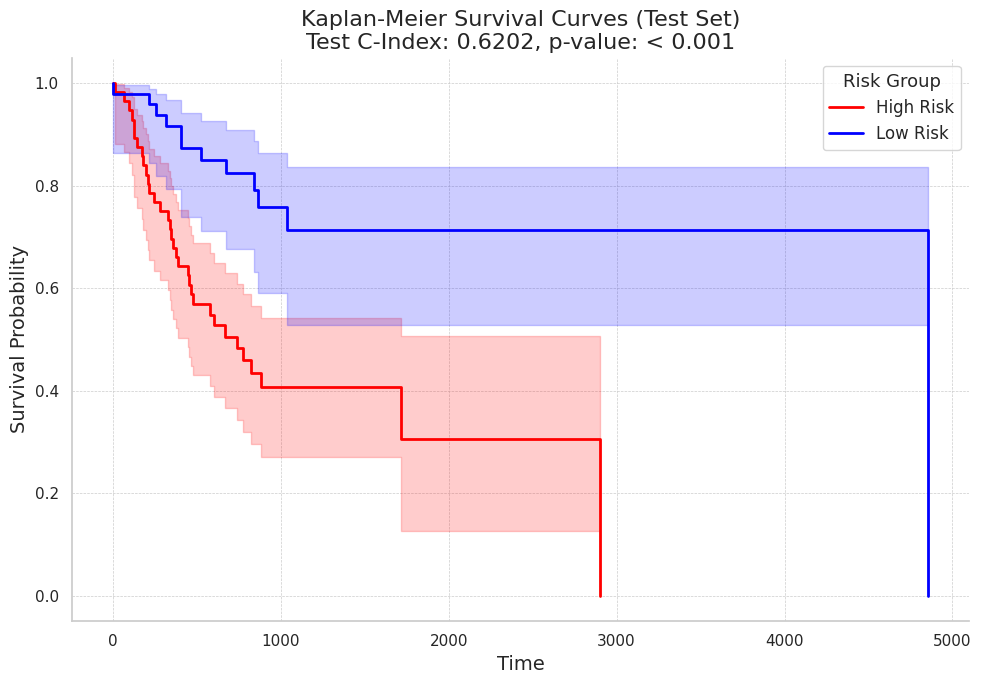

In [30]:
# -------------------------------------------
# Additional Imports Needed
# -------------------------------------------
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# -------------------------------------------
# Optimal Threshold Selection and Kaplan-Meier Plotting for Test Set
# -------------------------------------------

print("\nOptimal Threshold Selection and Kaplan-Meier Plotting for Test Set with Group Size Restriction...\n")

# Prepare data
risk_scores_test = risk_test  # Risk scores from the model on test set
durations_test = durations_test  # Durations on test set
events_test = events_test.astype(bool)  # Events on test set

# Use negative risk scores for proper ordering in concordance index calculation
# This is consistent with your base script
c_index_test = concordance_index_censored(
    events_test,
    durations_test,
    -risk_scores_test  # Use negative risk scores
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# Search for the optimal threshold
unique_risk_scores_test = np.sort(np.unique(risk_scores_test))

# Initialize variables
best_threshold_test = None
min_p_value_test = 1.0

# Minimum group size (at least 25% of patients in each group)
total_patients = len(risk_scores_test)
min_group_size = total_patients * 0.25

# For each possible threshold, compute the log-rank test p-value
for threshold in unique_risk_scores_test[1:-1]:
    # Assign patients to groups
    is_high_risk = risk_scores_test <= threshold  # High risk have lower risk scores
    is_low_risk = risk_scores_test > threshold

    # Calculate group sizes
    group_high_size = is_high_risk.sum()
    group_low_size = is_low_risk.sum()

    # Ensure each group has at least the minimum number of patients
    if group_high_size < min_group_size or group_low_size < min_group_size:
        continue  # Skip thresholds that result in small groups

    # Check if both groups have events
    if events_test[is_high_risk].sum() == 0 or events_test[is_low_risk].sum() == 0:
        continue  # Skip thresholds where one group has no events

    # Perform log-rank test
    results_test = logrank_test(
        durations_test[is_high_risk],
        durations_test[is_low_risk],
        event_observed_A=events_test[is_high_risk],
        event_observed_B=events_test[is_low_risk]
    )
    p_value_test = results_test.p_value

    # Update the best threshold if p-value is lower
    if p_value_test < min_p_value_test:
        min_p_value_test = p_value_test
        best_threshold_test = threshold

# Check if a valid threshold was found
if best_threshold_test is None:
    print("No valid threshold found that satisfies the group size restriction.")
else:
    # Assign patients to groups based on the best threshold
    is_high_risk = risk_scores_test <= best_threshold_test  # High risk have lower risk scores
    is_low_risk = risk_scores_test > best_threshold_test

    # Confirm that the high-risk group has shorter survival times
    median_survival_high = np.median(durations_test[is_high_risk])
    median_survival_low = np.median(durations_test[is_low_risk])

    print(f"Median survival time - High Risk: {median_survival_high}")
    print(f"Median survival time - Low Risk: {median_survival_low}")

    # Ensure high-risk group has shorter survival times
    if median_survival_high >= median_survival_low:
        print("Warning: High-risk group does not have shorter median survival time compared to low-risk group.")
        # You may choose to investigate further or adjust the thresholding method

    print(f"Optimal threshold for risk score on test set: {best_threshold_test:.4f}")

    # Format p-value as per your request
    if min_p_value_test < 0.001:
        p_value_formatted = "< 0.001"
    else:
        p_value_formatted = f"{min_p_value_test:.3f}"
    print(f"Minimum p-value from log-rank test on test set: {p_value_formatted}")

    # Create a DataFrame for plotting
    test_data = pd.DataFrame({
        'duration': durations_test,
        'event': events_test,
        'group': np.where(is_high_risk, 'High Risk', 'Low Risk')
    })

    # Kaplan-Meier fitting and plotting using Seaborn
    kmf_high_test = KaplanMeierFitter()
    kmf_low_test = KaplanMeierFitter()

    plt.figure(figsize=(10, 7))

    # Fit the models
    kmf_high_test.fit(
        test_data['duration'][test_data['group'] == 'High Risk'],
        event_observed=test_data['event'][test_data['group'] == 'High Risk'],
        label='High Risk'
    )
    kmf_low_test.fit(
        test_data['duration'][test_data['group'] == 'Low Risk'],
        event_observed=test_data['event'][test_data['group'] == 'Low Risk'],
        label='Low Risk'
    )

    # Plot the survival curves with confidence intervals (error bands)
    ax = kmf_high_test.plot(ci_show=True, ci_alpha=0.2, linewidth=2, color='red')
    kmf_low_test.plot(ax=ax, ci_show=True, ci_alpha=0.2, linewidth=2, color='blue')

    # Customize the plot using Seaborn aesthetics
    sns.despine()

    # Add c-index and p-value to the plot
    plt.title('Kaplan-Meier Survival Curves (Test Set)\nTest C-Index: {:.4f}, p-value: {}'.format(c_index_test, p_value_formatted), fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Survival Probability', fontsize=14)
    plt.legend(title='Risk Group', fontsize=12, title_fontsize=13)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


FEATURE PERMUTATION IMPORTANCE

In [22]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random
import json

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes_id' is your input DataFrame
# Replace this with the actual DataFrame variable if different
clinical_data_test = clinical_data_yes_id.copy()

# Path to the JSON file containing survival data (assumed to contain WSI embeddings)
json_path = 'svs_patient_map_PFI.json'  # Replace with your actual path if different

# Check if JSON file exists
if not os.path.exists(json_path):
    raise FileNotFoundError(f"The JSON file '{json_path}' was not found.")

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
wsi_df = pd.DataFrame(survival_entries)

# Verify that 'file_name' column exists
if 'file_name' not in wsi_df.columns:
    raise KeyError("'file_name' column not found in the JSON data.")

# Extract 'patient.bcr_patient_barcode' by taking the first 12 characters of 'file_name'
def extract_barcode(file_name):
    """
    Extracts the 'patient.bcr_patient_barcode' from the 'file_name'.
    Assumes that 'file_name' starts with the barcode, e.g., 'TCGA-UF-A71E_flatten.pt'
    """
    return file_name[:12]

wsi_df['patient.bcr_patient_barcode'] = wsi_df['file_name'].apply(extract_barcode)

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
wsi_df['patient.bcr_patient_barcode'] = wsi_df['patient.bcr_patient_barcode'].astype(str)

# Adjust the filtering condition based on your actual data structure
wsi_df = wsi_df[wsi_df['file_name'].str.contains('DX1', case=False, na=False)].reset_index(drop=True)

# Store the initial row count of clinical_data_test
initial_row_count = clinical_data_test.shape[0]

# Filter clinical_data_test to keep only rows where "patient.bcr_patient_barcode" values exist in wsi_df
clinical_data_test_filtered = clinical_data_test[
    clinical_data_test["patient.bcr_patient_barcode"].isin(wsi_df["patient.bcr_patient_barcode"])
]

clinical_data_test = clinical_data_test_filtered
clinical_data_test = clinical_data_test.drop(columns=['patient.bcr_patient_barcode'])

# Store the final row count after filtering
final_row_count = clinical_data_test.shape[0]

# Print the results
print("Total rows BEFORE:", initial_row_count)
print("Total rows AFTER:", final_row_count)

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'age_of_patient',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage',
    'HPV load'
]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'HPV load'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Prepare Survival Data
# -------------------------------------------

# Fill NaN values in 'PFI.time' with the mean
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)

# Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

time_copy = time.copy()
event_copy = event.copy()

# -------------------------------------------
# Feature Engineering
# -------------------------------------------

# Scale numerical features
scaler = StandardScaler()
scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

# Convert scaled numerical features back to DataFrame for compatibility
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

# Combine scaled numerical features and categorical features into a single DataFrame
X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

X_copy = X.copy()

# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, event))
X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
y_train_event, y_test_event = event[train_idx], event[test_idx]
y_train_time, y_test_time = time[train_idx], time[test_idx]

# -------------------------------------------
# Preparing Data for FTTransformer
# -------------------------------------------

# Identify numerical and categorical columns after preprocessing
categorical_columns = list(categorical_cols)
numerical_columns = num_cols

# Prepare data for FTTransformer
def prepare_data(X, categorical_columns, numerical_columns):
    # For categorical features
    cat_features = X[categorical_columns]
    # For numerical features
    num_features = X[numerical_columns]
    return cat_features, num_features

X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

# -------------------------------------------
# Convert Data to PyTorch Tensors
# -------------------------------------------

# Convert data to torch tensors
def to_tensor(x, dtype):
    return torch.tensor(x.values, dtype=dtype)

X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
X_train_num_tensor = to_tensor(X_train_num, torch.float32)
X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
X_test_num_tensor = to_tensor(X_test_num, torch.float32)

# -------------------------------------------
# Initialize FTTransformer (Pretrained)
# -------------------------------------------

# Get the number of unique categories for each categorical column
categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

# Instantiate the FTTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ft_transformer = FTTransformer(
    categories=categories,                              # List of unique category counts
    num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
    dim=192,                                            # Embedding dimension size, adjust as needed
    depth=6,                                            # Number of transformer layers
    heads=8,                                            # Number of attention heads
    attn_dropout=0.1,                                   # Dropout for attention layers
    ff_dropout=0.1                                      # Dropout for feedforward layers
).to(device)

# Load pretrained weights if available
# Uncomment and modify the following line if you have pretrained weights
# ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

# Set the model to evaluation mode
ft_transformer.eval()

# -------------------------------------------
# Generating Embeddings
# -------------------------------------------

def get_embeddings(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
        numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
        embeddings = model(categorical, numerical, return_embedding=True)
        return embeddings.cpu().numpy()

# Generate embeddings for training and test sets
train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

# Verify the shape of the embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Initialize the MLPVanilla model with reduced input features
net = tt.practical.MLPVanilla(
    in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
    num_nodes=num_nodes,
    out_features=out_features,
    batch_norm=batch_norm,
    dropout=dropout,
    output_bias=output_bias
)

# Initialize the CoxPH model with the network and optimizer
optimizer = tt.optim.Adam(lr=1e-3)
cox_ph = CoxPH(net, optimizer)

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
durations_train = y_train_time.astype(np.float32)
events_train = y_train_event.astype(np.int64)

# Ensure embeddings are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = train_embeddings[train_idx_cv]
    y_train_cv_durations = durations_train[train_idx_cv]
    y_train_cv_events = events_train[train_idx_cv]
    
    X_val_cv = train_embeddings[val_idx_cv]
    y_val_cv_durations = durations_train[val_idx_cv]
    y_val_cv_events = events_train[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
    
    # Initialize a new instance of the network for each fold to avoid weight sharing
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    c_index = concordance_index_censored(
        y_val_cv_events.astype(bool),
        y_val_cv_durations,
        -risk_val  # Use negative risk for proper ordering
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("\nTraining Final CoxPH Model on Entire Training Set...\n")

# Ensure arrays are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)
durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
events_train = np.ascontiguousarray(events_train, dtype=np.int64)

# Fit the final model on the entire training set
cox_ph.fit(
    train_embeddings,
    (events_train, durations_train),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("\nEvaluating on Test Set...\n")

# Prepare test data
durations_test = y_test_time.astype(np.float32)
events_test = y_test_event.astype(np.int64)
test_embeddings = np.ascontiguousarray(test_embeddings, dtype=np.float32)

# Predict risk scores on test set
risk_test = cox_ph.predict(test_embeddings).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    events_test.astype(bool),
    durations_test,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(test_embeddings), size=len(test_embeddings), replace=True)
    X_test_bs = test_embeddings[indices]
    durations_test_bs = durations_test[indices]
    events_test_bs = events_test[indices]
    
    # Predict risk scores
    risk_bs = cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs.astype(bool),
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")

# -------------------------------------------
# Feature Permutation Importance Analysis
# -------------------------------------------

print("\nStarting Feature Permutation Importance Analysis...\n")

# Combine numerical and categorical columns for permutation importance analysis
all_features = numerical_columns + categorical_columns

# Initialize a dictionary to store results
permutation_results = {}

# Number of permutations
n_permutations = 100

# Iterate through each feature
for feature in all_features:
    print(f"Analyzing Feature: {feature}")
    
    # Store permuted C-Index scores for cross-validation and test set
    permuted_c_indices_cv = []
    permuted_c_indices_test = []
    
    # -------------------------
    # Cross-Validation Permutation Importance
    # -------------------------
    
    print(f"Starting Cross-Validation Permutation for {feature}...\n")
    
    c_indices_cv = []
    
    for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
        print(f"Feature: {feature} | Fold {fold + 1}")
        
        # Split data
        X_train_cv = train_embeddings[train_idx_cv]
        y_train_cv_durations = durations_train[train_idx_cv]
        y_train_cv_events = events_train[train_idx_cv]
        
        X_val_cv = train_embeddings[val_idx_cv]
        y_val_cv_durations = durations_train[val_idx_cv]
        y_val_cv_events = events_train[val_idx_cv]
        
        # Initialize a new instance of the network for each fold to avoid weight sharing
        net_cv = tt.practical.MLPVanilla(
            in_features=train_embeddings.shape[1],
            num_nodes=num_nodes,
            out_features=out_features,
            batch_norm=batch_norm,
            dropout=dropout,
            output_bias=output_bias
        )
        
        # Initialize CoxPH model for this fold
        optimizer_cv = tt.optim.Adam(lr=1e-3)
        cox_ph_cv = CoxPH(net_cv, optimizer_cv)
        
        # Fit the model
        cox_ph_cv.fit(
            X_train_cv,
            (y_train_cv_events, y_train_cv_durations),
            batch_size=64,
            epochs=100,
            verbose=False
        )
        
        # Prepare validation data
        X_val_df_cv = X.iloc[val_idx_cv].copy()
        y_val_cv_events = events_train[val_idx_cv]
        y_val_cv_durations = durations_train[val_idx_cv]
        
        # Baseline risk scores on validation set
        val_embeddings = X_val_cv
        risk_val_baseline = cox_ph_cv.predict(val_embeddings).squeeze()
        
        # Compute baseline C-Index on validation set
        c_index_val_baseline = concordance_index_censored(
            y_val_cv_events.astype(bool),
            y_val_cv_durations,
            -risk_val_baseline  # Use negative risk for proper ordering
        )[0]
        
        # Store C-Index differences for permutations in this fold
        c_index_diffs_cv = []
        
        for i in range(n_permutations):
            # Permute the feature in validation set
            X_val_df_cv_permuted = X_val_df_cv.copy()
            X_val_df_cv_permuted[feature] = np.random.permutation(X_val_df_cv_permuted[feature].values)
            
            # Prepare data for FTTransformer
            X_val_cat_cv_perm, X_val_num_cv_perm = prepare_data(X_val_df_cv_permuted, categorical_columns, numerical_columns)
            
            # Convert data to tensors
            X_val_cat_tensor_cv_perm = to_tensor(X_val_cat_cv_perm, torch.long)
            X_val_num_tensor_cv_perm = to_tensor(X_val_num_cv_perm, torch.float32)
            
            # Generate embeddings
            val_embeddings_perm = get_embeddings(ft_transformer, X_val_cat_cv_perm, X_val_num_cv_perm)
            
            # Predict risk scores
            risk_val_perm = cox_ph_cv.predict(val_embeddings_perm).squeeze()
            
            # Compute C-Index
            c_index_val_perm = concordance_index_censored(
                y_val_cv_events.astype(bool),
                y_val_cv_durations,
                -risk_val_perm  # Use negative risk for proper ordering
            )[0]
            
            # Compute decrease in C-Index
            c_index_diff = c_index_val_baseline - c_index_val_perm
            c_index_diffs_cv.append(c_index_diff)
            
            # Optional: Print progress every 20 permutations
            if (i + 1) % 20 == 0:
                print(f"Feature: {feature} | Fold {fold + 1} | Permutation {i + 1}/{n_permutations} completed.")
        
        # Calculate mean decrease in C-Index for this fold
        mean_c_index_diff_cv = np.mean(c_index_diffs_cv)
        permuted_c_indices_cv.extend(c_index_diffs_cv)
        
        print(f"Feature: {feature} | Fold {fold + 1} | Mean Decrease in C-Index: {mean_c_index_diff_cv:.4f}\n")
    
    # Calculate overall statistics for cross-validation
    mean_c_index_diff_cv_overall = np.mean(permuted_c_indices_cv)
    std_c_index_diff_cv_overall = np.std(permuted_c_indices_cv)
    ci_lower_cv = np.percentile(permuted_c_indices_cv, 2.5)
    ci_upper_cv = np.percentile(permuted_c_indices_cv, 97.5)
    
    # -------------------------
    # Test Set Permutation Importance
    # -------------------------
    
    print(f"Starting Test Set Permutation for {feature}...\n")
    
    # Baseline risk scores on test set
    risk_test_baseline = risk_test
    c_index_test_baseline = c_index_test
    
    # Store C-Index differences for permutations on test set
    c_index_diffs_test = []
    
    for i in range(n_permutations):
        # Permute the feature in test set
        X_test_df_permuted = X_test_df.copy()
        X_test_df_permuted[feature] = np.random.permutation(X_test_df_permuted[feature].values)
        
        # Prepare data for FTTransformer
        X_test_cat_perm, X_test_num_perm = prepare_data(X_test_df_permuted, categorical_columns, numerical_columns)
        X_test_cat_tensor_perm = to_tensor(X_test_cat_perm, torch.long)
        X_test_num_tensor_perm = to_tensor(X_test_num_perm, torch.float32)
        
        # Generate embeddings
        test_embeddings_perm = get_embeddings(ft_transformer, X_test_cat_perm, X_test_num_perm)
        
        # Predict risk scores
        risk_test_perm = cox_ph.predict(test_embeddings_perm).squeeze()
        
        # Compute C-Index
        c_index_test_perm = concordance_index_censored(
            events_test.astype(bool),
            durations_test,
            -risk_test_perm  # Use negative risk for proper ordering
        )[0]
        
        # Compute decrease in C-Index
        c_index_diff = c_index_test_baseline - c_index_test_perm
        c_index_diffs_test.append(c_index_diff)
        
        # Optional: Print progress every 20 permutations
        if (i + 1) % 20 == 0:
            print(f"Feature: {feature} | Test Set | Permutation {i + 1}/{n_permutations} completed.")
    
    # Calculate overall statistics for test set
    mean_c_index_diff_test = np.mean(c_index_diffs_test)
    std_c_index_diff_test = np.std(c_index_diffs_test)
    ci_lower_test = np.percentile(c_index_diffs_test, 2.5)
    ci_upper_test = np.percentile(c_index_diffs_test, 97.5)
    
    print(f"Feature: {feature} | Test Set | Mean Decrease in C-Index: {mean_c_index_diff_test:.4f}\n")
    
    # Store the results
    permutation_results[feature] = {
        'Cross_Validation_Mean_Decrease': mean_c_index_diff_cv_overall,
        'Cross_Validation_STD': std_c_index_diff_cv_overall,
        'Cross_Validation_CI_Lower': ci_lower_cv,
        'Cross_Validation_CI_Upper': ci_upper_cv,
        'Test_Mean_Decrease': mean_c_index_diff_test,
        'Test_STD': std_c_index_diff_test,
        'Test_CI_Lower': ci_lower_test,
        'Test_CI_Upper': ci_upper_test
    }

print("\nFeature Permutation Importance Analysis Completed.\n")

# Optionally, convert the results to a DataFrame for better visualization
permutation_results_df = pd.DataFrame(permutation_results).T

# Save the results to a CSV file
permutation_results_df.to_csv('permutation_importance_results.csv')

print("Permutation Importance Results:")
print(permutation_results_df)
print("\nResults saved to 'permutation_importance_results.csv'")


/home/sorkwos/HIPT_Embedding_Env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total rows BEFORE: 528
Total rows AFTER: 450
FTTransformer
Train Embeddings Shape: (360, 192)
Test Embeddings Shape: (90, 192)

Starting 5-Fold Cross-Validation...

Fold 1
Fold 1 C-Index: 0.5959

Fold 2
Fold 2 C-Index: 0.6200

Fold 3
Fold 3 C-Index: 0.4657

Fold 4
Fold 4 C-Index: 0.5960

Fold 5
Fold 5 C-Index: 0.5668

Cross-Validation C-Index: 0.5689 ± 0.0543
95% Confidence Interval: [0.4758, 0.6176]

Training Final CoxPH Model on Entire Training Set...

Final CoxPH Model Trained Successfully.

Evaluating on Test Set...

Test C-Index: 0.6992

Starting Bootstrapping for Test C-Index Uncertainty...

Bootstrap 100/1000 completed.
Bootstrap 200/1000 completed.
Bootstrap 300/1000 completed.
Bootstrap 400/1000 completed.
Bootstrap 500/1000 completed.
Bootstrap 600/1000 completed.
Bootstrap 700/1000 completed.
Bootstrap 800/1000 completed.
Bootstrap 900/1000 completed.
Bootstrap 1000/1000 completed.

Test C-Index with Bootstrapping: 0.7003 ± 0.0465
95% Confidence Interval: [0.6079, 0.7900]

S

LEAVE ONE OUT STRATEGY

In [23]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random
import json

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes_id' is your input DataFrame
# Replace this with the actual DataFrame variable if different
clinical_data_test = clinical_data_yes_id.copy()

# Path to the JSON file containing survival data (assumed to contain WSI embeddings)
json_path = 'svs_patient_map_PFI.json'  # Replace with your actual path if different

# Check if JSON file exists
if not os.path.exists(json_path):
    raise FileNotFoundError(f"The JSON file '{json_path}' was not found.")

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
wsi_df = pd.DataFrame(survival_entries)

# Verify that 'file_name' column exists
if 'file_name' not in wsi_df.columns:
    raise KeyError("'file_name' column not found in the JSON data.")

# Extract 'patient.bcr_patient_barcode' by taking the first 12 characters of 'file_name'
def extract_barcode(file_name):
    """
    Extracts the 'patient.bcr_patient_barcode' from the 'file_name'.
    Assumes that 'file_name' starts with the barcode, e.g., 'TCGA-UF-A71E_flatten.pt'
    """
    return file_name[:12]

wsi_df['patient.bcr_patient_barcode'] = wsi_df['file_name'].apply(extract_barcode)

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
wsi_df['patient.bcr_patient_barcode'] = wsi_df['patient.bcr_patient_barcode'].astype(str)

# Adjust the filtering condition based on your actual data structure
wsi_df = wsi_df[wsi_df['file_name'].str.contains('DX1', case=False, na=False)].reset_index(drop=True)

# Store the initial row count of clinical_data_test
initial_row_count = clinical_data_test.shape[0]

# Filter clinical_data_test to keep only rows where "patient.bcr_patient_barcode" values exist in wsi_df
clinical_data_test_filtered = clinical_data_test[
    clinical_data_test["patient.bcr_patient_barcode"].isin(wsi_df["patient.bcr_patient_barcode"])
]

clinical_data_test = clinical_data_test_filtered
clinical_data_test = clinical_data_test.drop(columns=['patient.bcr_patient_barcode'])

# Store the final row count after filtering
final_row_count = clinical_data_test.shape[0]

# Print the results
print("Total rows BEFORE:", initial_row_count)
print("Total rows AFTER:", final_row_count)

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'age_of_patient',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage',
    'HPV load'
]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'HPV load'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Prepare Survival Data
# -------------------------------------------

# Fill NaN values in 'PFI.time' with the mean
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)

# Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

time_copy = time.copy()
event_copy = event.copy()

# -------------------------------------------
# Feature Engineering
# -------------------------------------------

# Scale numerical features
scaler = StandardScaler()
scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

# Convert scaled numerical features back to DataFrame for compatibility
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

# Combine scaled numerical features and categorical features into a single DataFrame
X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

X_copy = X.copy()

# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, event))
X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
y_train_event, y_test_event = event[train_idx], event[test_idx]
y_train_time, y_test_time = time[train_idx], time[test_idx]

# -------------------------------------------
# Preparing Data for FTTransformer
# -------------------------------------------

# Identify numerical and categorical columns after preprocessing
categorical_columns = list(categorical_cols)
numerical_columns = num_cols

# Prepare data for FTTransformer
def prepare_data(X, categorical_columns, numerical_columns):
    # For categorical features
    cat_features = X[categorical_columns]
    # For numerical features
    num_features = X[numerical_columns]
    return cat_features, num_features

X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

# -------------------------------------------
# Convert Data to PyTorch Tensors
# -------------------------------------------

# Convert data to torch tensors
def to_tensor(x, dtype):
    return torch.tensor(x.values, dtype=dtype)

X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
X_train_num_tensor = to_tensor(X_train_num, torch.float32)
X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
X_test_num_tensor = to_tensor(X_test_num, torch.float32)

# -------------------------------------------
# Initialize FTTransformer (Pretrained)
# -------------------------------------------

# Get the number of unique categories for each categorical column
categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

# Instantiate the FTTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ft_transformer = FTTransformer(
    categories=categories,                              # List of unique category counts
    num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
    dim=192,                                            # Embedding dimension size, adjust as needed
    depth=6,                                            # Number of transformer layers
    heads=8,                                            # Number of attention heads
    attn_dropout=0.1,                                   # Dropout for attention layers
    ff_dropout=0.1                                      # Dropout for feedforward layers
).to(device)

# Load pretrained weights if available
# Uncomment and modify the following line if you have pretrained weights
# ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

# Set the model to evaluation mode
ft_transformer.eval()

# -------------------------------------------
# Generating Embeddings
# -------------------------------------------

def get_embeddings(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
        numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
        embeddings = model(categorical, numerical, return_embedding=True)
        return embeddings.cpu().numpy()

# Generate embeddings for training and test sets
train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

# Verify the shape of the embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Initialize the MLPVanilla model with reduced input features
net = tt.practical.MLPVanilla(
    in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
    num_nodes=num_nodes,
    out_features=out_features,
    batch_norm=batch_norm,
    dropout=dropout,
    output_bias=output_bias
)

# Initialize the CoxPH model with the network and optimizer
optimizer = tt.optim.Adam(lr=1e-3)
cox_ph = CoxPH(net, optimizer)

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
durations_train = y_train_time.astype(np.float32)
events_train = y_train_event.astype(np.int64)

# Ensure embeddings are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = train_embeddings[train_idx_cv]
    y_train_cv_durations = durations_train[train_idx_cv]
    y_train_cv_events = events_train[train_idx_cv]
    
    X_val_cv = train_embeddings[val_idx_cv]
    y_val_cv_durations = durations_train[val_idx_cv]
    y_val_cv_events = events_train[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
    
    # Initialize a new instance of the network for each fold to avoid weight sharing
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    c_index = concordance_index_censored(
        y_val_cv_events.astype(bool),
        y_val_cv_durations,
        -risk_val  # Use negative risk for proper ordering
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("\nTraining Final CoxPH Model on Entire Training Set...\n")

# Ensure arrays are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)
durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
events_train = np.ascontiguousarray(events_train, dtype=np.int64)

# Fit the final model on the entire training set
cox_ph.fit(
    train_embeddings,
    (events_train, durations_train),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("\nEvaluating on Test Set...\n")

# Prepare test data
durations_test = y_test_time.astype(np.float32)
events_test = y_test_event.astype(np.int64)
test_embeddings = np.ascontiguousarray(test_embeddings, dtype=np.float32)

# Predict risk scores on test set
risk_test = cox_ph.predict(test_embeddings).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    events_test.astype(bool),
    durations_test,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(test_embeddings), size=len(test_embeddings), replace=True)
    X_test_bs = test_embeddings[indices]
    durations_test_bs = durations_test[indices]
    events_test_bs = events_test[indices]
    
    # Predict risk scores
    risk_bs = cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs.astype(bool),
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")

# -------------------------------------------
# Leave-One-Out Feature Importance Analysis
# -------------------------------------------

print("\nStarting Leave-One-Out Feature Importance Analysis...\n")

# Combine numerical and categorical columns for analysis
all_features = numerical_columns + categorical_columns

# Initialize a dictionary to store results
leave_one_out_results = {}

# Iterate through each feature
for feature in all_features:
    print(f"Analyzing Feature: {feature}")
    
    # -------------------------
    # Prepare Data Without the Feature
    # -------------------------
    
    # Remove the feature from the datasets
    X_train_df_loo = X_train_df.drop(columns=[feature])
    X_test_df_loo = X_test_df.drop(columns=[feature])
    
    # Update the categorical and numerical columns
    if feature in categorical_columns:
        categorical_columns_loo = [col for col in categorical_columns if col != feature]
        numerical_columns_loo = numerical_columns
    else:
        categorical_columns_loo = categorical_columns
        numerical_columns_loo = [col for col in numerical_columns if col != feature]
    
    # Prepare data for FTTransformer
    X_train_cat_loo, X_train_num_loo = prepare_data(X_train_df_loo, categorical_columns_loo, numerical_columns_loo)
    X_test_cat_loo, X_test_num_loo = prepare_data(X_test_df_loo, categorical_columns_loo, numerical_columns_loo)
    
    # Convert data to tensors
    X_train_cat_tensor_loo = to_tensor(X_train_cat_loo, torch.long)
    X_train_num_tensor_loo = to_tensor(X_train_num_loo, torch.float32)
    X_test_cat_tensor_loo = to_tensor(X_test_cat_loo, torch.long)
    X_test_num_tensor_loo = to_tensor(X_test_num_loo, torch.float32)
    
    # -------------------------------------------
    # Initialize FTTransformer for Leave-One-Out
    # -------------------------------------------
    
    # Get the number of unique categories for each categorical column
    categories_loo = [int(X_train_cat_loo[col].max() + 1) for col in categorical_columns_loo]
    
    # Instantiate the FTTransformer model
    ft_transformer_loo = FTTransformer(
        categories=categories_loo,                              # List of unique category counts
        num_continuous=X_train_num_tensor_loo.shape[1],         # Number of continuous features
        dim=192,                                                # Embedding dimension size, adjust as needed
        depth=6,                                                # Number of transformer layers
        heads=8,                                                # Number of attention heads
        attn_dropout=0.1,                                       # Dropout for attention layers
        ff_dropout=0.1                                          # Dropout for feedforward layers
    ).to(device)
    
    # Set the model to evaluation mode
    ft_transformer_loo.eval()
    
    # -------------------------------------------
    # Generating Embeddings for Leave-One-Out
    # -------------------------------------------
    
    # Generate embeddings for training and test sets
    train_embeddings_loo = get_embeddings(ft_transformer_loo, X_train_cat_loo, X_train_num_loo)
    test_embeddings_loo = get_embeddings(ft_transformer_loo, X_test_cat_loo, X_test_num_loo)
    
    # Ensure embeddings are contiguous
    train_embeddings_loo = np.ascontiguousarray(train_embeddings_loo, dtype=np.float32)
    
    # Prepare survival data
    durations_train = y_train_time.astype(np.float32)
    events_train = y_train_event.astype(np.int64)
    
    # -------------------------
    # CoxPH Analysis with 5-Fold Cross-Validation
    # -------------------------
    
    c_index_scores_loo = []
    
    print(f"Starting 5-Fold Cross-Validation without {feature}...\n")
    
    for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings_loo)):
        print(f"Feature: {feature} | Fold {fold + 1}")
        
        # Split data
        X_train_cv = train_embeddings_loo[train_idx_cv]
        y_train_cv_durations = durations_train[train_idx_cv]
        y_train_cv_events = events_train[train_idx_cv]
        
        X_val_cv = train_embeddings_loo[val_idx_cv]
        y_val_cv_durations = durations_train[val_idx_cv]
        y_val_cv_events = events_train[val_idx_cv]
        
        # Ensure arrays are contiguous
        X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
        y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
        y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
        
        # Initialize a new instance of the network for each fold to avoid weight sharing
        net_cv = tt.practical.MLPVanilla(
            in_features=train_embeddings_loo.shape[1],
            num_nodes=num_nodes,
            out_features=out_features,
            batch_norm=batch_norm,
            dropout=dropout,
            output_bias=output_bias
        )
        
        # Initialize CoxPH model for this fold
        optimizer_cv = tt.optim.Adam(lr=1e-3)
        cox_ph_cv = CoxPH(net_cv, optimizer_cv)
        
        # Fit the model
        cox_ph_cv.fit(
            X_train_cv,
            (y_train_cv_events, y_train_cv_durations),
            batch_size=64,
            epochs=100,
            verbose=False
        )
        
        # Predict risk scores on validation set
        risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
        
        # Compute C-Index
        c_index = concordance_index_censored(
            y_val_cv_events.astype(bool),
            y_val_cv_durations,
            -risk_val  # Use negative risk for proper ordering
        )[0]
        
        print(f"Feature: {feature} | Fold {fold + 1} C-Index: {c_index:.4f}\n")
        
        c_index_scores_loo.append(c_index)
    
    # Calculate Cross-Validation Mean and Uncertainty
    c_index_mean_loo = np.mean(c_index_scores_loo)
    c_index_std_loo = np.std(c_index_scores_loo)
    c_index_ci_lower_loo = np.percentile(c_index_scores_loo, 2.5)
    c_index_ci_upper_loo = np.percentile(c_index_scores_loo, 97.5)
    
    print(f"Feature: {feature} | Cross-Validation C-Index without Feature: {c_index_mean_loo:.4f} ± {c_index_std_loo:.4f}")
    print(f"Feature: {feature} | 95% Confidence Interval: [{c_index_ci_lower_loo:.4f}, {c_index_ci_upper_loo:.4f}]\n")
    
    # -------------------------
    # Train Final CoxPH Model on Entire Training Set without the Feature
    # -------------------------
    
    # Initialize the MLPVanilla model
    net_loo = tt.practical.MLPVanilla(
        in_features=train_embeddings_loo.shape[1],  # Number of input features (embedding dimension)
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize the CoxPH model with the network and optimizer
    optimizer_loo = tt.optim.Adam(lr=1e-3)
    cox_ph_loo = CoxPH(net_loo, optimizer_loo)
    
    # Fit the model on the entire training set without the feature
    cox_ph_loo.fit(
        train_embeddings_loo,
        (events_train, durations_train),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # -------------------------
    # Evaluate on Test Set without the Feature
    # -------------------------
    
    print(f"Evaluating on Test Set without {feature}...\n")
    
    # Prepare test data
    durations_test = y_test_time.astype(np.float32)
    events_test = y_test_event.astype(np.int64)
    test_embeddings_loo = np.ascontiguousarray(test_embeddings_loo, dtype=np.float32)
    
    # Predict risk scores on test set
    risk_test_loo = cox_ph_loo.predict(test_embeddings_loo).squeeze()
    
    # Compute C-Index on Test Set
    c_index_test_loo = concordance_index_censored(
        events_test.astype(bool),
        durations_test,
        -risk_test_loo  # Use negative risk for proper ordering
    )[0]
    
    print(f"Feature: {feature} | Test C-Index without Feature: {c_index_test_loo:.4f}")
    
    # Bootstrapping for Test C-Index Uncertainty without the Feature
    n_bootstraps_loo = 1000
    c_index_bootstrap_loo = []
    
    print(f"Feature: {feature} | Starting Bootstrapping for Test C-Index Uncertainty without Feature...\n")
    
    for i_loo in range(n_bootstraps_loo):
        # Resample test set with replacement
        indices_loo = np.random.choice(len(test_embeddings_loo), size=len(test_embeddings_loo), replace=True)
        X_test_bs_loo = test_embeddings_loo[indices_loo]
        durations_test_bs_loo = durations_test[indices_loo]
        events_test_bs_loo = events_test[indices_loo]
        
        # Predict risk scores
        risk_bs_loo = cox_ph_loo.predict(X_test_bs_loo).squeeze()
        
        # Compute C-Index
        c_index_bs_loo = concordance_index_censored(
            events_test_bs_loo.astype(bool),
            durations_test_bs_loo,
            -risk_bs_loo  # Use negative risk for proper ordering
        )[0]
        
        c_index_bootstrap_loo.append(c_index_bs_loo)
        
        # Optional: Print progress every 100 iterations
        if (i_loo + 1) % 100 == 0:
            print(f"Feature: {feature} | Bootstrap {i_loo + 1}/{n_bootstraps_loo} completed.")
    
    # Calculate Bootstrapped C-Index Statistics without the Feature
    c_index_test_mean_loo = np.mean(c_index_bootstrap_loo)
    c_index_test_std_loo = np.std(c_index_bootstrap_loo)
    c_index_test_ci_lower_loo = np.percentile(c_index_bootstrap_loo, 2.5)
    c_index_test_ci_upper_loo = np.percentile(c_index_bootstrap_loo, 97.5)
    
    print(f"Feature: {feature} | Test C-Index without Feature (Bootstrapped): {c_index_test_mean_loo:.4f} ± {c_index_test_std_loo:.4f}")
    print(f"Feature: {feature} | 95% Confidence Interval: [{c_index_test_ci_lower_loo:.4f}, {c_index_test_ci_upper_loo:.4f}]\n")
    
    # -------------------------
    # Calculate Performance Decrease
    # -------------------------
    
    # Difference in C-Index for Cross-Validation
    c_index_diff_cv = c_index_mean - c_index_mean_loo
    
    # Difference in C-Index for Test Set
    c_index_diff_test = c_index_test_mean - c_index_test_mean_loo  # Use bootstrapped means
    
    # Store the results
    leave_one_out_results[feature] = {
        'CV_C_Index_With_Feature_Mean': c_index_mean,
        'CV_C_Index_With_Feature_STD': c_index_std,
        'CV_CI_With_Feature_Lower': c_index_ci_lower,
        'CV_CI_With_Feature_Upper': c_index_ci_upper,
        'CV_C_Index_Without_Feature_Mean': c_index_mean_loo,
        'CV_C_Index_Without_Feature_STD': c_index_std_loo,
        'CV_CI_Without_Feature_Lower': c_index_ci_lower_loo,
        'CV_CI_Without_Feature_Upper': c_index_ci_upper_loo,
        'CV_C_Index_Difference': c_index_diff_cv,
        'Test_C_Index_With_Feature_Mean': c_index_test_mean,
        'Test_C_Index_With_Feature_STD': c_index_test_std,
        'Test_CI_With_Feature_Lower': c_index_test_ci_lower,
        'Test_CI_With_Feature_Upper': c_index_test_ci_upper,
        'Test_C_Index_Without_Feature_Mean': c_index_test_mean_loo,
        'Test_C_Index_Without_Feature_STD': c_index_test_std_loo,
        'Test_CI_Without_Feature_Lower': c_index_test_ci_lower_loo,
        'Test_CI_Without_Feature_Upper': c_index_test_ci_upper_loo,
        'Test_C_Index_Difference': c_index_diff_test
    }

print("\nLeave-One-Out Feature Importance Analysis Completed.\n")

# Optionally, convert the results to a DataFrame for better visualization
leave_one_out_results_df = pd.DataFrame(leave_one_out_results).T

# Save the results to a CSV file
leave_one_out_results_df.to_csv('leave_one_out_results.csv')

print("Leave-One-Out Feature Importance Results:")
print(leave_one_out_results_df)
print("\nResults saved to 'leave_one_out_results.csv'")


Total rows BEFORE: 528
Total rows AFTER: 450
FTTransformer
Train Embeddings Shape: (360, 192)
Test Embeddings Shape: (90, 192)

Starting 5-Fold Cross-Validation...

Fold 1
Fold 1 C-Index: 0.5984

Fold 2
Fold 2 C-Index: 0.6290

Fold 3
Fold 3 C-Index: 0.4657

Fold 4
Fold 4 C-Index: 0.5873

Fold 5
Fold 5 C-Index: 0.5557

Cross-Validation C-Index: 0.5672 ± 0.0559
95% Confidence Interval: [0.4747, 0.6260]

Training Final CoxPH Model on Entire Training Set...

Final CoxPH Model Trained Successfully.

Evaluating on Test Set...

Test C-Index: 0.6978

Starting Bootstrapping for Test C-Index Uncertainty...

Bootstrap 100/1000 completed.
Bootstrap 200/1000 completed.
Bootstrap 300/1000 completed.
Bootstrap 400/1000 completed.
Bootstrap 500/1000 completed.
Bootstrap 600/1000 completed.
Bootstrap 700/1000 completed.
Bootstrap 800/1000 completed.
Bootstrap 900/1000 completed.
Bootstrap 1000/1000 completed.

Test C-Index with Bootstrapping: 0.6984 ± 0.0460
95% Confidence Interval: [0.6063, 0.7887]

S

    UNIVARIATE ANALYSIS

In [24]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes' is your input DataFrame
clinical_data_test = clinical_data_yes_id.copy()

# Path to the JSON file containing survival data (assumed to contain WSI embeddings)
json_path = 'svs_patient_map_PFI.json'  # Replace with your actual path if different

# Check if JSON file exists
if not os.path.exists(json_path):
    raise FileNotFoundError(f"The JSON file '{json_path}' was not found.")

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
wsi_df = pd.DataFrame(survival_entries)

# Verify that 'file_name' column exists
if 'file_name' not in wsi_df.columns:
    raise KeyError("'file_name' column not found in the JSON data.")

# Extract 'patient.bcr_patient_barcode' by taking the first 12 characters of 'file_name'
def extract_barcode(file_name):
    """
    Extracts the 'patient.bcr_patient_barcode' from the 'file_name'.
    Assumes that 'file_name' starts with the barcode, e.g., 'TCGA-UF-A71E_flatten.pt'
    """
    return file_name[:12]

wsi_df['patient.bcr_patient_barcode'] = wsi_df['file_name'].apply(extract_barcode)

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
wsi_df['patient.bcr_patient_barcode'] = wsi_df['patient.bcr_patient_barcode'].astype(str)

# Adjust the filtering condition based on your actual data structure
wsi_df = wsi_df[wsi_df['file_name'].str.contains('DX1', case=False, na=False)].reset_index(drop=True)
# Store the initial row count of clinical_data_test
initial_row_count = clinical_data_test.shape[0]

# Filter clinical_data_test to keep only rows where "patient.bcr_patient_barcode" values exist in wsi_df
clinical_data_test_filtered = clinical_data_test[
    clinical_data_test["patient.bcr_patient_barcode"].isin(wsi_df["patient.bcr_patient_barcode"])
]




clinical_data_test = clinical_data_test_filtered
clinical_data_test = clinical_data_test.drop(columns=['patient.bcr_patient_barcode'])

# Store the final row count after filtering
final_row_count = clinical_data_test.shape[0]

# Print the results
print("Total rows BEFORE:", initial_row_count)
print("Total rows AFTER:", final_row_count)

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

#clinical_data_test['HPV.status'] = clinical_data_test['HPV.status'].replace({'positive': 1, 'negative': 0})

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

print(clinical_data_test['age_of_patient'])

# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'age_of_patient',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage',
    'HPV load'
]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'HPV load'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Prepare Survival Data
# -------------------------------------------

# Fill NaN values in 'PFI.time' with the mean
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)

# Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

time_copy = time.copy()
event_copy = event.copy()

# -------------------------------------------
# Feature Engineering
# -------------------------------------------

# Scale numerical features
scaler = StandardScaler()
scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

# Convert scaled numerical features back to DataFrame for compatibility
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

# Combine scaled numerical features and categorical features into a single DataFrame
X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

print(X.iloc[42])

X_copy = X.copy()

# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, event))
X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
y_train_event, y_test_event = event[train_idx], event[test_idx]
y_train_time, y_test_time = time[train_idx], time[test_idx]

# -------------------------------------------
# Preparing Data for FTTransformer
# -------------------------------------------

# Identify numerical and categorical columns after preprocessing
categorical_columns = list(categorical_cols)
numerical_columns = num_cols

# Prepare data for FTTransformer
def prepare_data(X, categorical_columns, numerical_columns):
    # For categorical features
    cat_features = X[categorical_columns]
    # For numerical features
    num_features = X[numerical_columns]
    return cat_features, num_features

X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

# -------------------------------------------
# Convert Data to PyTorch Tensors
# -------------------------------------------

# Convert data to torch tensors
def to_tensor(x, dtype):
    return torch.tensor(x.values, dtype=dtype)

X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
X_train_num_tensor = to_tensor(X_train_num, torch.float32)
X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
X_test_num_tensor = to_tensor(X_test_num, torch.float32)

# -------------------------------------------
# Initialize FTTransformer (Pretrained)
# -------------------------------------------

# Get the number of unique categories for each categorical column
categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

# Instantiate the FTTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ft_transformer = FTTransformer(
    categories=categories,                              # List of unique category counts
    num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
    dim=192,                                            # Embedding dimension size, adjust as needed
    depth=6,                                            # Number of transformer layers
    heads=8,                                            # Number of attention heads
    attn_dropout=0.1,                                   # Dropout for attention layers
    ff_dropout=0.1                                      # Dropout for feedforward layers
).to(device)

# Load pretrained weights if available
# Uncomment and modify the following line if you have pretrained weights
# ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

# Set the model to evaluation mode
ft_transformer.eval()

# -------------------------------------------
# Generating Embeddings
# -------------------------------------------

def get_embeddings(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
        numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
        embeddings = model(categorical, numerical, return_embedding=True)
        return embeddings.cpu().numpy()

# Generate embeddings for training and test sets
train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

# Verify the shape of the embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Initialize the MLPVanilla model with reduced input features 
net = tt.practical.MLPVanilla(
    in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
    num_nodes=num_nodes,
    out_features=out_features,
    batch_norm=batch_norm,
    dropout=dropout,
    output_bias=output_bias
)

# Initialize the CoxPH model with the network and optimizer
optimizer = tt.optim.Adam(lr=1e-3)
cox_ph = CoxPH(net, optimizer)

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
durations_train = y_train_time.astype(np.float32)
events_train = y_train_event.astype(np.int64)

# Ensure embeddings are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = train_embeddings[train_idx_cv]
    y_train_cv_durations = durations_train[train_idx_cv]
    y_train_cv_events = events_train[train_idx_cv]
    
    X_val_cv = train_embeddings[val_idx_cv]
    y_val_cv_durations = durations_train[val_idx_cv]
    y_val_cv_events = events_train[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
    
    # Initialize a new instance of the network for each fold to avoid weight sharing
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    c_index = concordance_index_censored(
        y_val_cv_events.astype(bool),
        y_val_cv_durations,
        -risk_val  # Use negative risk for proper ordering
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("\nTraining Final CoxPH Model on Entire Training Set...\n")

# Ensure arrays are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)
durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
events_train = np.ascontiguousarray(events_train, dtype=np.int64)

# Fit the final model on the entire training set
cox_ph.fit(
    train_embeddings,
    (events_train, durations_train),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("\nEvaluating on Test Set...\n")

# Prepare test data
durations_test = y_test_time.astype(np.float32)
events_test = y_test_event.astype(np.int64)
test_embeddings = np.ascontiguousarray(test_embeddings, dtype=np.float32)

# Predict risk scores on test set
risk_test = cox_ph.predict(test_embeddings).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    events_test.astype(bool),
    durations_test,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(test_embeddings), size=len(test_embeddings), replace=True)
    X_test_bs = test_embeddings[indices]
    durations_test_bs = durations_test[indices]
    events_test_bs = events_test[indices]
    
    # Predict risk scores
    risk_bs = cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs.astype(bool),
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")

# -------------------------------------------
# Univariate Analysis
# -------------------------------------------

print("\nStarting Univariate Analysis...\n")

# Combine numerical and categorical columns for univariate analysis
all_features = numerical_columns + categorical_columns

# Initialize a dictionary to store results
univariate_results = {}

# Iterate through each feature
for feature in all_features:
    print(f"Analyzing Variable: {feature}")
    
    # Prepare feature-specific data
    X_univ = X[[feature]].copy()
    
    # If the feature is numerical, ensure it's scaled
    if feature in numerical_columns:
        # Already scaled in X, no action needed
        pass
    else:
        # Categorical feature: ensure it's integer-encoded
        X_univ[feature] = X_univ[feature].astype(int)
    
    # Split the data into training and testing sets using the existing indices
    X_train_univ = X_univ.iloc[train_idx].values.astype(np.float32)
    X_test_univ = X_univ.iloc[test_idx].values.astype(np.float32)
    y_train_univ_durations = durations_train
    y_train_univ_events = events_train
    y_test_univ_durations = y_test_time.astype(np.float32)
    y_test_univ_events = y_test_event.astype(np.int64)
    
    # Initialize KFold Cross-Validation
    kf_univ = KFold(n_splits=5, shuffle=True, random_state=42)
    c_index_scores_univ = []
    
    print(f"Starting 5-Fold Cross-Validation for {feature}...\n")
    
    for fold_univ, (train_idx_cv_univ, val_idx_cv_univ) in enumerate(kf_univ.split(X_train_univ)):
        print(f"Variable: {feature} | Fold {fold_univ + 1}")
        
        # Split data
        X_train_cv_univ = X_train_univ[train_idx_cv_univ]
        y_train_cv_durations_univ = y_train_univ_durations[train_idx_cv_univ]
        y_train_cv_events_univ = y_train_univ_events[train_idx_cv_univ]
        
        X_val_cv_univ = X_train_univ[val_idx_cv_univ]
        y_val_cv_durations_univ = y_train_univ_durations[val_idx_cv_univ]
        y_val_cv_events_univ = y_train_univ_events[val_idx_cv_univ]
        
        # Define the network architecture for univariate analysis
        # Using a simple network since there's only one input feature
        net_univ = tt.practical.MLPVanilla(
            in_features=1,
            num_nodes=[16, 8],  # Smaller network for univariate
            out_features=1,
            batch_norm=False,
            dropout=0.2,
            output_bias=False
        )
        
        # Initialize CoxPH model for this fold
        optimizer_univ = tt.optim.Adam(lr=1e-3)
        cox_ph_univ = CoxPH(net_univ, optimizer_univ)
        
        # Fit the model
        cox_ph_univ.fit(
            X_train_cv_univ,
            (y_train_cv_events_univ, y_train_cv_durations_univ),
            batch_size=32,
            epochs=100,
            verbose=False
        )
        
        # Predict risk scores on validation set
        risk_val_univ = cox_ph_univ.predict(X_val_cv_univ).squeeze()
        
        # Compute C-Index
        c_index_univ = concordance_index_censored(
            y_val_cv_events_univ.astype(bool),
            y_val_cv_durations_univ,
            -risk_val_univ  # Use negative risk for proper ordering
        )[0]
        
        print(f"Variable: {feature} | Fold {fold_univ + 1} C-Index: {c_index_univ:.4f}\n")
        
        c_index_scores_univ.append(c_index_univ)
    
    # Calculate Cross-Validation Mean and Uncertainty for the feature
    c_index_mean_univ = np.mean(c_index_scores_univ)
    c_index_std_univ = np.std(c_index_scores_univ)
    c_index_ci_lower_univ = np.percentile(c_index_scores_univ, 2.5)
    c_index_ci_upper_univ = np.percentile(c_index_scores_univ, 97.5)
    
    print(f"Variable: {feature} | Cross-Validation C-Index: {c_index_mean_univ:.4f} ± {c_index_std_univ:.4f}")
    print(f"Variable: {feature} | 95% Confidence Interval: [{c_index_ci_lower_univ:.4f}, {c_index_ci_upper_univ:.4f}]\n")
    
    # Evaluate on Test Set
    # Initialize and train CoxPH model on the entire training set for the feature
    net_final_univ = tt.practical.MLPVanilla(
        in_features=1,
        num_nodes=[16, 8],
        out_features=1,
        batch_norm=False,
        dropout=0.2,
        output_bias=False
    )
    
    optimizer_final_univ = tt.optim.Adam(lr=1e-3)
    cox_ph_final_univ = CoxPH(net_final_univ, optimizer_final_univ)
    
    # Fit the model
    cox_ph_final_univ.fit(
        X_train_univ,
        (y_train_univ_events, y_train_univ_durations),
        batch_size=32,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on test set
    risk_test_univ = cox_ph_final_univ.predict(X_test_univ).squeeze()
    
    # Compute C-Index on Test Set
    c_index_test_univ = concordance_index_censored(
        y_test_univ_events.astype(bool),
        y_test_univ_durations,
        -risk_test_univ  # Use negative risk for proper ordering
    )[0]
    
    print(f"Variable: {feature} | Test C-Index: {c_index_test_univ:.4f}\n")
    
    # Bootstrapping for Test C-Index Uncertainty
    n_bootstraps_univ = 1000
    c_index_bootstrap_univ = []
    
    print(f"Variable: {feature} | Starting Bootstrapping for Test C-Index Uncertainty...\n")
    
    for i_univ in range(n_bootstraps_univ):
        # Resample test set with replacement
        indices_univ = np.random.choice(len(X_test_univ), size=len(X_test_univ), replace=True)
        X_test_bs_univ = X_test_univ[indices_univ]
        durations_test_bs_univ = y_test_univ_durations[indices_univ]
        events_test_bs_univ = y_test_univ_events[indices_univ]
        
        # Predict risk scores
        risk_bs_univ = cox_ph_final_univ.predict(X_test_bs_univ).squeeze()
        
        # Compute C-Index
        c_index_bs_univ = concordance_index_censored(
            events_test_bs_univ.astype(bool),
            durations_test_bs_univ,
            -risk_bs_univ  # Use negative risk for proper ordering
        )[0]
        
        c_index_bootstrap_univ.append(c_index_bs_univ)
        
        # Optional: Print progress every 100 iterations
        if (i_univ + 1) % 100 == 0:
            print(f"Variable: {feature} | Bootstrap {i_univ + 1}/{n_bootstraps_univ} completed.")
    
    # Calculate Bootstrapped C-Index Statistics for the feature
    c_index_test_mean_univ = np.mean(c_index_bootstrap_univ)
    c_index_test_std_univ = np.std(c_index_bootstrap_univ)
    c_index_test_ci_lower_univ = np.percentile(c_index_bootstrap_univ, 2.5)
    c_index_test_ci_upper_univ = np.percentile(c_index_bootstrap_univ, 97.5)
    
    print(f"Variable: {feature} | Test C-Index with Bootstrapping: {c_index_test_mean_univ:.4f} ± {c_index_test_std_univ:.4f}")
    print(f"Variable: {feature} | 95% Confidence Interval: [{c_index_test_ci_lower_univ:.4f}, {c_index_test_ci_upper_univ:.4f}]\n")
    
    # Store the results
    univariate_results[feature] = {
        'Cross_Validation_Mean_C_Index': c_index_mean_univ,
        'Cross_Validation_STD': c_index_std_univ,
        'Cross_Validation_CI_Lower': c_index_ci_lower_univ,
        'Cross_Validation_CI_Upper': c_index_ci_upper_univ,
        'Test_C_Index': c_index_test_univ,
        'Test_CI_Mean': c_index_test_mean_univ,
        'Test_CI_STD': c_index_test_std_univ,
        'Test_CI_Lower': c_index_test_ci_lower_univ,
        'Test_CI_Upper': c_index_test_ci_upper_univ
    }

print("\nUnivariate Analysis Completed.\n")

# Optionally, convert the results to a DataFrame for better visualization
univariate_results_df = pd.DataFrame(univariate_results).T
print("Univariate Analysis Results:")
print(univariate_results_df)

# Save the results to a CSV file
univariate_results_df.to_csv('univariate_results.csv')


Total rows BEFORE: 528
Total rows AFTER: 450
0      62.521561
1      59.299110
2      54.636550
3      63.477070
5      77.344285
         ...    
522    75.857632
524    77.935661
525    56.019165
526    58.710472
527    51.247091
Name: age_of_patient, Length: 450, dtype: float64
patient.lymphnodes_ratio_positive_by_ihc                                  1.059391
patient.lymphnodes_ratio_positive_by_he                                   0.918626
age_of_patient                                                           -0.659876
patient.tobacco_smoking_history                                          -0.296069
patient.year_of_tobacco_smoking_onset                                     0.957086
patient.number_pack_years_smoked                                          1.394549
patient.stopped_smoking_year                                             -0.728405
patient.frequency_of_alcohol_consumption                                  1.740079
patient.amount_of_alcohol_consumption_per_day         

In [ ]:
a = univariate_results_df.copy()


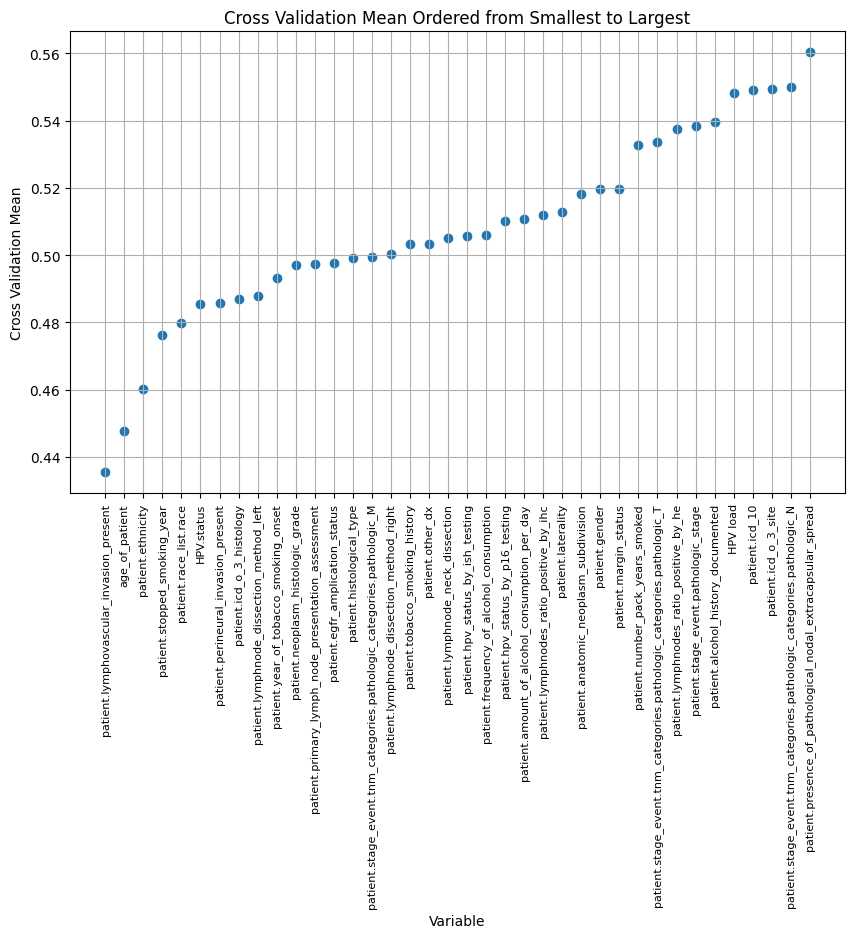

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Sort the DataFrame by the 'Cross_Validation_Mean' column in ascending order
univariate_results_df_sorted = a.sort_values(by='Cross_Validation_Mean_C_Index')

# Plot the sorted 'Cross_Validation_Mean' values with variable names as labels
# Plot the sorted 'Cross_Validation_Mean' values as dots with smaller font for variable names
plt.figure(figsize=(10, 6))
plt.scatter(range(len(univariate_results_df_sorted)), univariate_results_df_sorted['Cross_Validation_Mean_C_Index'])
plt.xticks(range(len(univariate_results_df_sorted)), univariate_results_df_sorted.index, rotation=90, fontsize=8)
plt.xlabel('Variable')
plt.ylabel('Cross Validation Mean')
plt.title('Cross Validation Mean Ordered from Smallest to Largest')
plt.grid()
plt.show()

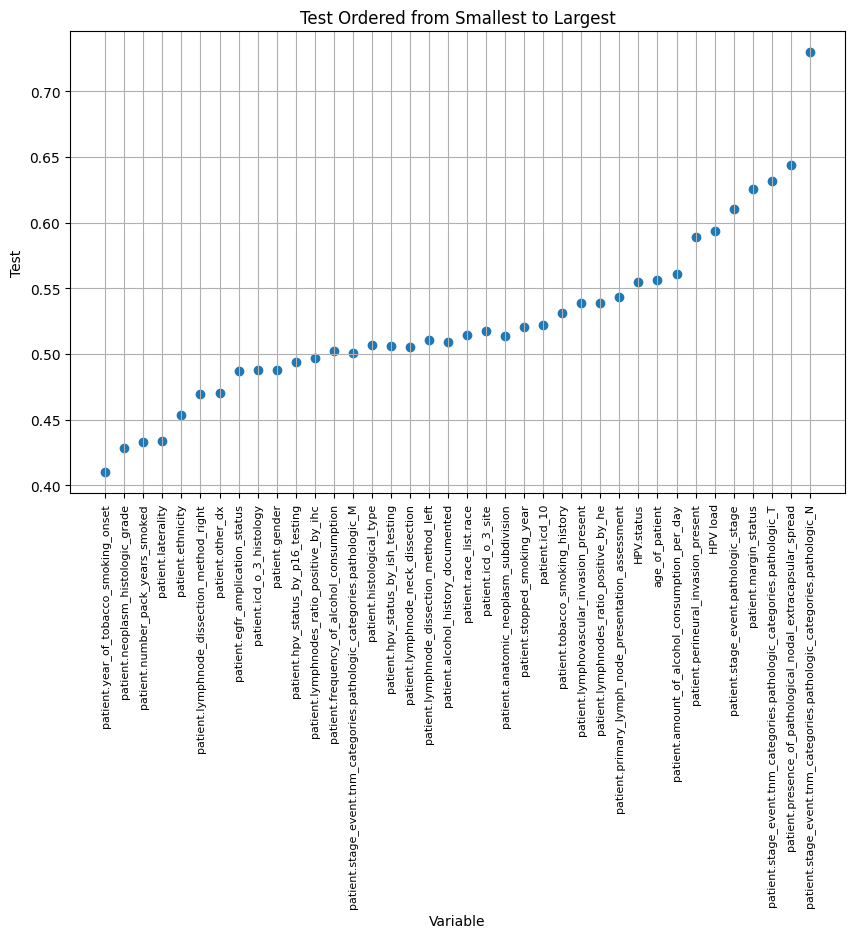

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Sort the DataFrame by the 'Cross_Validation_Mean' column in ascending order
univariate_results_df_sorted = a.sort_values(by='Test_CI_Mean')

# Plot the sorted 'Cross_Validation_Mean' values with variable names as labels
# Plot the sorted 'Cross_Validation_Mean' values as dots with smaller font for variable names
plt.figure(figsize=(10, 6))
plt.scatter(range(len(univariate_results_df_sorted)), univariate_results_df_sorted['Test_C_Index'])
plt.xticks(range(len(univariate_results_df_sorted)), univariate_results_df_sorted.index, rotation=90, fontsize=8)
plt.xlabel('Variable')
plt.ylabel('Test')
plt.title('Test Ordered from Smallest to Largest')
plt.grid()
plt.show()

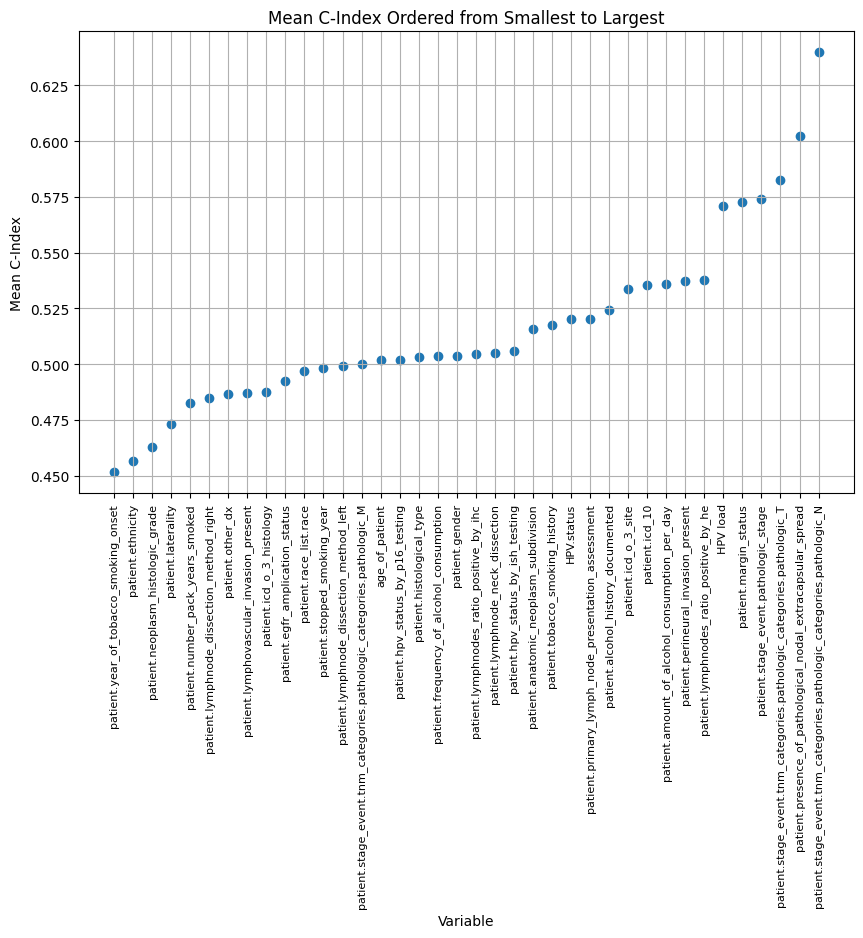

In [32]:
# Assuming 'univariate_results_df' is your DataFrame
# Create a new column for the mean of Cross_Validation_Mean_C_Index and Test_C_Index
univariate_results_df['Mean_C_Index'] = univariate_results_df[['Cross_Validation_Mean_C_Index', 'Test_C_Index']].mean(axis=1)

# Sort the DataFrame by the new 'Mean_C_Index' column in ascending order
univariate_results_df_sorted = univariate_results_df.sort_values(by='Mean_C_Index')

# Plot the sorted 'Mean_C_Index' values with variable names as labels
plt.figure(figsize=(10, 6))
plt.scatter(range(len(univariate_results_df_sorted)), univariate_results_df_sorted['Mean_C_Index'])
plt.xticks(range(len(univariate_results_df_sorted)), univariate_results_df_sorted.index, rotation=90, fontsize=8)
plt.xlabel('Variable')
plt.ylabel('Mean C-Index')
plt.title('Mean C-Index Ordered from Smallest to Largest')
plt.grid()
plt.show()

In [33]:
print(univariate_results_df['Cross_Validation_Mean_C_Index'])

patient.lymphnodes_ratio_positive_by_ihc                                 0.511953
patient.lymphnodes_ratio_positive_by_he                                  0.537480
age_of_patient                                                           0.447723
patient.tobacco_smoking_history                                          0.503237
patient.year_of_tobacco_smoking_onset                                    0.493203
patient.number_pack_years_smoked                                         0.532711
patient.stopped_smoking_year                                             0.476261
patient.frequency_of_alcohol_consumption                                 0.505838
patient.amount_of_alcohol_consumption_per_day                            0.510841
patient.stage_event.tnm_categories.pathologic_categories.pathologic_T    0.533551
patient.stage_event.tnm_categories.pathologic_categories.pathologic_N    0.549985
patient.stage_event.tnm_categories.pathologic_categories.pathologic_M    0.499402
patient.stage_ev

In [34]:
for i in range(45, 61):  # from 45 to 60 inclusive
    threshold = i / 100
    globals()[f'selected_columns_cross_{i}'] = univariate_results_df[univariate_results_df['Cross_Validation_Mean_C_Index'] > threshold].index.tolist()
    globals()[f'selected_columns_test_{i}'] = univariate_results_df[univariate_results_df['Test_C_Index'] > threshold].index.tolist()
    globals()[f'selected_columns_any_{i}'] = univariate_results_df[(univariate_results_df['Cross_Validation_Mean_C_Index'] > threshold) | (univariate_results_df['Test_C_Index'] > threshold)].index.tolist()


Testing with optimal variables below:

In [35]:
def run_deep_learning(run_selected=False,selected="_"):
    # -------------------------------------------
    # Import Necessary Libraries
    # -------------------------------------------
    import os
    import sys
    import pandas as pd
    import numpy as np
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    from tab_transformer_pytorch import FTTransformer
    from pycox.models import CoxPH
    from sksurv.metrics import concordance_index_censored
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import KFold, StratifiedShuffleSplit
    import torchtuples as tt
    import warnings
    import random

    # Suppress warnings
    warnings.filterwarnings("ignore")

    # Set random seeds for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior for CUDA (optional)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # -------------------------------------------
    # Data Preprocessing
    # -------------------------------------------

    # Assume 'clinical_data_yes' is your input DataFrame
    clinical_data_test = clinical_data_yes_id.copy()

    # Path to the JSON file containing survival data (assumed to contain WSI embeddings)
    json_path = 'svs_patient_map_PFI.json'  # Replace with your actual path if different

    # Check if JSON file exists
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"The JSON file '{json_path}' was not found.")

    # Load the JSON data into a list of dictionaries
    with open(json_path, 'r') as f:
        survival_entries = json.load(f)

    # Convert the list of dictionaries to a pandas DataFrame
    wsi_df = pd.DataFrame(survival_entries)

    # Verify that 'file_name' column exists
    if 'file_name' not in wsi_df.columns:
        raise KeyError("'file_name' column not found in the JSON data.")

    # Extract 'patient.bcr_patient_barcode' by taking the first 12 characters of 'file_name'
    def extract_barcode(file_name):
        """
        Extracts the 'patient.bcr_patient_barcode' from the 'file_name'.
        Assumes that 'file_name' starts with the barcode, e.g., 'TCGA-UF-A71E_flatten.pt'
        """
        return file_name[:12]

    wsi_df['patient.bcr_patient_barcode'] = wsi_df['file_name'].apply(extract_barcode)

    # Convert 'patient.bcr_patient_barcode' to string to ensure consistency
    wsi_df['patient.bcr_patient_barcode'] = wsi_df['patient.bcr_patient_barcode'].astype(str)

    # Adjust the filtering condition based on your actual data structure
    wsi_df = wsi_df[wsi_df['file_name'].str.contains('DX1', case=False, na=False)].reset_index(drop=True)
    # Store the initial row count of clinical_data_test
    initial_row_count = clinical_data_test.shape[0]

    # Filter clinical_data_test to keep only rows where "patient.bcr_patient_barcode" values exist in wsi_df
    clinical_data_test_filtered = clinical_data_test[
        clinical_data_test["patient.bcr_patient_barcode"].isin(wsi_df["patient.bcr_patient_barcode"])
    ]




    clinical_data_test = clinical_data_test_filtered
    clinical_data_test = clinical_data_test.drop(columns=['patient.bcr_patient_barcode'])

    # Store the final row count after filtering
    final_row_count = clinical_data_test.shape[0]

    # Print the results
    print("Total rows BEFORE:", initial_row_count)
    print("Total rows AFTER:", final_row_count)

    # Remove clinical stage system related columns
    columns_to_drop = [
        'patient.stage_event.clinical_stage',
        'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
        'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
        'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
    ]
    clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Define mapping dictionaries based on your data
    t_mapping = {
        'TX': -1,    # Primary tumor cannot be assessed
        'T0': 0,     # No evidence of primary tumor
        'T1': 1,
        'T2': 2,
        'T3': 3,
        'T4': 4,
        'T4A': 5,
        'T4B': 6
    }

    n_mapping = {
        'NX': -1,    # Regional lymph nodes cannot be assessed
        'N0': 0,
        'N1': 1,
        'N2': 2,
        'N2A': 3,
        'N2B': 4,
        'N2C': 5,
        'N3': 6
    }

    m_mapping = {
        'MX': -1,    # Distant metastasis cannot be assessed
        'M0': 0,
        'M1': 1
    }

    stage_mapping = {
        'STAGE I': 1,
        'STAGE II': 2,
        'STAGE III': 3,
        'STAGE IV': 4,
        'STAGE IVA': 5,
        'STAGE IVB': 6,
        'STAGE IVC': 7
    }

    # Functions to encode pathologic T, N, M, and stage categories
    def encode_t(value):
        if pd.isnull(value):
            return -1
        value = str(value).upper().strip()
        return t_mapping.get(value, -1)

    def encode_n(value):
        if pd.isnull(value):
            return -1
        value = str(value).upper().strip()
        return n_mapping.get(value, -1)

    def encode_m(value):
        if pd.isnull(value):
            return -1
        value = str(value).upper().strip()
        return m_mapping.get(value, -1)

    def encode_stage(value):
        if pd.isnull(value):
            return -1
        value = str(value).upper().strip()
        return stage_mapping.get(value, -1)

    # Apply encoding directly to the original columns to overwrite them
    clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
    clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
    clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
    clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
        'patient.stage_event.pathologic_stage'].apply(encode_stage)

    #clinical_data_test['HPV.status'] = clinical_data_test['HPV.status'].replace({'positive': 1, 'negative': 0})

    # Fill NaN values in 'patient.days_to_birth' with the mean
    clinical_data_test['patient.days_to_birth'].fillna(
        clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

    clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

    print(clinical_data_test['age_of_patient'])




    # Define numerical columns, including the encoded pathologic columns
    num_cols = [
        'patient.lymphnodes_ratio_positive_by_ihc',
        'patient.lymphnodes_ratio_positive_by_he',
        'age_of_patient',
        'patient.tobacco_smoking_history',
        'patient.year_of_tobacco_smoking_onset',
        'patient.number_pack_years_smoked',
        'patient.stopped_smoking_year',
        'patient.frequency_of_alcohol_consumption',
        'patient.amount_of_alcohol_consumption_per_day',
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
        'patient.stage_event.pathologic_stage',
        'HPV load'

    ]

    # Convert numerical columns to float and handle conversion errors
    for col in num_cols:
        clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

    # Fill NaN values in numerical columns
    # Define columns related to tobacco and alcohol consumption
    tobacco_alcohol_cols = [
        'patient.lymphnodes_ratio_positive_by_ihc',
        'patient.lymphnodes_ratio_positive_by_he',
        'patient.tobacco_smoking_history',
        'patient.year_of_tobacco_smoking_onset',
        'patient.number_pack_years_smoked',
        'patient.stopped_smoking_year',
        'patient.frequency_of_alcohol_consumption',
        'patient.amount_of_alcohol_consumption_per_day',
        'HPV load'
    ]

    # Fill NaN values with -1 in tobacco and alcohol-related columns
    clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

    # Fill NaN values in 'patient.days_to_birth' with the mean
    clinical_data_test['patient.days_to_birth'].fillna(
        clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

    # Fill NaN values with -1 in the encoded pathologic columns
    pathologic_cols = [
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
        'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
        'patient.stage_event.pathologic_stage'
    ]
    clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

    # Handle categorical variables
    # Identify categorical columns (object dtype)
    categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

    # Fill NaN values in categorical columns with the string "missing"
    clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

    # Encode categorical variables by converting them to categorical dtype and then to codes
    for col in categorical_cols:
        clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

    # -------------------------------------------
    # Prepare Survival Data
    # -------------------------------------------

    # Fill NaN values in 'PFI.time' with the mean
    clinical_data_test['PFI.time'].fillna(
        clinical_data_test['PFI.time'].mean(), inplace=True
    )

    # Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
    clinical_data_test['PFI'].fillna(0, inplace=True)

    # Extract survival data
    time = clinical_data_test['PFI.time'].values.astype(float)
    event = clinical_data_test['PFI'].values.astype(bool)

    time_copy = time.copy()
    event_copy = event.copy()

    # -------------------------------------------
    # Feature Engineering
    # -------------------------------------------

    # Scale numerical features
    scaler = StandardScaler()
    scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

    # Convert scaled numerical features back to DataFrame for compatibility
    scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

    # Combine scaled numerical features and categorical features into a single DataFrame
    X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

    print(X.iloc[42])

    X_copy = X.copy()

    # -------------------------------------------
    # Data Splitting
    # -------------------------------------------

    # Stratified split to maintain event proportion
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(sss.split(X, event))
    X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
    y_train_event, y_test_event = event[train_idx], event[test_idx]
    y_train_time, y_test_time = time[train_idx], time[test_idx]

    # -------------------------------------------
    # Preparing Data for FTTransformer
    # -------------------------------------------

    # Identify numerical and categorical columns after preprocessing
    categorical_columns = list(categorical_cols)
    numerical_columns = num_cols


    #run_selected = False

    if run_selected == True:

        # Update numerical_columns to be the intersection of num_cols and selected_columns_any
        numerical_columns = list(set(num_cols) & set(selected))

        # Update categorical_columns to be the intersection of categorical_cols and selected_columns_any
        categorical_columns = list(set(categorical_cols) & set(selected))


    # Prepare data for FTTransformer
    def prepare_data(X, categorical_columns, numerical_columns):
        # For categorical features
        cat_features = X[categorical_columns]
        # For numerical features
        num_features = X[numerical_columns]
        return cat_features, num_features

    X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
    X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

    # -------------------------------------------
    # Convert Data to PyTorch Tensors
    # -------------------------------------------

    # Convert data to torch tensors
    def to_tensor(x, dtype):
        return torch.tensor(x.values, dtype=dtype)

    X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
    X_train_num_tensor = to_tensor(X_train_num, torch.float32)
    X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
    X_test_num_tensor = to_tensor(X_test_num, torch.float32)

    # -------------------------------------------
    # Initialize FTTransformer (Pretrained)
    # -------------------------------------------

    # Get the number of unique categories for each categorical column
    categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

    # Instantiate the FTTransformer model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    ft_transformer = FTTransformer(
        categories=categories,                              # List of unique category counts
        num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
        dim=192,                                            # Embedding dimension size, adjust as needed
        depth=6,                                            # Number of transformer layers
        heads=8,                                            # Number of attention heads
        attn_dropout=0.1,                                   # Dropout for attention layers
        ff_dropout=0.1                                      # Dropout for feedforward layers
    ).to(device)

    # Load pretrained weights if available
    # Uncomment and modify the following line if you have pretrained weights
    # ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

    # Set the model to evaluation mode
    ft_transformer.eval()

    # -------------------------------------------
    # Generating Embeddings
    # -------------------------------------------

    def get_embeddings(model, X_cat, X_num):
        model.eval()
        with torch.no_grad():
            categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
            numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
            embeddings = model(categorical, numerical, return_embedding=True)
            return embeddings.cpu().numpy()

    # Generate embeddings for training and test sets
    train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
    test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

    # Verify the shape of the embeddings
    print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
    print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

    # -------------------------------------------
    # Define the Neural Network Architecture for CoxPH
    # -------------------------------------------

    # Define the neural network architecture
    num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

    out_features = 1  # Output dimension (single risk score)
    batch_norm = True  # Use batch normalization
    dropout = 0.4  # Dropout rate to prevent overfitting
    output_bias = False  # Bias term in the output layer

    # Initialize the MLPVanilla model with reduced input features 
    net = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )

    # Initialize the CoxPH model with the network and optimizer
    optimizer = tt.optim.Adam(lr=1e-3)
    cox_ph = CoxPH(net, optimizer)

    # -------------------------------------------
    # CoxPH Analysis with 5-Fold Cross-Validation
    # -------------------------------------------

    # Prepare survival data
    durations_train = y_train_time.astype(np.float32)
    events_train = y_train_event.astype(np.int64)

    # Ensure embeddings are contiguous
    train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

    # Initialize KFold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    c_index_scores = []

    print("\nStarting 5-Fold Cross-Validation...\n")

    for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
        print(f"Fold {fold + 1}")
        
        # Split data
        X_train_cv = train_embeddings[train_idx_cv]
        y_train_cv_durations = durations_train[train_idx_cv]
        y_train_cv_events = events_train[train_idx_cv]
        
        X_val_cv = train_embeddings[val_idx_cv]
        y_val_cv_durations = durations_train[val_idx_cv]
        y_val_cv_events = events_train[val_idx_cv]
        
        # Ensure arrays are contiguous
        X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
        y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
        y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
        
        # Initialize a new instance of the network for each fold to avoid weight sharing
        net_cv = tt.practical.MLPVanilla(
            in_features=train_embeddings.shape[1],
            num_nodes=num_nodes,
            out_features=out_features,
            batch_norm=batch_norm,
            dropout=dropout,
            output_bias=output_bias
        )
        
        # Initialize CoxPH model for this fold
        optimizer_cv = tt.optim.Adam(lr=1e-3)
        cox_ph_cv = CoxPH(net_cv, optimizer_cv)
        
        # Fit the model
        cox_ph_cv.fit(
            X_train_cv,
            (y_train_cv_events, y_train_cv_durations),
            batch_size=64,
            epochs=100,
            verbose=False
        )
        
        # Predict risk scores on validation set
        risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
        
        # Compute C-Index
        c_index = concordance_index_censored(
            y_val_cv_events.astype(bool),
            y_val_cv_durations,
            -risk_val  # Use negative risk for proper ordering
        )[0]
        
        print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
        
        c_index_scores.append(c_index)

    # Calculate Cross-Validation Mean and Uncertainty
    c_index_mean = np.mean(c_index_scores)
    c_index_std = np.std(c_index_scores)
    c_index_ci_lower = np.percentile(c_index_scores, 2.5)
    c_index_ci_upper = np.percentile(c_index_scores, 97.5)

    print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
    print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

    # -------------------------------------------
    # Train Final CoxPH Model on Entire Training Set
    # -------------------------------------------

    print("\nTraining Final CoxPH Model on Entire Training Set...\n")

    # Ensure arrays are contiguous
    train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)
    durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
    events_train = np.ascontiguousarray(events_train, dtype=np.int64)

    # Fit the final model on the entire training set
    cox_ph.fit(
        train_embeddings,
        (events_train, durations_train),
        batch_size=64,
        epochs=100,
        verbose=False
    )

    print("Final CoxPH Model Trained Successfully.")

    # -------------------------------------------
    # Evaluate on Test Set
    # -------------------------------------------

    print("\nEvaluating on Test Set...\n")

    # Prepare test data
    durations_test = y_test_time.astype(np.float32)
    events_test = y_test_event.astype(np.int64)
    test_embeddings = np.ascontiguousarray(test_embeddings, dtype=np.float32)

    # Predict risk scores on test set
    risk_test = cox_ph.predict(test_embeddings).squeeze()

    # Compute C-Index on Test Set
    c_index_test = concordance_index_censored(
        events_test.astype(bool),
        durations_test,
        -risk_test  # Use negative risk for proper ordering
    )[0]

    print(f"Test C-Index: {c_index_test:.4f}")

    # -------------------------------------------
    # Bootstrapping for Test C-Index Uncertainty
    # -------------------------------------------

    n_bootstraps = 1000
    c_index_bootstrap = []

    print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

    for i in range(n_bootstraps):
        # Resample test set with replacement
        indices = np.random.choice(len(test_embeddings), size=len(test_embeddings), replace=True)
        X_test_bs = test_embeddings[indices]
        durations_test_bs = durations_test[indices]
        events_test_bs = events_test[indices]
        
        # Predict risk scores
        risk_bs = cox_ph.predict(X_test_bs).squeeze()
        
        # Compute C-Index
        c_index_bs = concordance_index_censored(
            events_test_bs.astype(bool),
            durations_test_bs,
            -risk_bs  # Use negative risk for proper ordering
        )[0]
        
        c_index_bootstrap.append(c_index_bs)
        
        # Optional: Print progress every 100 iterations
        if (i + 1) % 100 == 0:
            print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

    # Calculate Bootstrapped C-Index Statistics
    c_index_test_mean = np.mean(c_index_bootstrap)
    c_index_test_std = np.std(c_index_bootstrap)
    c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
    c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

    print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
    print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")

    return c_index_mean, c_index_test_mean
    


In [36]:
import pandas as pd

def analyze_feature_selection(run_deep_learning_func, thresholds=range(45, 61), types=['any', 'cross', 'test']):
    """
    Runs deep learning analysis for selected columns based on C-index thresholds and types.
    
    Parameters:
    - run_deep_learning_func: Function to run deep learning, expects (bool, list) and returns two floats.
    - thresholds: Iterable of integer threshold values (from 45 to 60).
    - types: List of types ('any', 'cross', 'test') to process.
    
    Returns:
    - results_df: DataFrame containing thresholds, types, C-index values, and row names for each threshold.
    """
    results = []

    for i in thresholds:

        for t in types:
            # Construct the variable name with underscores
            var_name = f'selected_columns_{t}_{i}'
            selected_columns = globals().get(var_name, [])
            
            
            if not selected_columns:
                print(f'Warning: {var_name} does not exist or is empty.')
                continue
            
            # Call the run_deep_learning function
            cross_val_mean, test_mean = run_deep_learning_func(True, selected_columns)
            
            # Append the results, including row names (selected_columns)
            results.append({
                'Threshold': i,
                'Type': t.capitalize(),
                'Cross_Validation_Mean_C_Index': cross_val_mean,
                'Test_C_Index': test_mean,
                'var_name': var_name  # Store the row names
            })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    # Save the results to a CSV file
    results_df.to_csv('feature_selection_results.csv', index=False)
    
    print("Analysis complete. Results saved to 'feature_selection_results.csv'.")
    
    return results_df

# Example Usage:
# Ensure that selected_columns_any_0_45 to selected_columns_any_0_60,
# selected_columns_cross_0_45 to selected_columns_cross_0_60,
# and selected_columns_test_0_45 to selected_columns_test_0_60
# are defined in your environment.

# results = analyze_feature_selection(run_deep_learning)
# print(results)


In [37]:
analysis_df = analyze_feature_selection(run_deep_learning)

Total rows BEFORE: 528
Total rows AFTER: 450
0      62.521561
1      59.299110
2      54.636550
3      63.477070
5      77.344285
         ...    
522    75.857632
524    77.935661
525    56.019165
526    58.710472
527    51.247091
Name: age_of_patient, Length: 450, dtype: float64
patient.lymphnodes_ratio_positive_by_ihc                                  1.059391
patient.lymphnodes_ratio_positive_by_he                                   0.918626
age_of_patient                                                           -0.659876
patient.tobacco_smoking_history                                          -0.296069
patient.year_of_tobacco_smoking_onset                                     0.957086
patient.number_pack_years_smoked                                          1.394549
patient.stopped_smoking_year                                             -0.728405
patient.frequency_of_alcohol_consumption                                  1.740079
patient.amount_of_alcohol_consumption_per_day         

In [38]:
display_scrollable_dataframe(analysis_df)

,Threshold,Type,Cross_Validation_Mean_C_Index,Test_C_Index,var_name
0,45,Any,0.590690,0.701072,selected_columns_any_45
1,45,Cross,0.577863,0.686328,selected_columns_cross_45
2,45,Test,0.580098,0.764626,selected_columns_test_45
3,46,Any,0.590690,0.701072,selected_columns_any_46
4,46,Cross,0.577863,0.686328,selected_columns_cross_46
5,46,Test,0.590957,0.729218,selected_columns_test_46
6,47,Any,0.578775,0.687949,selected_columns_any_47
7,47,Cross,0.550650,0.673794,selected_columns_cross_47
8,47,Test,0.591722,0.700252,selected_columns_test_47
9,48,Any,0.576354,0.680267,selected_columns_any_48


In [39]:
print("a")

a


In [40]:
print(analysis_df['Test_C_Index'].max())
print(analysis_df.loc[analysis_df['Test_C_Index'].idxmax(), 'var_name'])

0.7711637688905837
selected_columns_test_50


In [41]:
print(analysis_df['Cross_Validation_Mean_C_Index'].max())
print(analysis_df.loc[analysis_df['Cross_Validation_Mean_C_Index'].idxmax(), 'var_name'])

0.618565982863841
selected_columns_test_52


In [42]:
# Find the index of the row with the highest average of the two columns
best_avg_index = (analysis_df[['Cross_Validation_Mean_C_Index', 'Test_C_Index']].mean(axis=1)).idxmax()

# Print the required values
print("Variable Name:", analysis_df.loc[best_avg_index, 'var_name'])
print("Cross Validation Mean C-Index:", analysis_df.loc[best_avg_index, 'Cross_Validation_Mean_C_Index'])
print("Test C-Index:", analysis_df.loc[best_avg_index, 'Test_C_Index'])
print("Average Value:", analysis_df[['Cross_Validation_Mean_C_Index', 'Test_C_Index']].mean(axis=1).max())


Variable Name: selected_columns_any_54
Cross Validation Mean C-Index: 0.5991719575595965
Test C-Index: 0.7701084306162691
Average Value: 0.6846401940879328


Interesting results, and honestly great job!

At this point we should ensure that we have a 1-to-1 mapping with the WS

In [34]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random
import json

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes' is your input DataFrame

#clinical_data_test = clinical_data_yes_id.drop(columns=['patient.bcr_patient_barcode']).copy()


# Assume 'clinical_data_yes' is your input DataFrame
#clinical_data_test = clinical_data_yes.copy()
clinical_data_test = clinical_data_yes_id.copy()
#clinical_data_test = clinical_data_test.drop(columns=['patient.bcr_patient_barcode'])

# Path to the JSON file containing survival data (assumed to contain WSI embeddings)
json_path = 'svs_patient_map_PFI.json'  # Replace with your actual path if different

# Check if JSON file exists
if not os.path.exists(json_path):
    raise FileNotFoundError(f"The JSON file '{json_path}' was not found.")

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
wsi_df = pd.DataFrame(survival_entries)

# Verify that 'file_name' column exists
if 'file_name' not in wsi_df.columns:
    raise KeyError("'file_name' column not found in the JSON data.")

# Extract 'patient.bcr_patient_barcode' by taking the first 12 characters of 'file_name'
def extract_barcode(file_name):
    """
    Extracts the 'patient.bcr_patient_barcode' from the 'file_name'.
    Assumes that 'file_name' starts with the barcode, e.g., 'TCGA-UF-A71E_flatten.pt'
    """
    return file_name[:12]

wsi_df['patient.bcr_patient_barcode'] = wsi_df['file_name'].apply(extract_barcode)

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
wsi_df['patient.bcr_patient_barcode'] = wsi_df['patient.bcr_patient_barcode'].astype(str)

# Adjust the filtering condition based on your actual data structure
wsi_df = wsi_df[wsi_df['file_name'].str.contains('DX1', case=False, na=False)].reset_index(drop=True)
# Store the initial row count of clinical_data_test
initial_row_count = clinical_data_test.shape[0]

# Filter clinical_data_test to keep only rows where "patient.bcr_patient_barcode" values exist in wsi_df
clinical_data_test_filtered = clinical_data_test[
    clinical_data_test["patient.bcr_patient_barcode"].isin(wsi_df["patient.bcr_patient_barcode"])
]




clinical_data_test = clinical_data_test_filtered
clinical_data_test = clinical_data_test.drop(columns=['patient.bcr_patient_barcode'])

# Store the final row count after filtering
final_row_count = clinical_data_test.shape[0]

# Print the results
print("Total rows BEFORE:", initial_row_count)
print("Total rows AFTER:", final_row_count)


#assert 1==0

#clinical_data_test.drop(columns=['patient.bcr_patient_barcode'])

#clinical_data_yes_id = clinical_data_final_updated.drop(columns=['patient.bcr_patient_uuid'])
#clinical_data_yes = clinical_data_final_updated.drop(columns=['patient.bcr_patient_barcode','patient.bcr_patient_uuid'])

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

#clinical_data_test['HPV.status'] = clinical_data_test['HPV.status'].replace({'positive': 1, 'negative': 0})

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

print(clinical_data_test['age_of_patient'])




# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'age_of_patient',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage',
    'HPV load'

]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'HPV load'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Prepare Survival Data
# -------------------------------------------

# Fill NaN values in 'PFI.time' with the mean
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)

# Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

time_copy = time.copy()
event_copy = event.copy()

# -------------------------------------------
# Feature Engineering
# -------------------------------------------

# Scale numerical features
scaler = StandardScaler()
scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

# Convert scaled numerical features back to DataFrame for compatibility
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

# Combine scaled numerical features and categorical features into a single DataFrame
X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

print(X.iloc[42])

X_copy = X.copy()

# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, event))
X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
y_train_event, y_test_event = event[train_idx], event[test_idx]
y_train_time, y_test_time = time[train_idx], time[test_idx]

# -------------------------------------------
# Preparing Data for FTTransformer
# -------------------------------------------

# Identify numerical and categorical columns after preprocessing
categorical_columns = list(categorical_cols)
numerical_columns = num_cols

# Prepare data for FTTransformer
def prepare_data(X, categorical_columns, numerical_columns):
    # For categorical features
    cat_features = X[categorical_columns]
    # For numerical features
    num_features = X[numerical_columns]
    return cat_features, num_features

X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

# -------------------------------------------
# Convert Data to PyTorch Tensors
# -------------------------------------------

# Convert data to torch tensors
def to_tensor(x, dtype):
    return torch.tensor(x.values, dtype=dtype)

X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
X_train_num_tensor = to_tensor(X_train_num, torch.float32)
X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
X_test_num_tensor = to_tensor(X_test_num, torch.float32)

# -------------------------------------------
# Initialize FTTransformer (Pretrained)
# -------------------------------------------

# Get the number of unique categories for each categorical column
categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

# Instantiate the FTTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ft_transformer = FTTransformer(
    categories=categories,                              # List of unique category counts
    num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
    dim=192,                                            # Embedding dimension size, adjust as needed
    depth=6,                                            # Number of transformer layers
    heads=8,                                            # Number of attention heads
    attn_dropout=0.1,                                   # Dropout for attention layers
    ff_dropout=0.1                                      # Dropout for feedforward layers
).to(device)

# Load pretrained weights if available
# Uncomment and modify the following line if you have pretrained weights
# ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

# Set the model to evaluation mode
ft_transformer.eval()

# -------------------------------------------
# Generating Embeddings
# -------------------------------------------

def get_embeddings(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
        numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
        embeddings = model(categorical, numerical, return_embedding=True)
        return embeddings.cpu().numpy()

# Generate embeddings for training and test sets
train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

# Verify the shape of the embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Initialize the MLPVanilla model with reduced input features 
net = tt.practical.MLPVanilla(
    in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
    num_nodes=num_nodes,
    out_features=out_features,
    batch_norm=batch_norm,
    dropout=dropout,
    output_bias=output_bias
)

# Initialize the CoxPH model with the network and optimizer
optimizer = tt.optim.Adam(lr=1e-3)
cox_ph = CoxPH(net, optimizer)

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
durations_train = y_train_time.astype(np.float32)
events_train = y_train_event.astype(np.int64)

# Ensure embeddings are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = train_embeddings[train_idx_cv]
    y_train_cv_durations = durations_train[train_idx_cv]
    y_train_cv_events = events_train[train_idx_cv]
    
    X_val_cv = train_embeddings[val_idx_cv]
    y_val_cv_durations = durations_train[val_idx_cv]
    y_val_cv_events = events_train[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
    
    # Initialize a new instance of the network for each fold to avoid weight sharing
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    c_index = concordance_index_censored(
        y_val_cv_events.astype(bool),
        y_val_cv_durations,
        -risk_val  # Use negative risk for proper ordering
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("\nTraining Final CoxPH Model on Entire Training Set...\n")

# Ensure arrays are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)
durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
events_train = np.ascontiguousarray(events_train, dtype=np.int64)

# Fit the final model on the entire training set
cox_ph.fit(
    train_embeddings,
    (events_train, durations_train),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("\nEvaluating on Test Set...\n")

# Prepare test data
durations_test = y_test_time.astype(np.float32)
events_test = y_test_event.astype(np.int64)
test_embeddings = np.ascontiguousarray(test_embeddings, dtype=np.float32)

# Predict risk scores on test set
risk_test = cox_ph.predict(test_embeddings).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    events_test.astype(bool),
    durations_test,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(test_embeddings), size=len(test_embeddings), replace=True)
    X_test_bs = test_embeddings[indices]
    durations_test_bs = durations_test[indices]
    events_test_bs = events_test[indices]
    
    # Predict risk scores
    risk_bs = cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs.astype(bool),
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")


Total rows BEFORE: 528
Total rows AFTER: 450
0      62.521561
1      59.299110
2      54.636550
3      63.477070
5      77.344285
         ...    
522    75.857632
524    77.935661
525    56.019165
526    58.710472
527    51.247091
Name: age_of_patient, Length: 450, dtype: float64
patient.lymphnodes_ratio_positive_by_ihc                                  1.059391
patient.lymphnodes_ratio_positive_by_he                                   0.918626
age_of_patient                                                           -0.659876
patient.tobacco_smoking_history                                          -0.296069
patient.year_of_tobacco_smoking_onset                                     0.957086
patient.number_pack_years_smoked                                          1.394549
patient.stopped_smoking_year                                             -0.728405
patient.frequency_of_alcohol_consumption                                  1.740079
patient.amount_of_alcohol_consumption_per_day         

Saving train test split strategy:

In [44]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedShuffleSplit
import torchtuples as tt
import warnings
import random
import json

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes_id' is your input DataFrame
clinical_data_test = clinical_data_yes_id.copy()

# Path to the JSON file containing survival data (assumed to contain WSI embeddings)
json_path = 'svs_patient_map_PFI.json'  # Replace with your actual path if different

# Check if JSON file exists
if not os.path.exists(json_path):
    raise FileNotFoundError(f"The JSON file '{json_path}' was not found.")

# Load the JSON data into a list of dictionaries
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
wsi_df = pd.DataFrame(survival_entries)

# Verify that 'file_name' column exists
if 'file_name' not in wsi_df.columns:
    raise KeyError("'file_name' column not found in the JSON data.")

# Extract 'patient.bcr_patient_barcode' by taking the first 12 characters of 'file_name'
def extract_barcode(file_name):
    """
    Extracts the 'patient.bcr_patient_barcode' from the 'file_name'.
    Assumes that 'file_name' starts with the barcode, e.g., 'TCGA-UF-A71E_flatten.pt'
    """
    return file_name[:12]

wsi_df['patient.bcr_patient_barcode'] = wsi_df['file_name'].apply(extract_barcode)

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
wsi_df['patient.bcr_patient_barcode'] = wsi_df['patient.bcr_patient_barcode'].astype(str)

# Adjust the filtering condition based on your actual data structure
wsi_df = wsi_df[wsi_df['file_name'].str.contains('DX1', case=False, na=False)].reset_index(drop=True)

# Store the initial row count of clinical_data_test
initial_row_count = clinical_data_test.shape[0]

# Filter clinical_data_test to keep only rows where "patient.bcr_patient_barcode" values exist in wsi_df
clinical_data_test_filtered = clinical_data_test[
    clinical_data_test["patient.bcr_patient_barcode"].isin(wsi_df["patient.bcr_patient_barcode"])
]

clinical_data_test = clinical_data_test_filtered

# Make a copy with 'patient.bcr_patient_barcode' for mapping
clinical_data_with_id = clinical_data_test.copy()

# Drop 'patient.bcr_patient_barcode' from clinical_data_test as per original script
clinical_data_test = clinical_data_test.drop(columns=['patient.bcr_patient_barcode'])

# Store the final row count after filtering
final_row_count = clinical_data_test.shape[0]

# Print the results
print("Total rows BEFORE:", initial_row_count)
print("Total rows AFTER:", final_row_count)

# Remove clinical stage system related columns
columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mapping dictionaries based on your data
t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

# Functions to encode pathologic T, N, M, and stage categories
def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding directly to the original columns to overwrite them
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)
clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'age_of_patient',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage',
    'HPV load'
]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Fill NaN values in numerical columns
# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'HPV load'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values in 'patient.days_to_birth' with the mean (already done above)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Handle categorical variables
# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Prepare Survival Data
# -------------------------------------------

# Fill NaN values in 'PFI.time' with the mean
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)

# Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

time_copy = time.copy()
event_copy = event.copy()

# -------------------------------------------
# Feature Engineering
# -------------------------------------------

# Scale numerical features
scaler = StandardScaler()
scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

# Convert scaled numerical features back to DataFrame for compatibility
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

# Combine scaled numerical features and categorical features into a single DataFrame
X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

# Optional: Print a sample entry
print(X.iloc[42])

X_copy = X.copy()

# -------------------------------------------
# Data Splitting
# -------------------------------------------

# Stratified split to maintain event proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, event))

X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
y_train_event, y_test_event = event[train_idx], event[test_idx]
y_train_time, y_test_time = time[train_idx], time[test_idx]

# -------------------------------------------
# Create Train/Test Split Mapping
# -------------------------------------------

# Extract corresponding barcodes for train and test indices
train_barcodes = clinical_data_with_id.iloc[train_idx]['patient.bcr_patient_barcode'].tolist()
test_barcodes = clinical_data_with_id.iloc[test_idx]['patient.bcr_patient_barcode'].tolist()

# Create a mapping dictionary
split_mapping = {}
for barcode in train_barcodes:
    split_mapping[barcode] = 'train'
for barcode in test_barcodes:
    split_mapping[barcode] = 'test'

# -------------------------------------------
# Preparing Data for FTTransformer
# -------------------------------------------

# Identify numerical and categorical columns after preprocessing
categorical_columns = list(categorical_cols)
numerical_columns = num_cols

# Prepare data for FTTransformer
def prepare_data(X, categorical_columns, numerical_columns):
    # For categorical features
    cat_features = X[categorical_columns]
    # For numerical features
    num_features = X[numerical_columns]
    return cat_features, num_features

X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

# -------------------------------------------
# Convert Data to PyTorch Tensors
# -------------------------------------------

# Convert data to torch tensors
def to_tensor(x, dtype):
    return torch.tensor(x.values, dtype=dtype)

X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
X_train_num_tensor = to_tensor(X_train_num, torch.float32)
X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
X_test_num_tensor = to_tensor(X_test_num, torch.float32)

# -------------------------------------------
# Initialize FTTransformer (Pretrained)
# -------------------------------------------

# Get the number of unique categories for each categorical column
categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

# Instantiate the FTTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ft_transformer = FTTransformer(
    categories=categories,                              # List of unique category counts
    num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
    dim=192,                                            # Embedding dimension size, adjust as needed
    depth=6,                                            # Number of transformer layers
    heads=8,                                            # Number of attention heads
    attn_dropout=0.1,                                   # Dropout for attention layers
    ff_dropout=0.1                                      # Dropout for feedforward layers
).to(device)

# Load pretrained weights if available
# Uncomment and modify the following line if you have pretrained weights
# ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

# Set the model to evaluation mode
ft_transformer.eval()

# -------------------------------------------
# Generating Embeddings
# -------------------------------------------

def get_embeddings(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
        numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
        embeddings = model(categorical, numerical, return_embedding=True)
        return embeddings.cpu().numpy()

# Generate embeddings for training and test sets
train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

# Verify the shape of the embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Initialize the MLPVanilla model with reduced input features 
net = tt.practical.MLPVanilla(
    in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
    num_nodes=num_nodes,
    out_features=out_features,
    batch_norm=batch_norm,
    dropout=dropout,
    output_bias=output_bias
)

# Initialize the CoxPH model with the network and optimizer
optimizer = tt.optim.Adam(lr=1e-3)
cox_ph = CoxPH(net, optimizer)

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
durations_train = y_train_time.astype(np.float32)
events_train = y_train_event.astype(np.int64)

# Ensure embeddings are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = train_embeddings[train_idx_cv]
    y_train_cv_durations = durations_train[train_idx_cv]
    y_train_cv_events = events_train[train_idx_cv]
    
    X_val_cv = train_embeddings[val_idx_cv]
    y_val_cv_durations = durations_train[val_idx_cv]
    y_val_cv_events = events_train[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
    
    # Initialize a new instance of the network for each fold to avoid weight sharing
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    c_index = concordance_index_censored(
        y_val_cv_events.astype(bool),
        y_val_cv_durations,
        -risk_val  # Use negative risk for proper ordering
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Create Train/Test Split Mapping
# -------------------------------------------

# Extract corresponding barcodes for train and test indices
train_barcodes = clinical_data_with_id.iloc[train_idx]['patient.bcr_patient_barcode'].tolist()
test_barcodes = clinical_data_with_id.iloc[test_idx]['patient.bcr_patient_barcode'].tolist()

# Create a mapping dictionary
split_mapping = {}
for barcode in train_barcodes:
    split_mapping[barcode] = 'train'
for barcode in test_barcodes:
    split_mapping[barcode] = 'test'

# -------------------------------------------
# Save Split Mapping to New JSON File
# -------------------------------------------

# Update the split in the original filtered_entries
for entry in survival_entries:
    barcode = extract_barcode(entry.get("file_name", ""))
    if "DX1" in entry.get("file_name", ""):
        entry["split"] = split_mapping.get(barcode, "unknown")

# Filter entries to include only those with "DX1" in the file_name
filtered_entries = [entry for entry in survival_entries if "DX1" in entry.get("file_name", "")]

# Save the updated entries with the split information to a new JSON file
output_path = 'svs_patient_map_PFI_DX_split.json'
with open(output_path, 'w') as f:
    json.dump(filtered_entries, f, indent=4)

# Print the results
total_entries = len(filtered_entries)
print(f"\nFiltered JSON with train/test split saved as '{output_path}'")
print(f"Total entries in the filtered dataset: {total_entries}")



Total rows BEFORE: 528
Total rows AFTER: 450
patient.lymphnodes_ratio_positive_by_ihc                                  1.059391
patient.lymphnodes_ratio_positive_by_he                                   0.918626
age_of_patient                                                           -0.659876
patient.tobacco_smoking_history                                          -0.296069
patient.year_of_tobacco_smoking_onset                                     0.957086
patient.number_pack_years_smoked                                          1.394549
patient.stopped_smoking_year                                             -0.728405
patient.frequency_of_alcohol_consumption                                  1.740079
patient.amount_of_alcohol_consumption_per_day                             4.540241
patient.stage_event.tnm_categories.pathologic_categories.pathologic_T     1.154674
patient.stage_event.tnm_categories.pathologic_categories.pathologic_N    -0.666384
patient.stage_event.tnm_categories.patholo

In [48]:
# -------------------------------------------
# Import Necessary Libraries
# -------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import FTTransformer
from pycox.models import CoxPH
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import torchtuples as tt
import warnings
import random
import json

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior for CUDA (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Data Preprocessing
# -------------------------------------------

# Assume 'clinical_data_yes_id' is your input DataFrame
clinical_data_test = clinical_data_yes_id.copy()

# Paths to the JSON files
json_path = 'svs_patient_map_PFI.json'  # Original JSON file
split_json_path = 'svs_patient_map_PFI_DX_split.json'  # JSON file with split information

# Check if JSON files exist
if not os.path.exists(json_path):
    raise FileNotFoundError(f"The JSON file '{json_path}' was not found.")
if not os.path.exists(split_json_path):
    raise FileNotFoundError(f"The JSON file '{split_json_path}' was not found.")

# Load the original JSON data
with open(json_path, 'r') as f:
    survival_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
wsi_df = pd.DataFrame(survival_entries)

# Verify that 'file_name' column exists
if 'file_name' not in wsi_df.columns:
    raise KeyError("'file_name' column not found in the JSON data.")

# Function to extract 'patient.bcr_patient_barcode' from 'file_name'
def extract_barcode(file_name):
    """
    Extracts the 'patient.bcr_patient_barcode' from the 'file_name'.
    Assumes that 'file_name' starts with the barcode, e.g., 'TCGA-XX-XXXX'
    """
    return file_name[:12]

# Extract 'patient.bcr_patient_barcode' in wsi_df
wsi_df['patient.bcr_patient_barcode'] = wsi_df['file_name'].apply(extract_barcode)

# Convert 'patient.bcr_patient_barcode' to string to ensure consistency
wsi_df['patient.bcr_patient_barcode'] = wsi_df['patient.bcr_patient_barcode'].astype(str)

# Adjust the filtering condition based on your actual data structure
wsi_df = wsi_df[wsi_df['file_name'].str.contains('DX1', case=False, na=False)].reset_index(drop=True)

# Store the initial row count of clinical_data_test
initial_row_count = clinical_data_test.shape[0]

# Filter clinical_data_test to keep only rows where "patient.bcr_patient_barcode" values exist in wsi_df
clinical_data_test_filtered = clinical_data_test[
    clinical_data_test["patient.bcr_patient_barcode"].isin(wsi_df["patient.bcr_patient_barcode"])
].copy()

clinical_data_test = clinical_data_test_filtered

# Make a copy with 'patient.bcr_patient_barcode' for mapping
clinical_data_with_id = clinical_data_test.copy()

# Store the final row count after filtering
final_row_count = clinical_data_test.shape[0]

# Print the results
print("Total rows BEFORE:", initial_row_count)
print("Total rows AFTER:", final_row_count)

# -------------------------------------------
# Load Split Information and Assign Splits
# -------------------------------------------

# Load the split JSON data
with open(split_json_path, 'r') as f:
    split_entries = json.load(f)

# Convert the list of dictionaries to a pandas DataFrame
split_df = pd.DataFrame(split_entries)

# Verify that 'file_name' exists in split_df
if 'file_name' not in split_df.columns:
    raise KeyError("'file_name' column not found in the split JSON data.")

# Extract 'patient.bcr_patient_barcode' from 'file_name' in split_df
split_df['patient.bcr_patient_barcode'] = split_df['file_name'].apply(extract_barcode)

# Create a mapping from 'patient.bcr_patient_barcode' to 'split'
barcode_to_split = dict(zip(split_df['patient.bcr_patient_barcode'], split_df['split']))

# Map the 'split' to the clinical data
clinical_data_test['split'] = clinical_data_test['patient.bcr_patient_barcode'].map(barcode_to_split)

# Check for any missing splits
missing_splits = clinical_data_test['split'].isnull().sum()
if missing_splits > 0:
    print(f"Warning: {missing_splits} entries do not have a split assignment.")
    # Optionally, you can decide how to handle these entries
    clinical_data_test = clinical_data_test.dropna(subset=['split'])

# Create boolean masks for training and testing sets
train_mask = clinical_data_test['split'] == 'train'
test_mask = clinical_data_test['split'] == 'test'

# Print the number of train and test samples
print(f"Number of training samples: {train_mask.sum()}")
print(f"Number of testing samples: {test_mask.sum()}")

# After mapping, drop 'patient.bcr_patient_barcode' and 'split' as they are no longer needed
clinical_data_test = clinical_data_test.drop(columns=['patient.bcr_patient_barcode', 'split'])

# -------------------------------------------
# Remove Clinical Stage System Related Columns
# -------------------------------------------

columns_to_drop = [
    'patient.stage_event.clinical_stage',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_T',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_N',
    'patient.stage_event.tnm_categories.clinical_categories.clinical_M',
]
clinical_data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# -------------------------------------------
# Define Mapping Dictionaries and Encoding Functions
# -------------------------------------------

t_mapping = {
    'TX': -1,    # Primary tumor cannot be assessed
    'T0': 0,     # No evidence of primary tumor
    'T1': 1,
    'T2': 2,
    'T3': 3,
    'T4': 4,
    'T4A': 5,
    'T4B': 6
}

n_mapping = {
    'NX': -1,    # Regional lymph nodes cannot be assessed
    'N0': 0,
    'N1': 1,
    'N2': 2,
    'N2A': 3,
    'N2B': 4,
    'N2C': 5,
    'N3': 6
}

m_mapping = {
    'MX': -1,    # Distant metastasis cannot be assessed
    'M0': 0,
    'M1': 1
}

stage_mapping = {
    'STAGE I': 1,
    'STAGE II': 2,
    'STAGE III': 3,
    'STAGE IV': 4,
    'STAGE IVA': 5,
    'STAGE IVB': 6,
    'STAGE IVC': 7
}

def encode_t(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return t_mapping.get(value, -1)

def encode_n(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return n_mapping.get(value, -1)

def encode_m(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return m_mapping.get(value, -1)

def encode_stage(value):
    if pd.isnull(value):
        return -1
    value = str(value).upper().strip()
    return stage_mapping.get(value, -1)

# Apply encoding to the relevant columns
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T'].apply(encode_t)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N'].apply(encode_n)
clinical_data_test['patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'] = clinical_data_test[
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M'].apply(encode_m)
clinical_data_test['patient.stage_event.pathologic_stage'] = clinical_data_test[
    'patient.stage_event.pathologic_stage'].apply(encode_stage)

# -------------------------------------------
# Handle Missing Values and Encode Categorical Variables
# -------------------------------------------

# Fill NaN values in 'patient.days_to_birth' with the mean
clinical_data_test['patient.days_to_birth'].fillna(
    clinical_data_test['patient.days_to_birth'].mean(), inplace=True)
clinical_data_test['age_of_patient'] = clinical_data_test['patient.days_to_birth'] / 365.25

# Define numerical columns, including the encoded pathologic columns
num_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'age_of_patient',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage',
    'HPV load'
]

# Convert numerical columns to float and handle conversion errors
for col in num_cols:
    clinical_data_test[col] = pd.to_numeric(clinical_data_test[col], errors='coerce')

# Define columns related to tobacco and alcohol consumption
tobacco_alcohol_cols = [
    'patient.lymphnodes_ratio_positive_by_ihc',
    'patient.lymphnodes_ratio_positive_by_he',
    'patient.tobacco_smoking_history',
    'patient.year_of_tobacco_smoking_onset',
    'patient.number_pack_years_smoked',
    'patient.stopped_smoking_year',
    'patient.frequency_of_alcohol_consumption',
    'patient.amount_of_alcohol_consumption_per_day',
    'HPV load'
]

# Fill NaN values with -1 in tobacco and alcohol-related columns
clinical_data_test[tobacco_alcohol_cols] = clinical_data_test[tobacco_alcohol_cols].fillna(-1)

# Fill NaN values with -1 in the encoded pathologic columns
pathologic_cols = [
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_T',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_N',
    'patient.stage_event.tnm_categories.pathologic_categories.pathologic_M',
    'patient.stage_event.pathologic_stage'
]
clinical_data_test[pathologic_cols] = clinical_data_test[pathologic_cols].fillna(-1)

# Identify categorical columns (object dtype)
categorical_cols = clinical_data_test.select_dtypes(include=['object']).columns

# Fill NaN values in categorical columns with the string "missing"
clinical_data_test[categorical_cols] = clinical_data_test[categorical_cols].fillna("missing")

# Encode categorical variables by converting them to categorical dtype and then to codes
for col in categorical_cols:
    clinical_data_test[col] = clinical_data_test[col].astype('category').cat.codes

# -------------------------------------------
# Prepare Survival Data
# -------------------------------------------

# Fill NaN values in 'PFI.time' with the mean
clinical_data_test['PFI.time'].fillna(
    clinical_data_test['PFI.time'].mean(), inplace=True
)

# Fill NaN values in 'PFI' with 0 (assuming missing events are non-events)
clinical_data_test['PFI'].fillna(0, inplace=True)

# Extract survival data
time = clinical_data_test['PFI.time'].values.astype(float)
event = clinical_data_test['PFI'].values.astype(bool)

# -------------------------------------------
# Feature Engineering
# -------------------------------------------

# Scale numerical features
scaler = StandardScaler()
scaled_num_cols = scaler.fit_transform(clinical_data_test[num_cols])

# Convert scaled numerical features back to DataFrame for compatibility
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_cols, index=clinical_data_test.index)

# Combine scaled numerical features and categorical features into a single DataFrame
X = pd.concat([scaled_num_cols_df, clinical_data_test[categorical_cols]], axis=1)

# Optional: Print a sample entry
print("Sample feature vector (row 42):")
print(X.iloc[42])

# -------------------------------------------
# Data Splitting Using Split Mapping
# -------------------------------------------

# Reset indices to ensure alignment
clinical_data_test.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)

# Create masks based on the splits
train_mask = train_mask.reset_index(drop=True)
test_mask = test_mask.reset_index(drop=True)

# Create train and test sets based on the masks
X_train_df = X[train_mask]
X_test_df = X[test_mask]
y_train_event = event[train_mask]
y_test_event = event[test_mask]
y_train_time = time[train_mask]
y_test_time = time[test_mask]

# Verify the lengths to prevent IndexError
print(f"Training set size: {X_train_df.shape[0]}")
print(f"Testing set size: {X_test_df.shape[0]}")

# -------------------------------------------
# Preparing Data for FTTransformer
# -------------------------------------------

# Identify numerical and categorical columns after preprocessing
categorical_columns = list(categorical_cols)
numerical_columns = num_cols

# Prepare data for FTTransformer
def prepare_data(X, categorical_columns, numerical_columns):
    # For categorical features
    cat_features = X[categorical_columns]
    # For numerical features
    num_features = X[numerical_columns]
    return cat_features, num_features

X_train_cat, X_train_num = prepare_data(X_train_df, categorical_columns, numerical_columns)
X_test_cat, X_test_num = prepare_data(X_test_df, categorical_columns, numerical_columns)

# -------------------------------------------
# Convert Data to PyTorch Tensors
# -------------------------------------------

# Convert data to torch tensors
def to_tensor(x, dtype):
    return torch.tensor(x.values, dtype=dtype)

X_train_cat_tensor = to_tensor(X_train_cat, torch.long)
X_train_num_tensor = to_tensor(X_train_num, torch.float32)
X_test_cat_tensor = to_tensor(X_test_cat, torch.long)
X_test_num_tensor = to_tensor(X_test_num, torch.float32)

# -------------------------------------------
# Initialize FTTransformer (Pretrained)
# -------------------------------------------

# Get the number of unique categories for each categorical column
categories = [int(X_train_cat[col].max() + 1) for col in categorical_columns]

# Instantiate the FTTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ft_transformer = FTTransformer(
    categories=categories,                              # List of unique category counts
    num_continuous=X_train_num_tensor.shape[1],         # Number of continuous features
    dim=192,                                            # Embedding dimension size, adjust as needed
    depth=6,                                            # Number of transformer layers
    heads=8,                                            # Number of attention heads
    attn_dropout=0.1,                                   # Dropout for attention layers
    ff_dropout=0.1                                      # Dropout for feedforward layers
).to(device)

# Load pretrained weights if available
# Uncomment and modify the following line if you have pretrained weights
# ft_transformer.load_state_dict(torch.load('path_to_pretrained_ft_transformer.pth'))

# Set the model to evaluation mode
ft_transformer.eval()

# -------------------------------------------
# Generating Embeddings
# -------------------------------------------

def get_embeddings(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        categorical = torch.tensor(X_cat.values, dtype=torch.long).to(device)
        numerical = torch.tensor(X_num.values, dtype=torch.float32).to(device)
        embeddings = model(categorical, numerical, return_embedding=True)
        return embeddings.cpu().numpy()

# Generate embeddings for training and test sets
train_embeddings = get_embeddings(ft_transformer, X_train_cat, X_train_num)
test_embeddings = get_embeddings(ft_transformer, X_test_cat, X_test_num)

# Verify the shape of the embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # Expected: (num_train_samples, dim)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # Expected: (num_test_samples, dim)

# -------------------------------------------
# Define the Neural Network Architecture for CoxPH
# -------------------------------------------

# Define the neural network architecture
num_nodes = [192, 128, 64]  # Number of neurons in each hidden layer

out_features = 1  # Output dimension (single risk score)
batch_norm = True  # Use batch normalization
dropout = 0.4  # Dropout rate to prevent overfitting
output_bias = False  # Bias term in the output layer

# Initialize the MLPVanilla model with reduced input features 
net = tt.practical.MLPVanilla(
    in_features=train_embeddings.shape[1],  # Number of input features (embedding dimension)
    num_nodes=num_nodes,
    out_features=out_features,
    batch_norm=batch_norm,
    dropout=dropout,
    output_bias=output_bias
)

# Initialize the CoxPH model with the network and optimizer
optimizer = tt.optim.Adam(lr=1e-3)
cox_ph = CoxPH(net, optimizer)

# -------------------------------------------
# CoxPH Analysis with 5-Fold Cross-Validation
# -------------------------------------------

# Prepare survival data
durations_train = y_train_time.astype(np.float32)
events_train = y_train_event.astype(np.int64)

# Ensure embeddings are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)

# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

print("\nStarting 5-Fold Cross-Validation...\n")

for fold, (train_idx_cv, val_idx_cv) in enumerate(kf.split(train_embeddings)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train_cv = train_embeddings[train_idx_cv]
    y_train_cv_durations = durations_train[train_idx_cv]
    y_train_cv_events = events_train[train_idx_cv]
    
    X_val_cv = train_embeddings[val_idx_cv]
    y_val_cv_durations = durations_train[val_idx_cv]
    y_val_cv_events = events_train[val_idx_cv]
    
    # Ensure arrays are contiguous
    X_train_cv = np.ascontiguousarray(X_train_cv, dtype=np.float32)
    y_train_cv_durations = np.ascontiguousarray(y_train_cv_durations, dtype=np.float32)
    y_train_cv_events = np.ascontiguousarray(y_train_cv_events, dtype=np.int64)
    
    # Initialize a new instance of the network for each fold to avoid weight sharing
    net_cv = tt.practical.MLPVanilla(
        in_features=train_embeddings.shape[1],
        num_nodes=num_nodes,
        out_features=out_features,
        batch_norm=batch_norm,
        dropout=dropout,
        output_bias=output_bias
    )
    
    # Initialize CoxPH model for this fold
    optimizer_cv = tt.optim.Adam(lr=1e-3)
    cox_ph_cv = CoxPH(net_cv, optimizer_cv)
    
    # Fit the model
    cox_ph_cv.fit(
        X_train_cv,
        (y_train_cv_events, y_train_cv_durations),
        batch_size=64,
        epochs=100,
        verbose=False
    )
    
    # Predict risk scores on validation set
    risk_val = cox_ph_cv.predict(X_val_cv).squeeze()
    
    # Compute C-Index
    c_index = concordance_index_censored(
        y_val_cv_events.astype(bool),
        y_val_cv_durations,
        -risk_val  # Use negative risk for proper ordering
    )[0]
    
    print(f"Fold {fold + 1} C-Index: {c_index:.4f}\n")
    
    c_index_scores.append(c_index)

# Calculate Cross-Validation Mean and Uncertainty
c_index_mean = np.mean(c_index_scores)
c_index_std = np.std(c_index_scores)
c_index_ci_lower = np.percentile(c_index_scores, 2.5)
c_index_ci_upper = np.percentile(c_index_scores, 97.5)

print(f"Cross-Validation C-Index: {c_index_mean:.4f} ± {c_index_std:.4f}")
print(f"95% Confidence Interval: [{c_index_ci_lower:.4f}, {c_index_ci_upper:.4f}]")

# -------------------------------------------
# Train Final CoxPH Model on Entire Training Set
# -------------------------------------------

print("\nTraining Final CoxPH Model on Entire Training Set...\n")

# Ensure arrays are contiguous
train_embeddings = np.ascontiguousarray(train_embeddings, dtype=np.float32)
durations_train = np.ascontiguousarray(durations_train, dtype=np.float32)
events_train = np.ascontiguousarray(events_train, dtype=np.int64)

# Fit the final model on the entire training set
cox_ph.fit(
    train_embeddings,
    (events_train, durations_train),
    batch_size=64,
    epochs=100,
    verbose=False
)

print("Final CoxPH Model Trained Successfully.")

# -------------------------------------------
# Evaluate on Test Set
# -------------------------------------------

print("\nEvaluating on Test Set...\n")

# Prepare test data
durations_test = y_test_time.astype(np.float32)
events_test = y_test_event.astype(np.int64)
test_embeddings = np.ascontiguousarray(test_embeddings, dtype=np.float32)

# Predict risk scores on test set
risk_test = cox_ph.predict(test_embeddings).squeeze()

# Compute C-Index on Test Set
c_index_test = concordance_index_censored(
    events_test.astype(bool),
    durations_test,
    -risk_test  # Use negative risk for proper ordering
)[0]

print(f"Test C-Index: {c_index_test:.4f}")

# -------------------------------------------
# Bootstrapping for Test C-Index Uncertainty
# -------------------------------------------

n_bootstraps = 1000
c_index_bootstrap = []

print("\nStarting Bootstrapping for Test C-Index Uncertainty...\n")

for i in range(n_bootstraps):
    # Resample test set with replacement
    indices = np.random.choice(len(test_embeddings), size=len(test_embeddings), replace=True)
    X_test_bs = test_embeddings[indices]
    durations_test_bs = durations_test[indices]
    events_test_bs = events_test[indices]
    
    # Predict risk scores
    risk_bs = cox_ph.predict(X_test_bs).squeeze()
    
    # Compute C-Index
    c_index_bs = concordance_index_censored(
        events_test_bs.astype(bool),
        durations_test_bs,
        -risk_bs  # Use negative risk for proper ordering
    )[0]
    
    c_index_bootstrap.append(c_index_bs)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Bootstrap {i + 1}/{n_bootstraps} completed.")

# Calculate Bootstrapped C-Index Statistics
c_index_test_mean = np.mean(c_index_bootstrap)
c_index_test_std = np.std(c_index_bootstrap)
c_index_test_ci_lower = np.percentile(c_index_bootstrap, 2.5)
c_index_test_ci_upper = np.percentile(c_index_bootstrap, 97.5)

print(f"\nTest C-Index with Bootstrapping: {c_index_test_mean:.4f} ± {c_index_test_std:.4f}")
print(f"95% Confidence Interval: [{c_index_test_ci_lower:.4f}, {c_index_test_ci_upper:.4f}]")


Total rows BEFORE: 528
Total rows AFTER: 450
Number of training samples: 360
Number of testing samples: 90
Sample feature vector (row 42):
patient.lymphnodes_ratio_positive_by_ihc                                  1.059391
patient.lymphnodes_ratio_positive_by_he                                   0.918626
age_of_patient                                                           -0.659876
patient.tobacco_smoking_history                                          -0.296069
patient.year_of_tobacco_smoking_onset                                     0.957086
patient.number_pack_years_smoked                                          1.394549
patient.stopped_smoking_year                                             -0.728405
patient.frequency_of_alcohol_consumption                                  1.740079
patient.amount_of_alcohol_consumption_per_day                             4.540241
patient.stage_event.tnm_categories.pathologic_categories.pathologic_T     1.154674
patient.stage_event.tnm_categor